In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy import cos, sin, sqrt, arctan2
import matplotlib.pyplot as plt
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
from astropy.cosmology import Planck15
from scipy.special import sph_harm_y
import pint
from pint.models import get_model
import glob, os #glob2
from astropy import units as u
from astropy.coordinates import SkyCoord
from gwbird import detectors
from gwbird import skymap
from gwbird import utils
from gwbird.overlap import Response
from gwbird.nell import AngularResponse
from gwbird import overlap
from gwbird import nell
from gwbird import skymap
from gwbird import utils
from gwbird import detectors
from gwbird import pls
from gwbird.skymap import Basis, AngularPatternFunction
from gwbird.NANOGrav import NANOGrav_dir
from gwbird.nell import AngularResponse, Sensitivity_ell
import matplotlib.cm as cm


plt.rcParams['figure.dpi'] = 200
REarth = 6.371 * 1e6 #m
c = 3*1e8

In [2]:
# load the pulsar catalog

N, pulsar_xyz, DIST_array = detectors.get_NANOGrav_pulsars()
p = pulsar_xyz
d = DIST_array 


2025-05-30 10:20:04.646 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates


In [3]:
def rodrigues_rotation_matrix(axis, theta):
    axis = axis / np.linalg.norm(axis)
    K = np.array([
        [0, -axis[2], axis[1]],
        [axis[2], 0, -axis[0]],
        [-axis[1], axis[0], 0]
    ])
    I = np.eye(3)
    return I + np.sin(theta)*K + (1 - np.cos(theta))*(K @ K)


In [5]:
f = np.logspace(-9, -7, 100)

gamma_ij_t = []
gamma_ij_v = []
gamma_ij_s = []
gamma_ij_l = []
gamma_ij_V = []
alpha_ij = []

for i in range(N):
    for j in range(i+1, N):
        # Rotazione per la coppia (i, j)
        p_a = pulsar_xyz[i]
        p_b = pulsar_xyz[j]

        # Step 1: porta p_a su z
        z_hat = np.array([0, 0, 1])
        v = np.cross(p_a, z_hat)
        if np.linalg.norm(v) < 1e-8:
            R1 = np.eye(3)
        else:
            theta = np.arccos(np.clip(np.dot(p_a, z_hat), -1, 1))
            R1 = rodrigues_rotation_matrix(v, theta)

        rotated1 = pulsar_xyz @ R1.T
        p_b_rot1 = p_b @ R1.T

        # Step 2: porta p_b nel piano xz
        phi = np.arctan2(p_b_rot1[1], p_b_rot1[0])
        R2 = np.array([
            [np.cos(-phi), -np.sin(-phi), 0],
            [np.sin(-phi),  np.cos(-phi), 0],
            [0,             0,            1]
        ])

        rotated_coords = rotated1 @ R2.T  # shape (N, 3)

        # Coord. di i e j nel frame ruotato
        pi_rot = rotated_coords[i]
        pj_rot = rotated_coords[j]

        # Calcola angolo tra le due pulsar nel frame originale
        alpha_ij.append(np.arccos(np.clip(np.dot(pulsar_xyz[i], pulsar_xyz[j]), -1, 1)))
        gamma_ij_t.append(Response.pairwise_overlap(f, pi_rot, pj_rot, d[i], d[j], 't'))
        gamma_ij_v.append(Response.pairwise_overlap(f, pi_rot, pj_rot, d[i], d[j],'v'))
        gamma_ij_s.append(Response.pairwise_overlap(f, pi_rot, pj_rot, d[i], d[j],'s'))
        gamma_ij_l.append(Response.pairwise_overlap(f, pi_rot, pj_rot, d[i], d[j],'l'))
        gamma_ij_V.append(Response.pairwise_overlap(f, pi_rot, pj_rot, d[i], d[j],'V'))

gamma_ij_t = np.array(gamma_ij_t)
gamma_ij_v = np.array(gamma_ij_v)
gamma_ij_s = np.array(gamma_ij_s)
gamma_ij_l = np.array(gamma_ij_l)
gamma_ij_V = np.array(gamma_ij_V)
alpha_ij = np.array(alpha_ij)



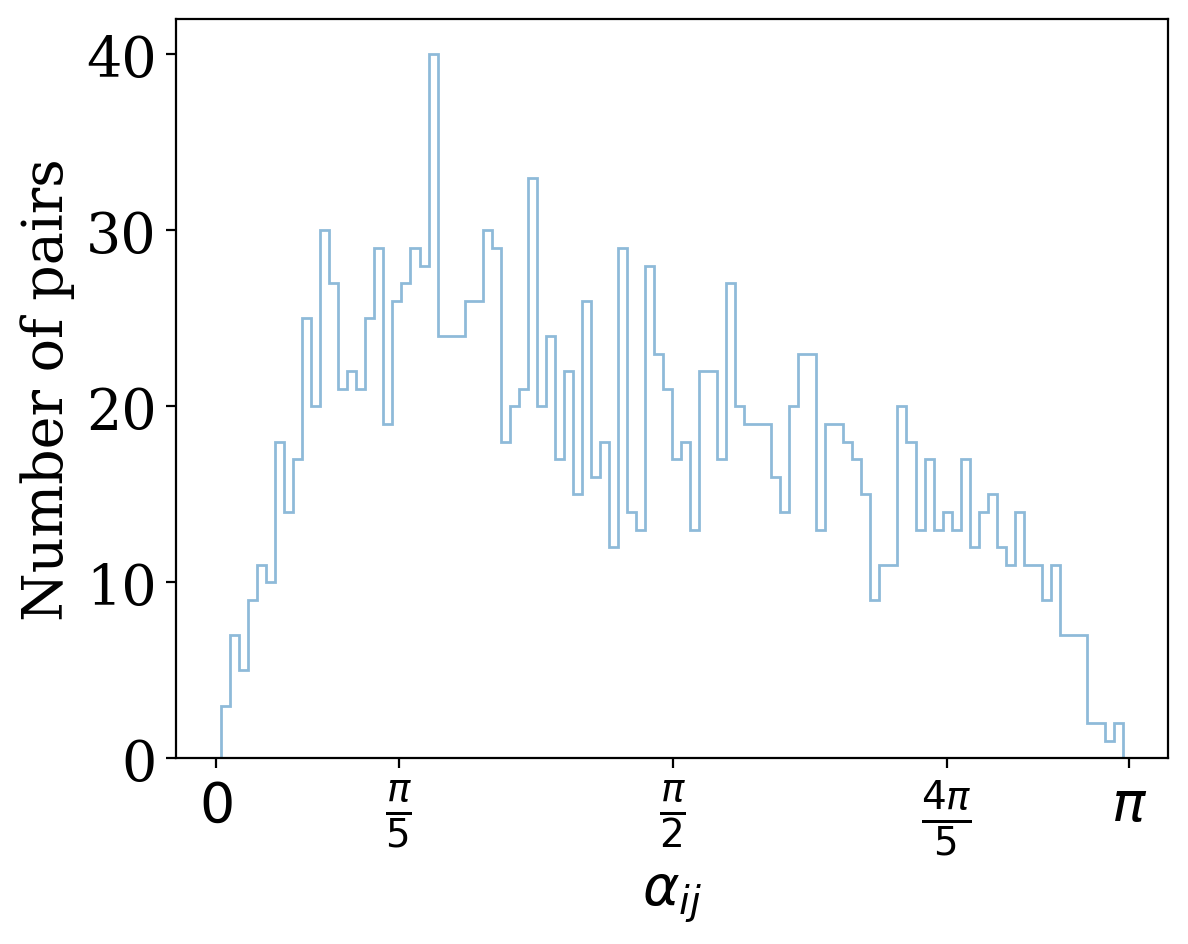

In [12]:
# angular separation between pulsars in radians in a histogram

from matplotlib.ticker import MultipleLocator, FuncFormatter

def custom_pi_formatter(x, pos):
    if x == 0:
        return '0'
    elif x == np.pi / 5:
        return r'$\frac{\pi}{5}$'
    elif x == np.pi / 2:
        return r'$\frac{\pi}{2}$'
    elif x == 4 * np.pi / 5:
        return r'$\frac{4\pi}{5}$'
    elif x == np.pi:
        return r'$\pi$'
    else:
        return ''


# Definire i tick personalizzati
custom_ticks = [0, np.pi / 5, np.pi / 2, 4 * np.pi / 5, np.pi]


plt.hist(alpha_ij, bins=100, histtype='step', alpha=0.5)
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel('Number of pairs')

#plt.title('Angular separation between pulsars')
plt.xticks(custom_ticks, [r'$0$', r'$\frac{\pi}{5}$', r'$\frac{\pi}{2}$', r'$\frac{4\pi}{5}$', r'$\pi$'])
plt.show()

In [7]:
# hellings  downs curve

def hellings_downs(alpha):
    return 0.5 + (3*(1- np.cos(alpha))/4 * (np.log(0.5*(1-np.cos(alpha)))- 1/6))

def hellings_downs_breathing(alpha):
    return (3 + np.cos(alpha)) / 8

alpha = np.linspace(0.01, np.pi, 100)
hd = hellings_downs(alpha)
hd_breathing = hellings_downs_breathing(alpha)

In [8]:
# find the index corresponding to a frequency of 1e-8
f = np.logspace(-9, -7, 100)
f_index = np.argmin(np.abs(f - 1e-8))
gamma_ij_t_10_8 = gamma_ij_t[:,f_index]
gamma_ij_v_10_8 = gamma_ij_v[:,f_index]
gamma_ij_s_10_8 = gamma_ij_s[:,f_index]


In [13]:
print("Number of pairs:", len(alpha_ij))

Number of pairs: 1770


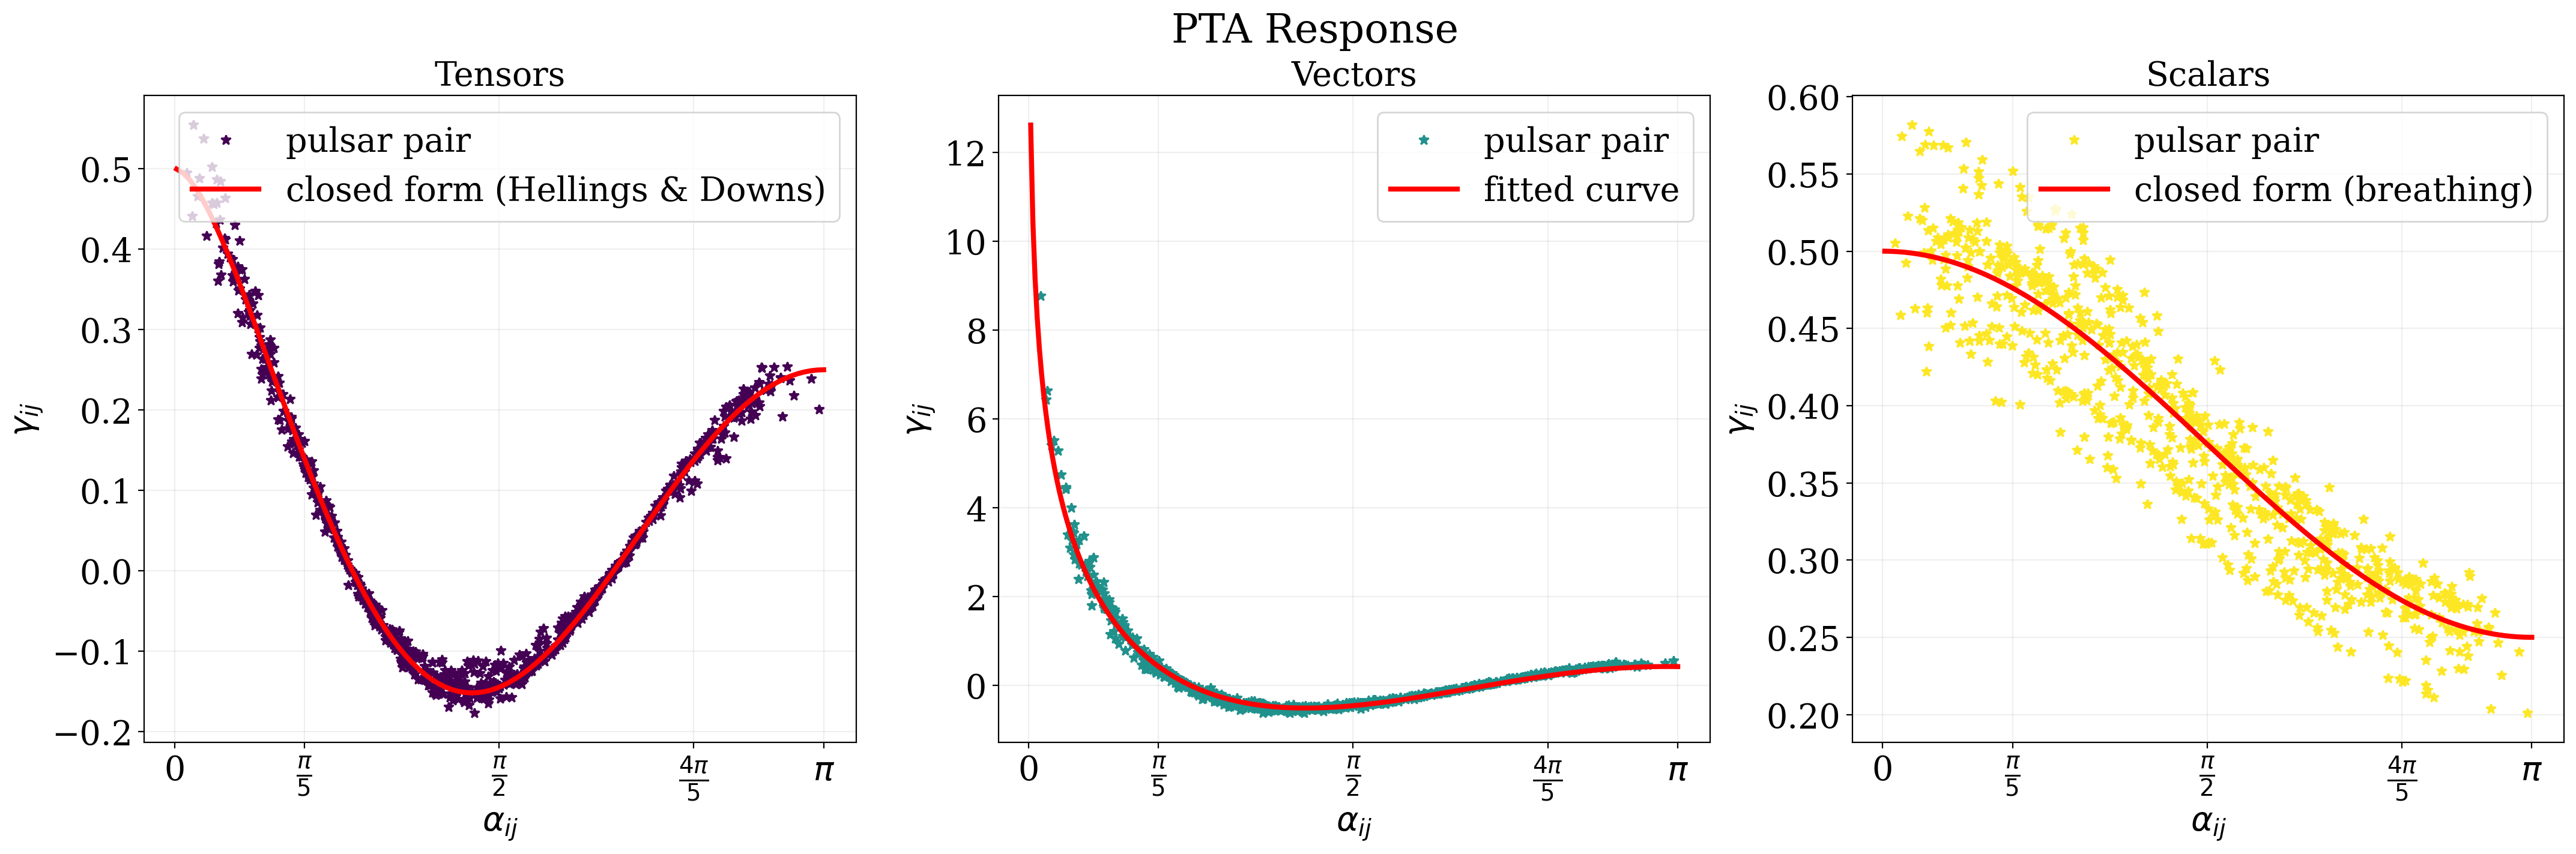

In [20]:
colors = cm.viridis(np.linspace(0, 1, 3))

def model_exp_cos(alpha, A, B, C, D, E):
    return A * np.log(B * alpha) + C * np.cos(D * alpha + E )
alpha_fit = np.linspace(0, np.pi, 300)
gamma_fit_easy = model_exp_cos(alpha_fit, -np.pi, 0.674, -3, 0.813, 2/10)


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator, FuncFormatter

def custom_pi_formatter(x, pos):
    if x == 0:
        return '0'
    elif x == np.pi / 5:
        return r'$\frac{\pi}{5}$'
    elif x == np.pi / 2:
        return r'$\frac{\pi}{2}$'
    elif x == 4 * np.pi / 5:
        return r'$\frac{4\pi}{5}$'
    elif x == np.pi:
        return r'$\pi$'
    else:
        return ''

fig, ax = plt.subplots(1, 3, figsize=(26, 7))

# Definire i tick personalizzati
custom_ticks = [0, np.pi / 5, np.pi / 2, 4 * np.pi / 5, np.pi]

# Plot per Tensors
ax[0].plot(alpha_ij, gamma_ij_t_10_8, '*', color=colors[0], label='pulsar pair')
ax[0].plot(alpha, hd, '-', color='red', label='closed form (Hellings & Downs)')
ax[0].set_xlabel(r'$\alpha_{ij}$')
ax[0].set_ylabel(r'$\gamma_{ij}$')
ax[0].grid(which='both', alpha=0.2)
ax[0].set_title('Tensors')
ax[0].set_xticks(custom_ticks)
ax[0].legend()
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(custom_pi_formatter))

# Plot per Vectors
ax[1].plot(alpha_ij, gamma_ij_v_10_8, '*', color=colors[1], label='pulsar pair')
ax[1].plot(alpha_fit, gamma_fit_easy, '-', color='red', label='fitted curve')
ax[1].set_xlabel(r'$\alpha_{ij}$')
ax[1].set_ylabel(r'$\gamma_{ij}$')
ax[1].grid(which='both', alpha=0.2)
ax[1].set_title('Vectors')
ax[1].set_xticks(custom_ticks)
ax[1].legend()
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(custom_pi_formatter))

# Plot per Scalars
ax[2].plot(alpha_ij, gamma_ij_s_10_8, '*', color=colors[2], label='pulsar pair')
ax[2].plot(alpha, hd_breathing, '-', color='red', label='closed form (breathing)')
ax[2].set_xlabel(r'$\alpha_{ij}$')
ax[2].set_ylabel(r'$\gamma_{ij}$')
ax[2].grid(which='both', alpha=0.2)
ax[2].legend()
ax[2].set_title('Scalars')
ax[2].set_xticks(custom_ticks)
ax[2].xaxis.set_major_formatter(plt.FuncFormatter(custom_pi_formatter))

# definisci un titolo globale
fig.suptitle('PTA Response')

plt.show()

$\gamma_{ij}^{\ell}$ as a function of the angular separation between pulsars

In [16]:
gamma1_ij_t = []
gamma1_ij_v = []
gamma1_ij_s = []
ell = 1
psi = 0

for i in range(N):
    for j in range(i+1, N):
        # Rotazione per la coppia (i, j)
        p_a = pulsar_xyz[i]
        p_b = pulsar_xyz[j]

        # Step 1: porta p_a su z
        z_hat = np.array([0, 0, 1])
        v = np.cross(p_a, z_hat)
        if np.linalg.norm(v) < 1e-8:
            R1 = np.eye(3)
        else:
            theta = np.arccos(np.clip(np.dot(p_a, z_hat), -1, 1))
            R1 = rodrigues_rotation_matrix(v, theta)

        rotated1 = pulsar_xyz @ R1.T
        p_b_rot1 = p_b @ R1.T

        # Step 2: porta p_b nel piano xz
        phi = np.arctan2(p_b_rot1[1], p_b_rot1[0])
        R2 = np.array([
            [np.cos(-phi), -np.sin(-phi), 0],
            [np.sin(-phi),  np.cos(-phi), 0],
            [0,             0,            1]
        ])

        rotated_coords = rotated1 @ R2.T  # shape (N, 3)

        # Coord. di i e j nel frame ruotato
        pi_rot = rotated_coords[i]
        pj_rot = rotated_coords[j]

        # Calcola angolo tra le due pulsar nel frame originale
        gamma1_ij_t.append(AngularResponse.R_ell_pairwise(ell, pi_rot, pj_rot, d[i], d[j], f, 't', psi))
        gamma1_ij_v.append(AngularResponse.R_ell_pairwise(ell, pi_rot, pj_rot, d[i], d[j], f, 'v', psi))
        gamma1_ij_s.append(AngularResponse.R_ell_pairwise(ell, pi_rot, pj_rot, d[i], d[j], f, 's', psi))

gamma1_ij_t = np.array(gamma1_ij_t)
gamma1_ij_v = np.array(gamma1_ij_v)
gamma1_ij_s = np.array(gamma1_ij_s)

In [17]:
print(gamma1_ij_t.shape)
alpha_ij = np.array(alpha_ij)
print(alpha_ij.shape)

(1770, 100)
(1770,)


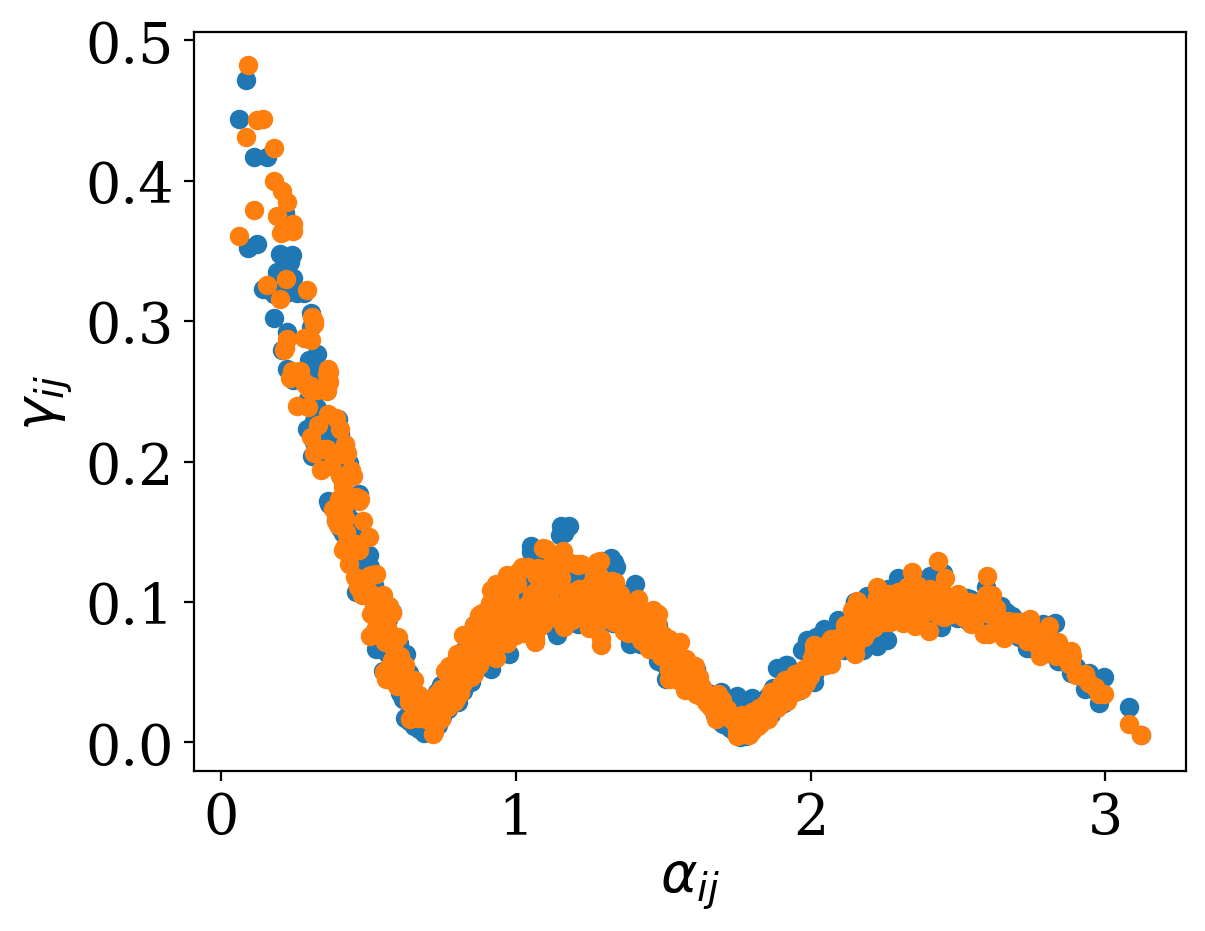

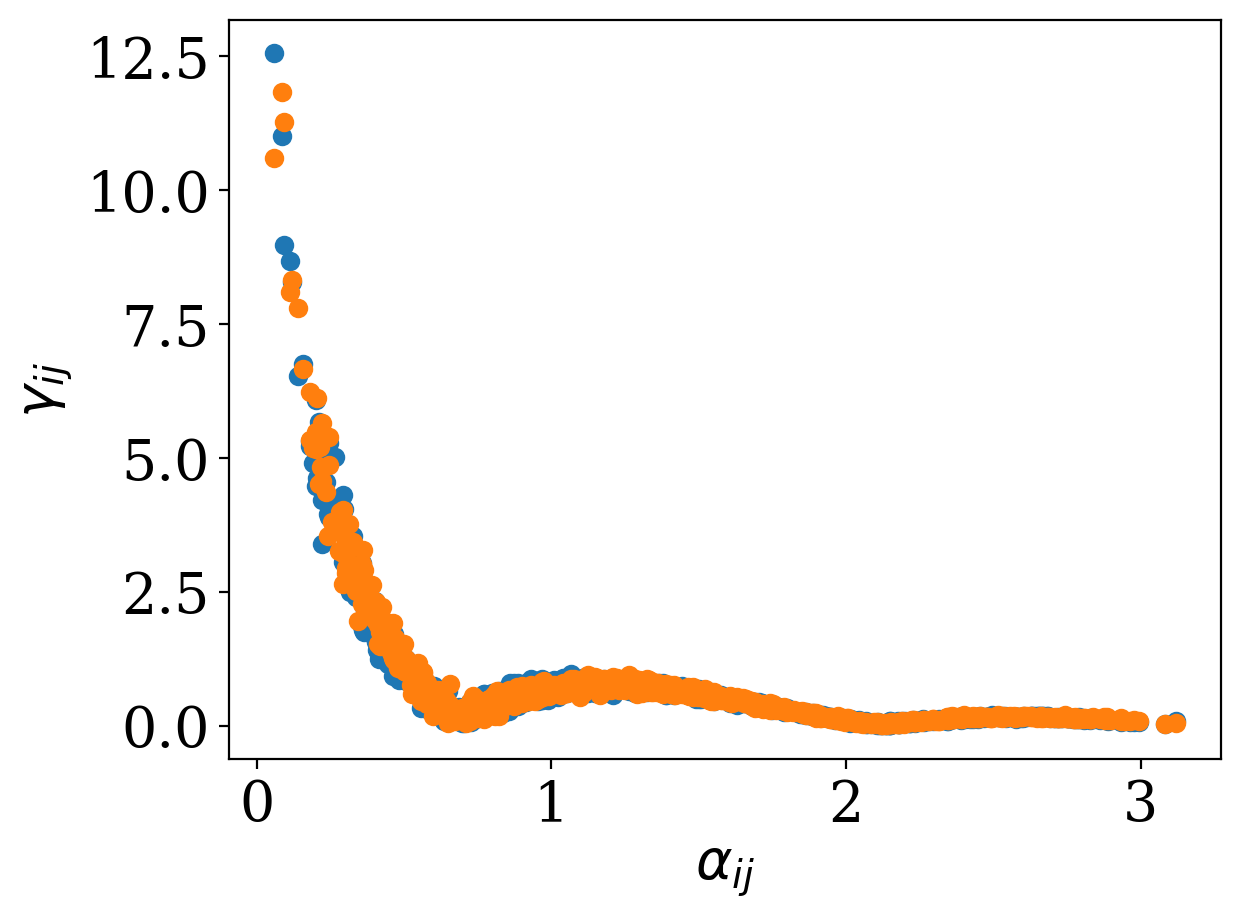

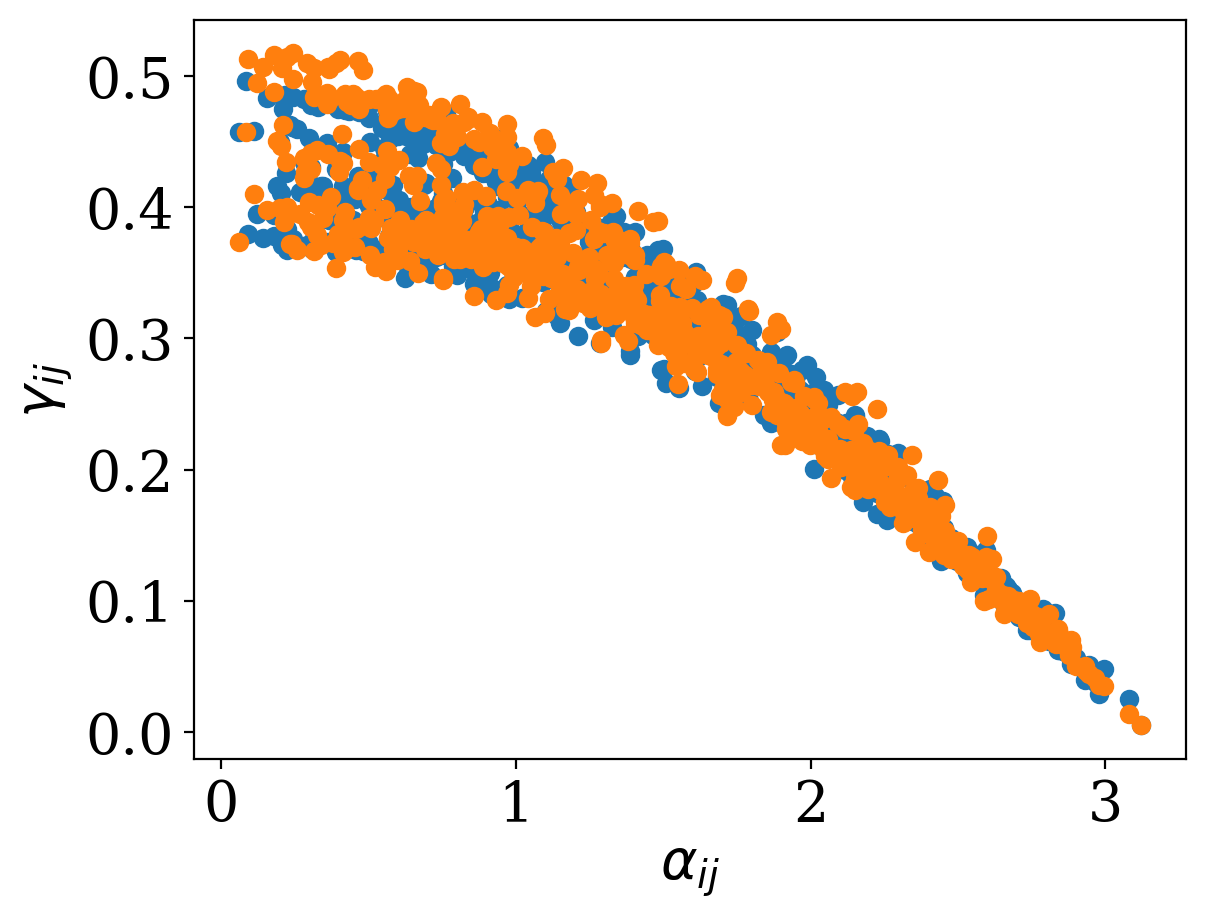

In [18]:
plt.plot(alpha_ij, gamma1_ij_t[:,0], 'o')
plt.plot(alpha_ij, gamma1_ij_t[:,-1], 'o')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.show()
plt.plot(alpha_ij, gamma1_ij_v[:,0], 'o')
plt.plot(alpha_ij, gamma1_ij_v[:,-1], 'o')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.show()
plt.plot(alpha_ij, gamma1_ij_s[:,0], 'o')
plt.plot(alpha_ij, gamma1_ij_s[:,-1], 'o')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.show()

In [21]:
gamma2_ij_t = []
gamma2_ij_v = []
gamma2_ij_s = []

ell = 2
psi = 0

for i in range(N):
    for j in range(i+1, N):
        # Rotazione per la coppia (i, j)
        p_a = pulsar_xyz[i]
        p_b = pulsar_xyz[j]

        # Step 1: porta p_a su z
        z_hat = np.array([0, 0, 1])
        v = np.cross(p_a, z_hat)
        if np.linalg.norm(v) < 1e-8:
            R1 = np.eye(3)
        else:
            theta = np.arccos(np.clip(np.dot(p_a, z_hat), -1, 1))
            R1 = rodrigues_rotation_matrix(v, theta)

        rotated1 = pulsar_xyz @ R1.T
        p_b_rot1 = p_b @ R1.T

        # Step 2: porta p_b nel piano xz
        phi = np.arctan2(p_b_rot1[1], p_b_rot1[0])
        R2 = np.array([
            [np.cos(-phi), -np.sin(-phi), 0],
            [np.sin(-phi),  np.cos(-phi), 0],
            [0,             0,            1]
        ])

        rotated_coords = rotated1 @ R2.T  # shape (N, 3)

        # Coord. di i e j nel frame ruotato
        pi_rot = rotated_coords[i]
        pj_rot = rotated_coords[j]

        gamma2_ij_t.append(AngularResponse.R_ell_pairwise(ell, pi_rot, pj_rot,  d[i], d[j], f, 't', psi))
        gamma2_ij_v.append(AngularResponse.R_ell_pairwise(ell, pi_rot, pj_rot,  d[i], d[j],f, 'v', psi))
        gamma2_ij_s.append(AngularResponse.R_ell_pairwise(ell, pi_rot, pj_rot,  d[i], d[j],f, 's', psi))

gamma2_ij_t = np.array(gamma2_ij_t)
gamma2_ij_v = np.array(gamma2_ij_v)
gamma2_ij_s = np.array(gamma2_ij_s)

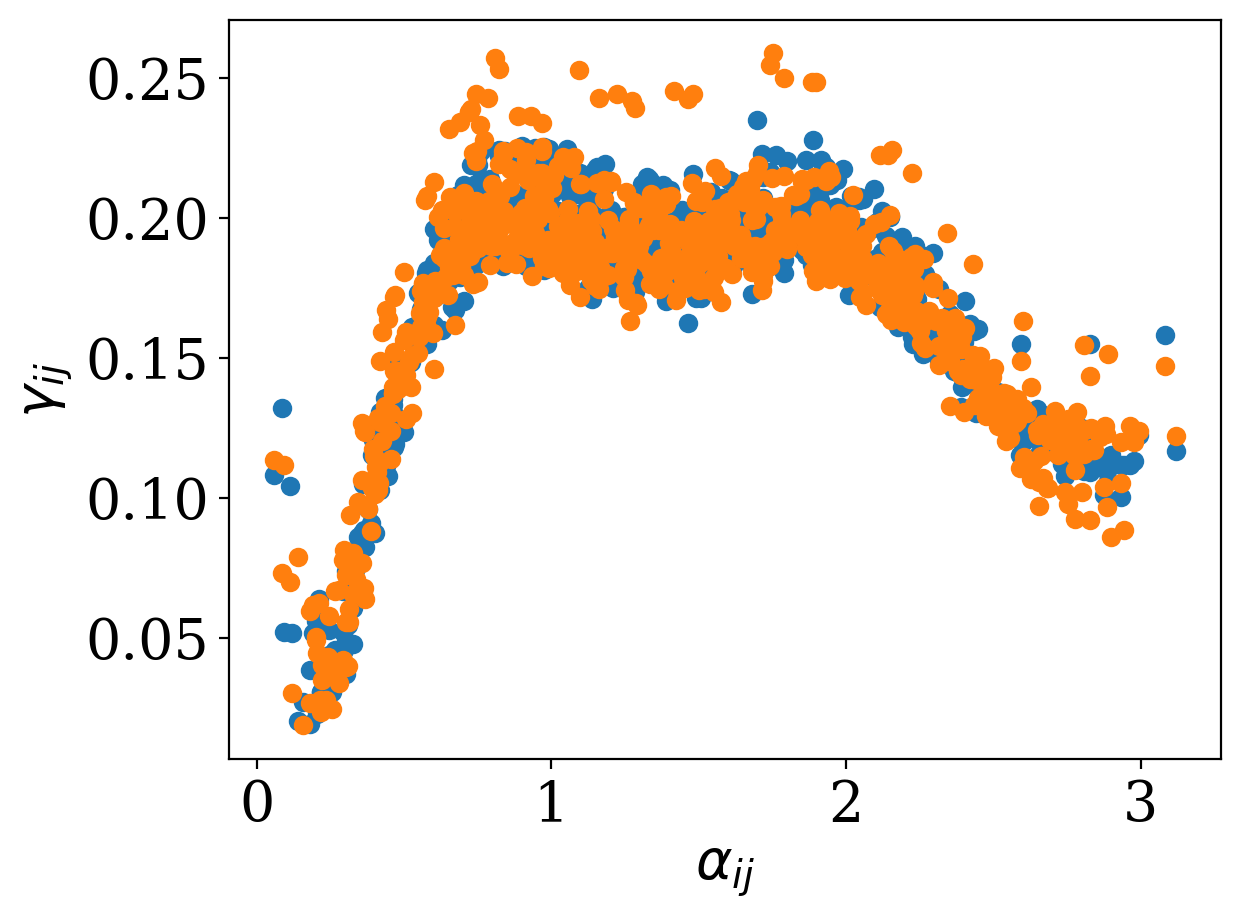

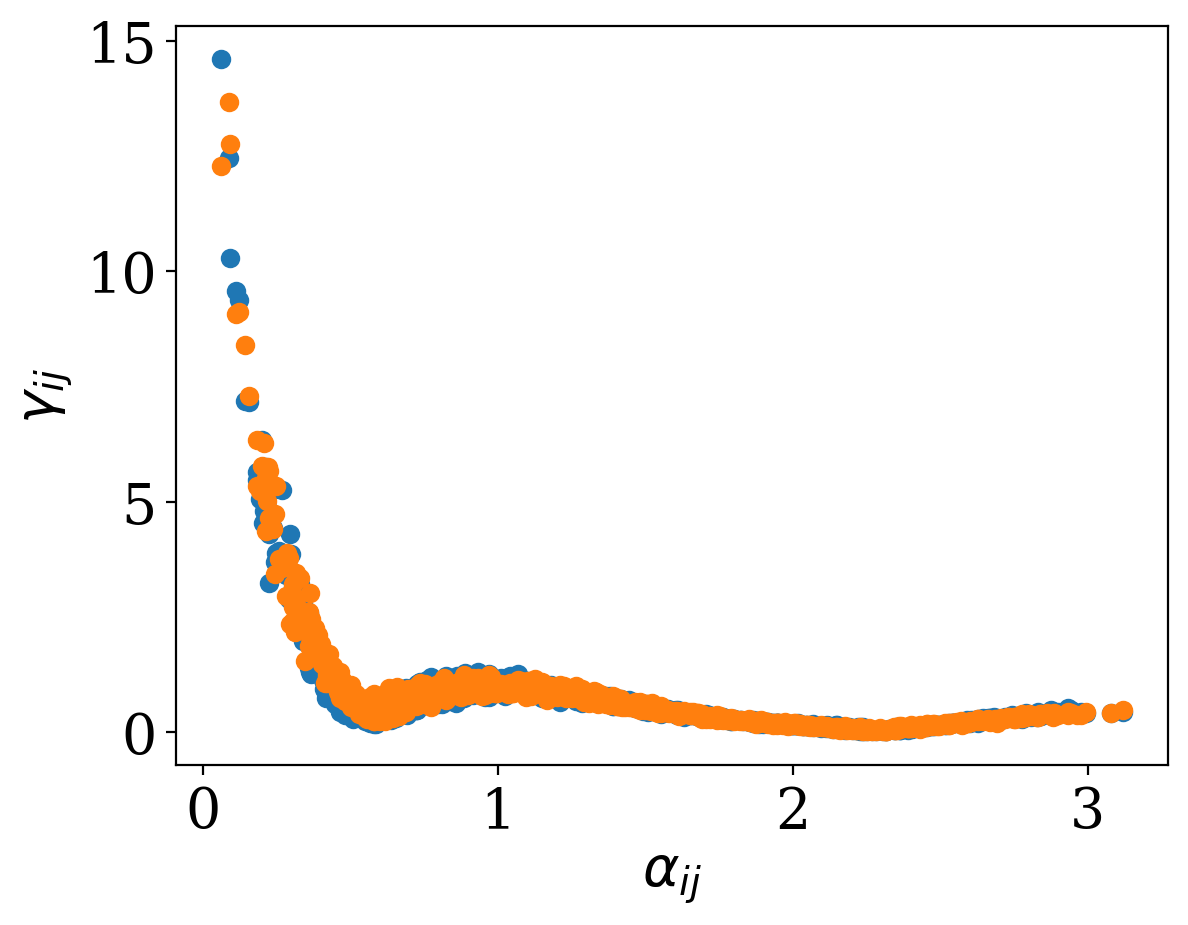

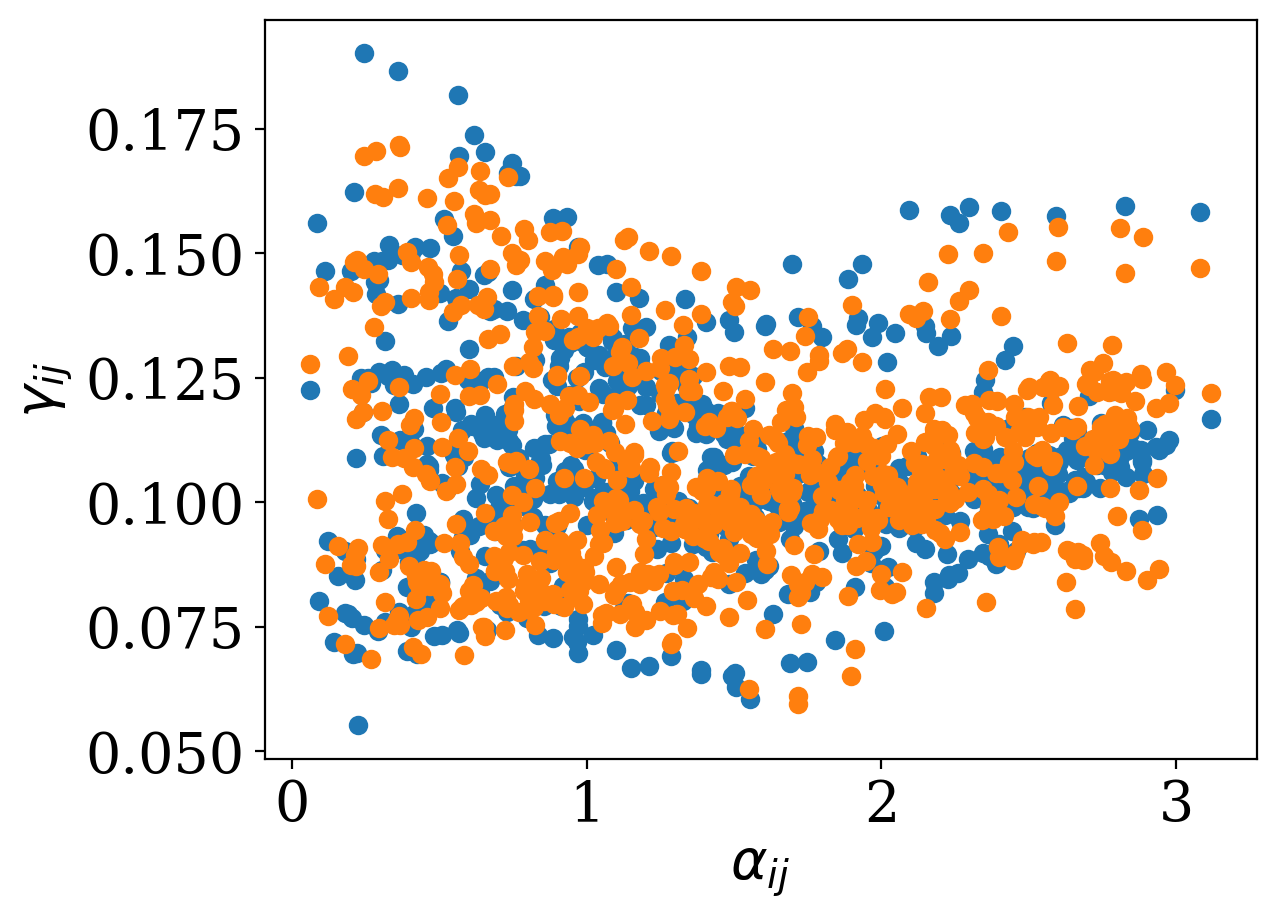

In [22]:

plt.plot(alpha_ij, gamma2_ij_t[:,0], 'o')
plt.plot(alpha_ij, gamma2_ij_t[:,-1], 'o')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.show()
plt.plot(alpha_ij, gamma2_ij_v[:,0], 'o')
plt.plot(alpha_ij, gamma2_ij_v[:,-1], 'o')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.show()
plt.plot(alpha_ij, gamma2_ij_s[:,0], 'o')
plt.plot(alpha_ij, gamma2_ij_s[:,-1], 'o')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.show()

In [23]:
gamma3_ij_t = []
gamma3_ij_v = []
gamma3_ij_s = []

ell = 3
psi = 0

for i in range(N):
    for j in range(i+1, N):
        # Rotazione per la coppia (i, j)
        p_a = pulsar_xyz[i]
        p_b = pulsar_xyz[j]

        # Step 1: porta p_a su z
        z_hat = np.array([0, 0, 1])
        v = np.cross(p_a, z_hat)
        if np.linalg.norm(v) < 1e-8:
            R1 = np.eye(3)
        else:
            theta = np.arccos(np.clip(np.dot(p_a, z_hat), -1, 1))
            R1 = rodrigues_rotation_matrix(v, theta)

        rotated1 = pulsar_xyz @ R1.T
        p_b_rot1 = p_b @ R1.T

        # Step 2: porta p_b nel piano xz
        phi = np.arctan2(p_b_rot1[1], p_b_rot1[0])
        R2 = np.array([
            [np.cos(-phi), -np.sin(-phi), 0],
            [np.sin(-phi),  np.cos(-phi), 0],
            [0,             0,            1]
        ])

        rotated_coords = rotated1 @ R2.T  # shape (N, 3)

        # Coord. di i e j nel frame ruotato
        pi_rot = rotated_coords[i]
        pj_rot = rotated_coords[j]

        gamma3_ij_t.append(AngularResponse.R_ell_pairwise(ell, pi_rot, pj_rot, d[i], d[j], f, 't', psi))
        gamma3_ij_v.append(AngularResponse.R_ell_pairwise(ell, pi_rot, pj_rot, d[i], d[j],f, 'v', psi))
        gamma3_ij_s.append(AngularResponse.R_ell_pairwise(ell, pi_rot, pj_rot, d[i], d[j],f, 's', psi))


gamma3_ij_t = np.array(gamma3_ij_t)
gamma3_ij_v = np.array(gamma3_ij_v)
gamma3_ij_s = np.array(gamma3_ij_s)

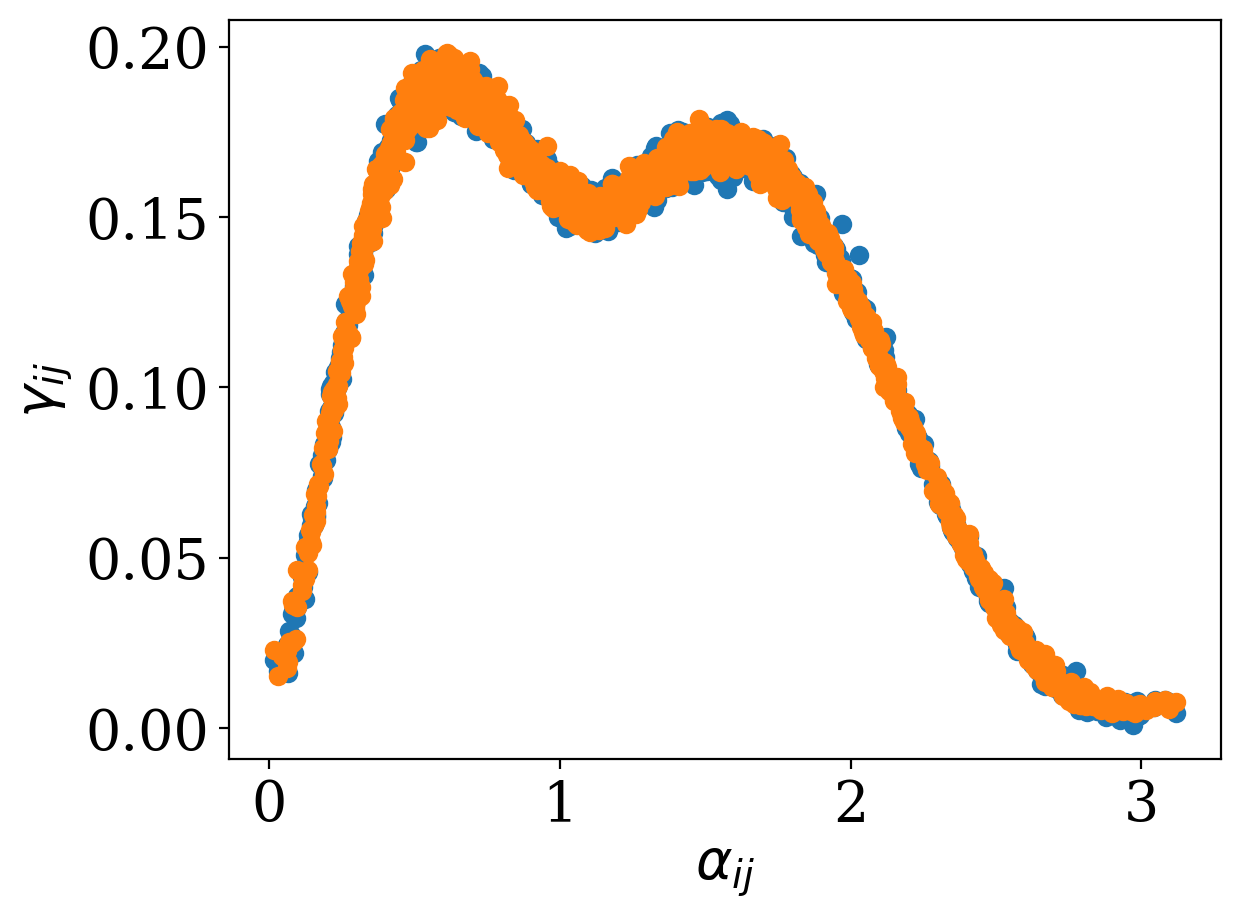

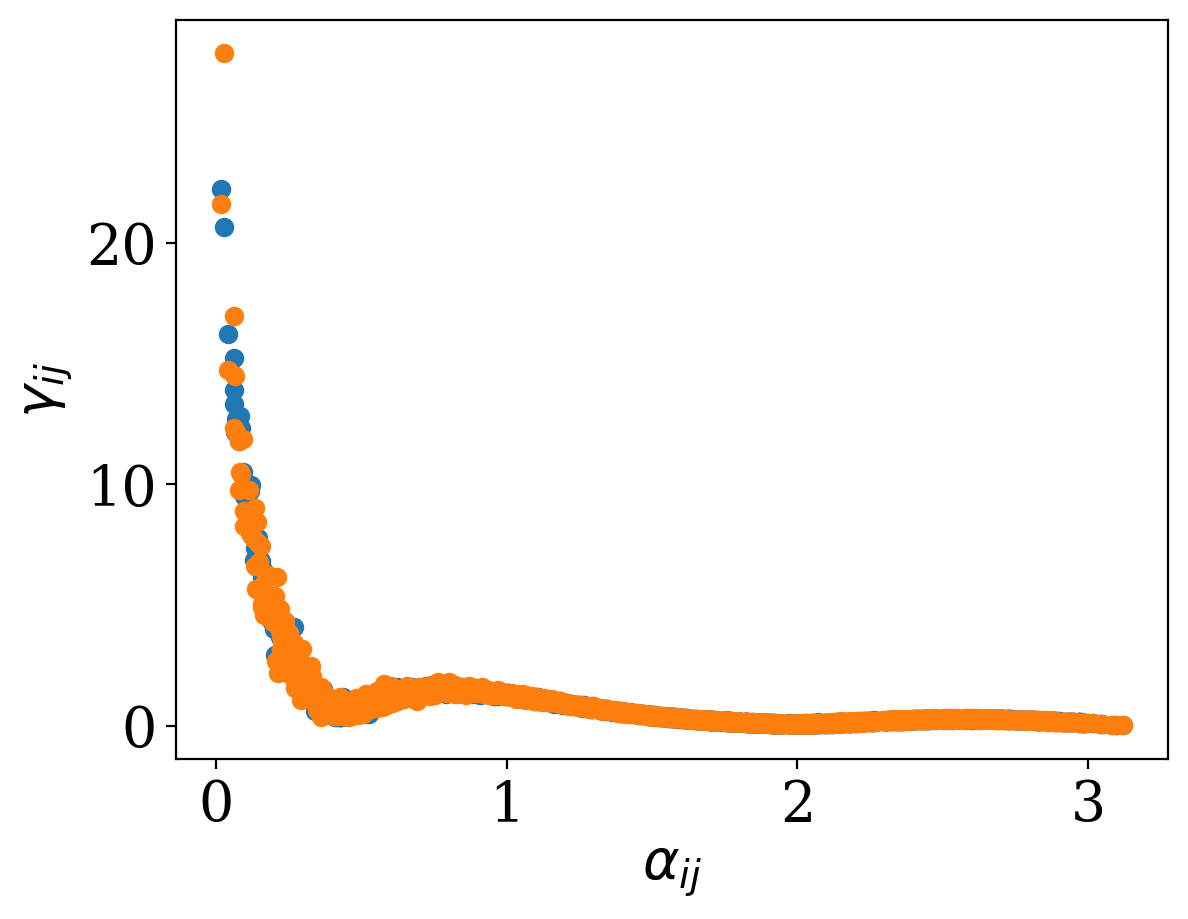

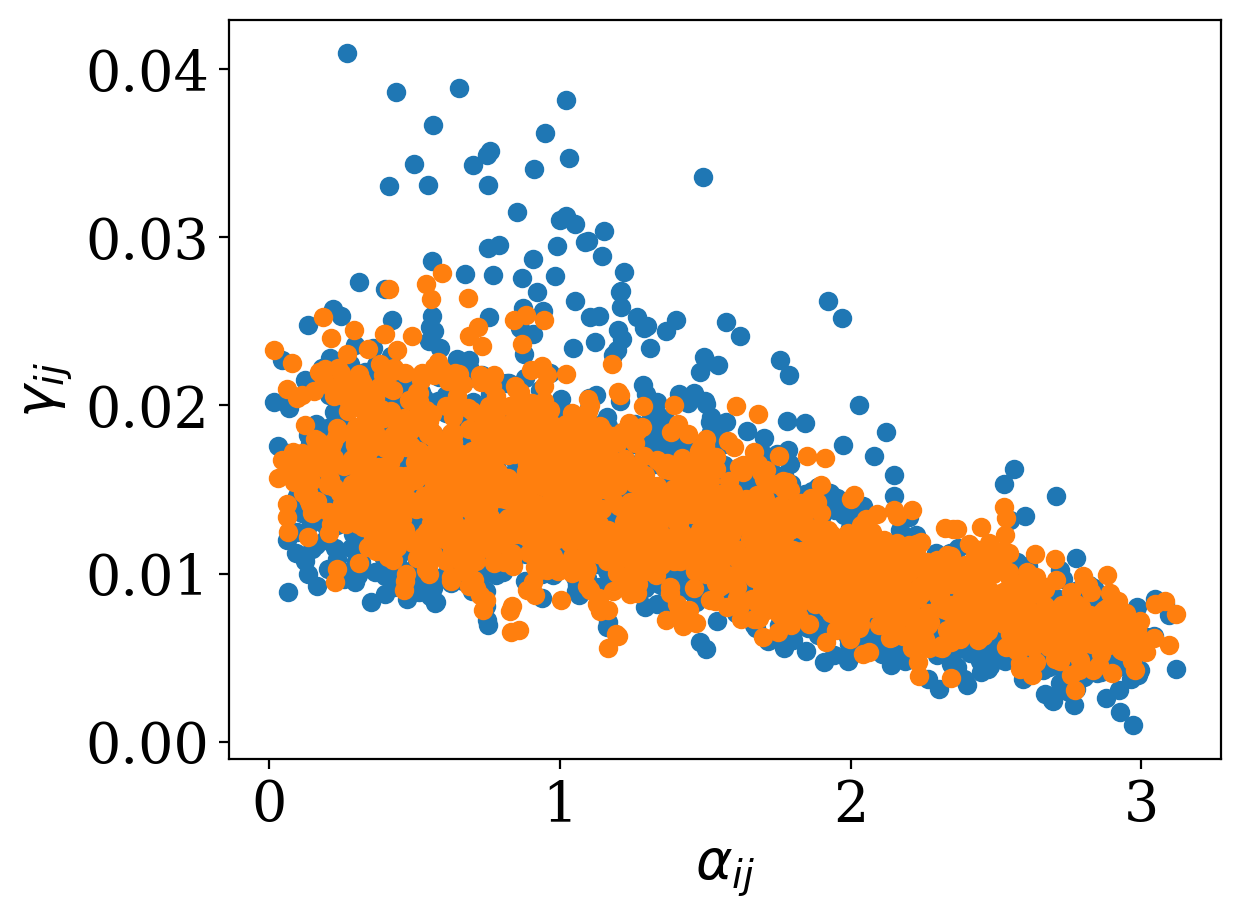

In [18]:
gamma3_ij_t = np.array(gamma3_ij_t)
gamma3_ij_v = np.array(gamma3_ij_v)
gamma3_ij_s = np.array(gamma3_ij_s)
alpha_ij = np.array(alpha_ij)

plt.plot(alpha_ij, gamma3_ij_t[:,0], 'o')
plt.plot(alpha_ij, gamma3_ij_t[:,-1], 'o')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.show()
plt.plot(alpha_ij, gamma3_ij_v[:,0], 'o')
plt.plot(alpha_ij, gamma3_ij_v[:,-1], 'o')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.show()
plt.plot(alpha_ij, gamma3_ij_s[:,0], 'o')
plt.plot(alpha_ij, gamma3_ij_s[:,-1], 'o')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.show()

In [19]:
colors = cm.viridis(np.linspace(0, 1, 4))


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator, FuncFormatter

def custom_pi_formatter(x, pos):
    if x == 0:
        return '0'
    elif x == np.pi / 5:
        return r'$\frac{\pi}{5}$'
    elif x == np.pi / 2:
        return r'$\frac{\pi}{2}$'
    elif x == 4 * np.pi / 5:
        return r'$\frac{4\pi}{5}$'
    elif x == np.pi:
        return r'$\pi$'
    else:
        return ''



# Definire i tick personalizzati
custom_ticks = [0, np.pi / 5, np.pi / 2, 4 * np.pi / 5, np.pi]

f_index = np.argmin(np.abs(f - 1e-8))
print(f_index)
gamma_ij_t_f_index = gamma_ij_t[:,f_index]
gamma_ij_v_f_index = gamma_ij_v[:,f_index]
gamma_ij_s_f_index = gamma_ij_s[:,f_index]
gamma1_ij_t_f_index = gamma1_ij_t[:,f_index]
gamma1_ij_v_f_index = gamma1_ij_v[:,f_index]
gamma1_ij_s_f_index = gamma1_ij_s[:,f_index]
gamma2_ij_t_f_index = gamma2_ij_t[:,f_index]
gamma2_ij_v_f_index = gamma2_ij_v[:,f_index]
gamma2_ij_s_f_index = gamma2_ij_s[:,f_index]
gamma3_ij_t_f_index = gamma3_ij_t[:,f_index]
gamma3_ij_v_f_index = gamma3_ij_v[:,f_index]
gamma3_ij_s_f_index = gamma3_ij_s[:,f_index]

49


In [20]:
# https://arxiv.org/pdf/1306.5394

def R_1_1(alpha):
    term1 = -0.5* np.sqrt(np.pi/6)*np.sin(alpha)
    term2 =  3*(1-np.cos(alpha))
    term3 = (1 + 4/(1+np.cos(alpha))*np.log(np.sin(alpha/2)))
    return term1 * (1+term2*term3)


def R_11(alpha):
    return  -R_1_1(alpha) 


def R_10(alpha):
    term1 =-0.5 *np.sqrt(np.pi/3)
    term2 = 1+ np.cos(alpha)
    term3= 3 * (1-np.cos(alpha))
    term4 = 4*np.log(np.sin(alpha/2))
    return term1 * (term2 + term3 * (term2 + term4))

def R_1(alpha):
    term1 = R_1_1(alpha)
    term2 = R_11(alpha)
    term3 = R_10(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2)

def R_22(alpha):
    term1 = -0.25 * np.sqrt(5*np.pi/6) * (1-np.cos(alpha))/(1+ cos(alpha))
    term2 = (1+ np.cos(alpha)) *((np.cos(alpha))**2 + 4* np.cos(alpha)-9)
    term3 = -24 * (1-cos(alpha)) * np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)  

def R_21(alpha):
    term1 = 0.25*np.sqrt(2*np.pi/15)*np.sin(alpha)
    term2 = 5*(np.cos(alpha)**2) + 15*np.cos(alpha) -21
    term3 = -60*(1-np.cos(alpha))/(1+np.cos(alpha))*np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def R_20(alpha):
    term1 = np.sqrt(np.pi/5)/3
    term2 = np.cos(alpha) 
    term3 = 15*(1-np.cos(alpha))/4
    term4 = (1+np.cos(alpha))*(np.cos(alpha)+3) + 8*np.log(np.sin(alpha/2))
    return term1*(term2 + term3*term4)

def R_2_2(alpha):
    return - R_22(alpha)

def R_2_1(alpha):
    return - R_21(alpha)

def R_2(alpha):
    term1 = R_2_2(alpha)
    term2 = R_2_1(alpha)
    term3 = R_20(alpha)
    term4 = R_21(alpha)
    term5 = R_22(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2 + term4**2 + term5**2)

alpha = np.linspace(0, np.pi, 100)

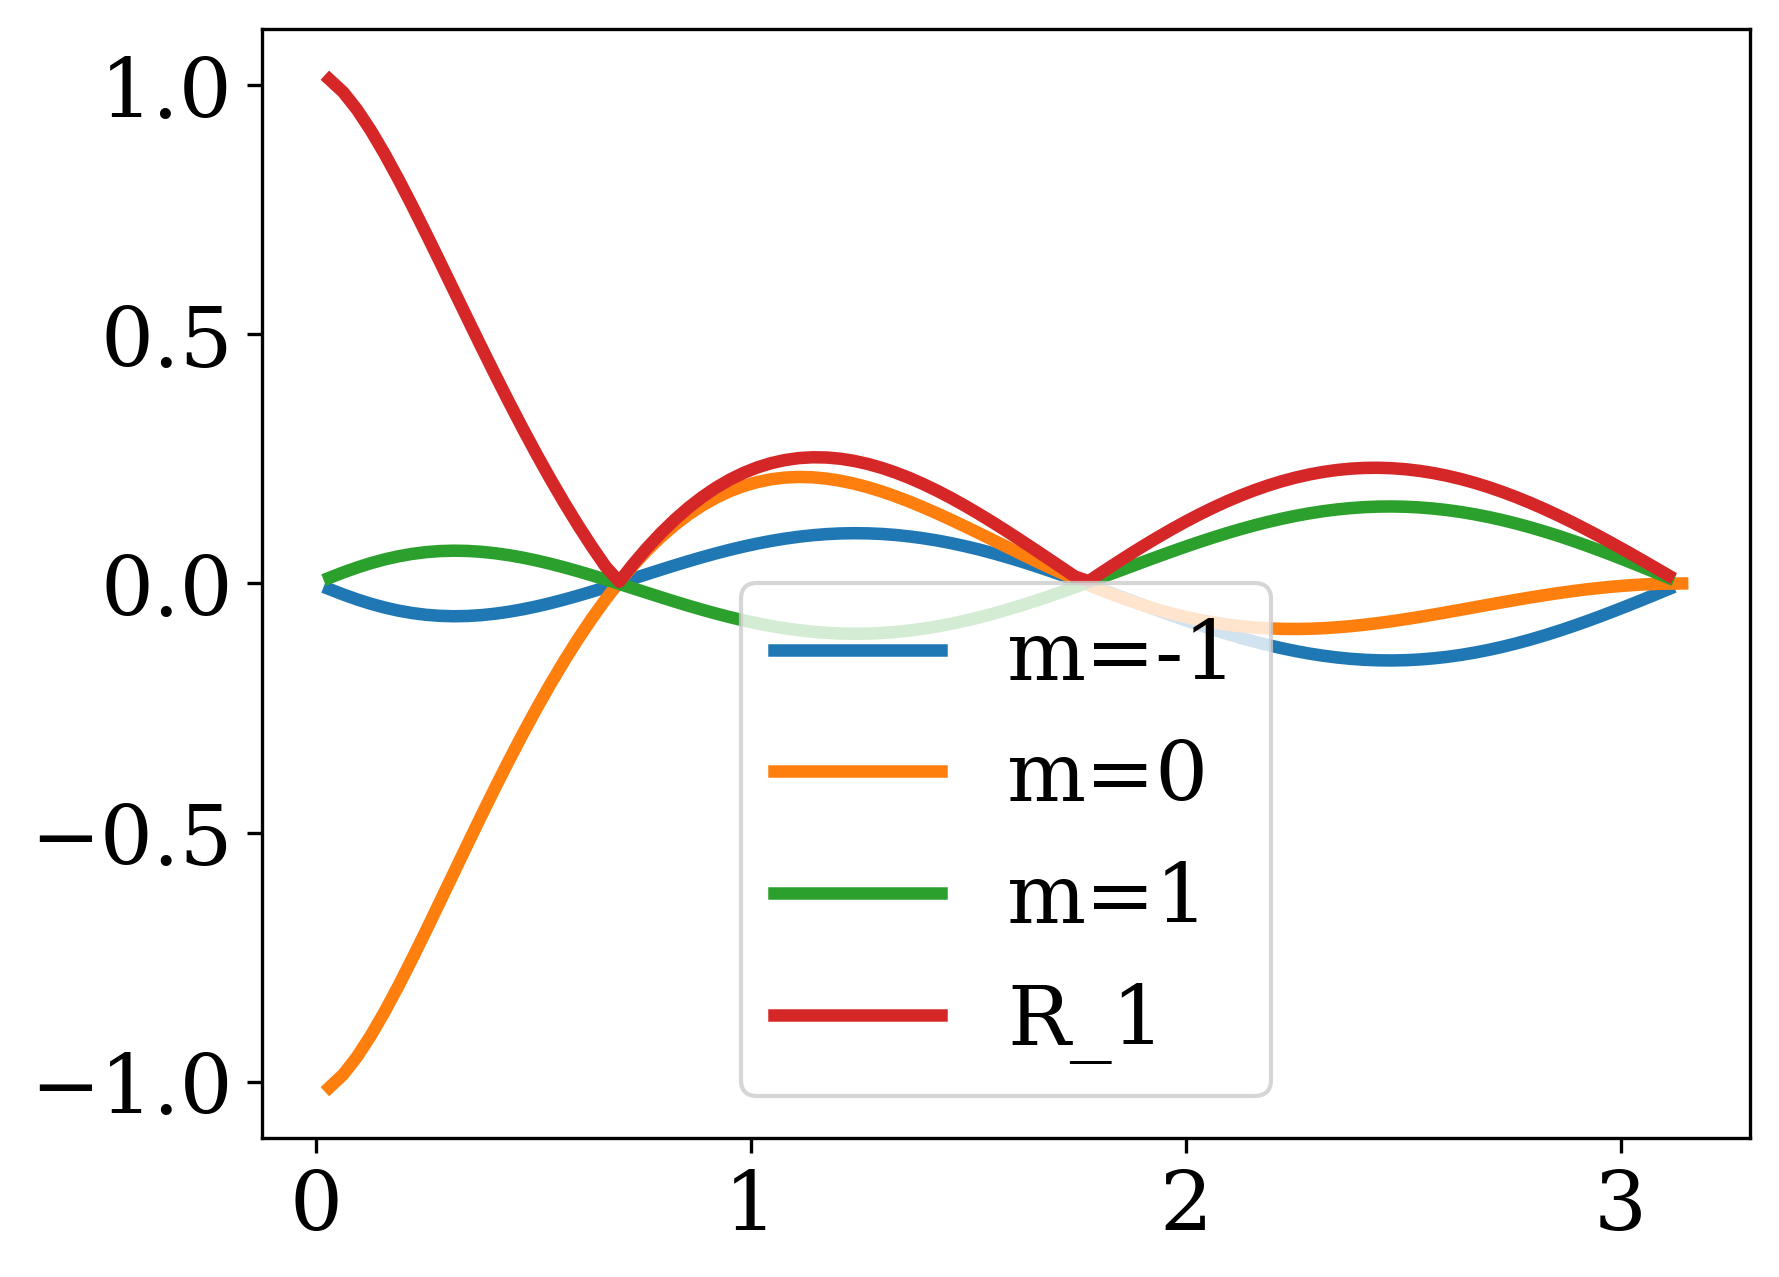

In [ ]:
# R_1 components

alpha= np.linspace(0, np.pi, 100)

plt.plot(alpha,R_1_1(alpha), label='m=-1' )
plt.plot(alpha, R_10(alpha), label='m=0')
plt.plot(alpha, R_11(alpha), label='m=1')
plt.plot(alpha, R_1(alpha), label='R_1')
plt.legend()

In [21]:
# checks with https://journals.aps.org/prd/pdf/10.1103/PhysRevD.93.062003 l = 3 appendix B

def R_3_3(alpha):
    term1 = -np.sqrt(35*np.pi)/48 * (1-np.cos(alpha))**2 /(np.sin(alpha))
    term2 = 34 - 17* np.cos(alpha) - 4*np.cos(alpha)**2 - np.cos(alpha)**3
    ratio = (1-np.cos(alpha))/(1+np.cos(alpha))
    term3 = 96 * ratio * np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def R_3_2(alpha):
    term1 = - np.sqrt(210*np.pi)/48 * (1- np.cos(alpha))
    term2 = 17 - 9*np.cos(alpha) - 3*np.cos(alpha)**2 - np.cos(alpha)**3
    ratio = (1-np.cos(alpha))/(1+np.cos(alpha))
    term3 = 48 * ratio * np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def R_3_1(alpha):
    term1 = - np.sqrt(21*np.pi)/48 * (1- np.cos(alpha)) * np.sin(alpha)
    term2 = 34 +15*np.cos(alpha) + 5*np.cos(alpha)**2
    term3 = 96/(1+np.cos(alpha)) * np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def R_3_0(alpha):
    term1 = -np.sqrt(7*np.pi)/24 * (1-np.cos(alpha))
    term2 = (1+np.cos(alpha) )
    term3 = (17 + 10*np.cos(alpha) + 5*np.cos(alpha)**2 )
    term4 = 48 * np.log(np.sin(alpha/2))
    return term1 * (term2 * term3 + term4)

def R_31(alpha):
    return - R_3_1(alpha)

def R_32(alpha):
    return R_3_2(alpha)

def R_33(alpha):
    return - R_3_3(alpha)

def R_3(alpha):
    term1 = R_3_0(alpha)
    term2 = R_3_1(alpha)
    term3 = R_3_2(alpha)
    term4 = R_3_3(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2 + term4**2)



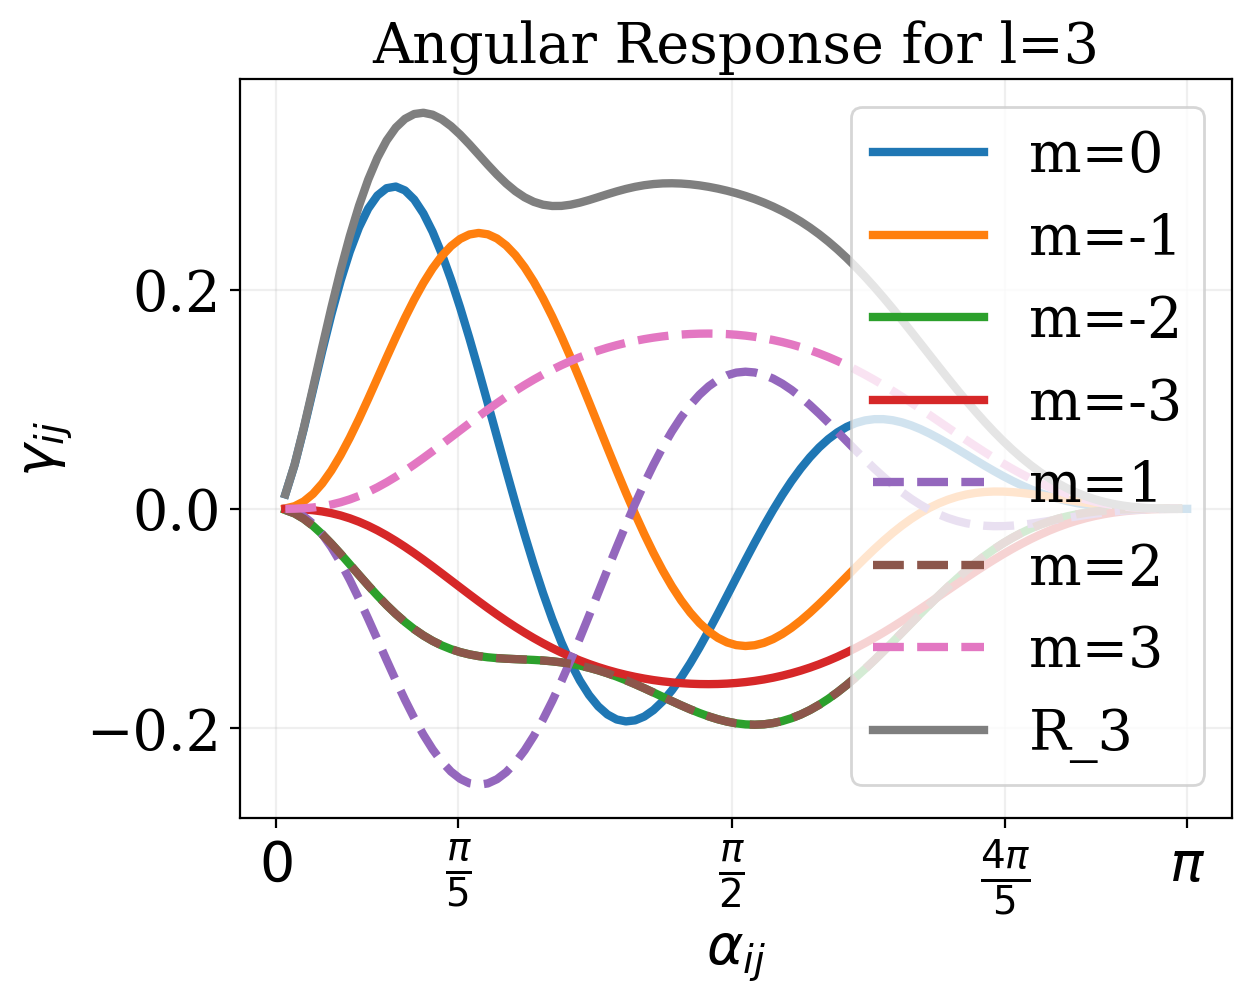

In [22]:
# l = 3

alpha = np.linspace(0, np.pi, 100)
plt.plot(alpha, R_3_0(alpha), label='m=0')
plt.plot(alpha, R_3_1(alpha), label='m=-1')
plt.plot(alpha, R_3_2(alpha), label='m=-2')
plt.plot(alpha, R_3_3(alpha), label='m=-3')
plt.plot(alpha, R_31(alpha), label='m=1', linestyle='dashed')
plt.plot(alpha, R_32(alpha), label='m=2', linestyle='dashed')
plt.plot(alpha, R_33(alpha), label='m=3', linestyle='dashed')
plt.plot(alpha, R_3(alpha), label='R_3')
plt.legend()
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Angular Response for l=3')
plt.grid(which='both', alpha=0.2)
plt.xticks(custom_ticks, [r'$0$', r'$\frac{\pi}{5}$', r'$\frac{\pi}{2}$', r'$\frac{4\pi}{5}$', r'$\pi$'])
#plt.xaxis.set_major_formatter(plt.FuncFormatter(custom_pi_formatter))
plt.show()



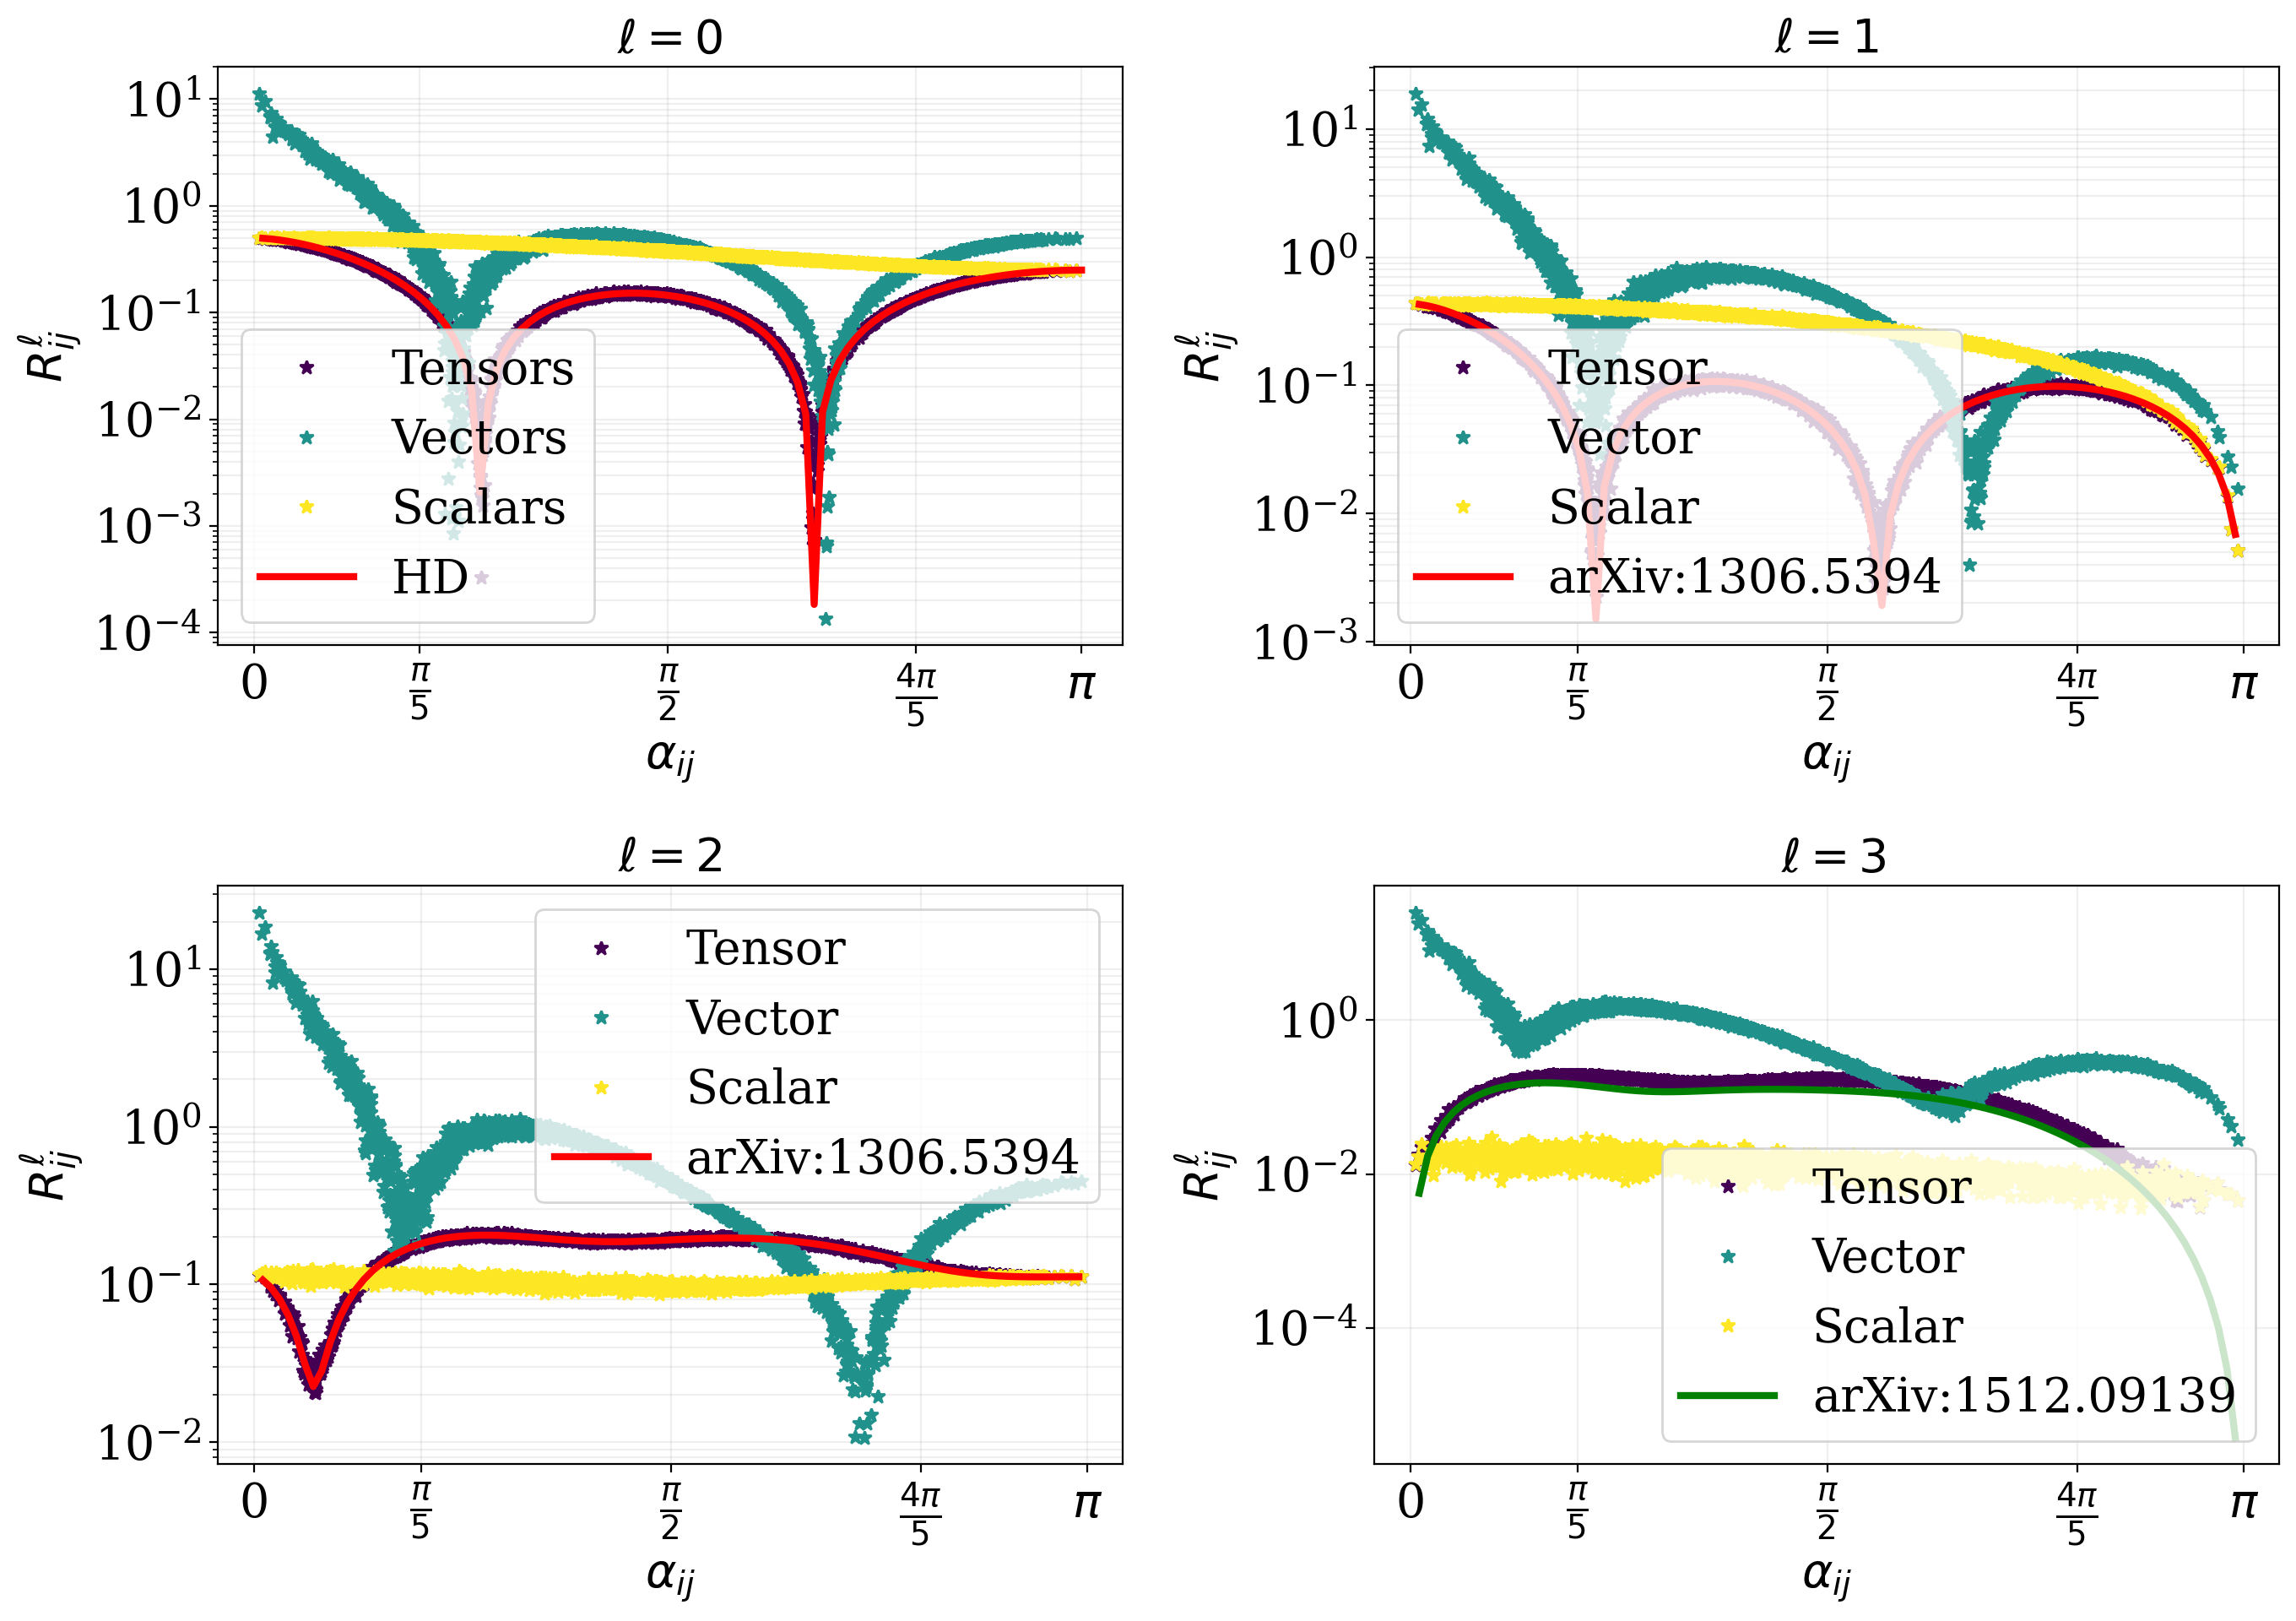

In [23]:
# Funzione per formattare i tick in multipli di π
def custom_pi_formatter(x, pos):
    if x == 0:
        return '0'
    elif x == np.pi / 5:
        return r'$\frac{\pi}{5}$'
    elif x == np.pi / 2:
        return r'$\frac{\pi}{2}$'
    elif x == 4 * np.pi / 5:
        return r'$\frac{4\pi}{5}$'
    elif x == np.pi:
        return r'$\pi$'
    else:
        return ''

# Generare una palette di colori con Viridis
colors = cm.viridis(np.linspace(0, 1, 3))  # 3 colori per Tensors, Vectors, Scalars

# Creazione della figura con 2x2 subplot
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Definizione dei tick personalizzati
custom_ticks = [0, np.pi / 5, np.pi / 2, 4 * np.pi / 5, np.pi]

# Plot per ℓ=0
ax[0, 0].semilogy(alpha_ij, np.abs(gamma_ij_t_f_index), '*', color=colors[0], label='Tensors')
ax[0, 0].semilogy(alpha_ij, np.abs(gamma_ij_v_f_index), '*', color=colors[1], label='Vectors')
ax[0, 0].semilogy(alpha_ij, np.abs(gamma_ij_s_f_index), '*', color=colors[2], label='Scalars')
ax[0, 0].semilogy(alpha, np.abs(hellings_downs(alpha)), color='red', label='HD')
ax[0, 0].set_xlabel(r'$\alpha_{ij}$')
ax[0, 0].set_ylabel(r'$R_{ij}^{\ell}$')
ax[0, 0].grid(which='both', alpha=0.2)
ax[0, 0].set_title(r'$\ell=0$')
ax[0, 0].set_xticks(custom_ticks)
ax[0, 0].legend()
ax[0, 0].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=1
ax[0, 1].semilogy(alpha_ij, gamma1_ij_t_f_index, '*', color=colors[0], label='Tensor')
ax[0, 1].semilogy(alpha_ij, gamma1_ij_v_f_index, '*', color=colors[1], label='Vector')
ax[0, 1].semilogy(alpha_ij, gamma1_ij_s_f_index, '*', color=colors[2], label='Scalar')
ax[0, 1].semilogy(alpha, 3*np.sqrt(4*np.pi)/(8*np.pi)* R_1(alpha), color='red', label='arXiv:1306.5394')
ax[0, 1].set_xlabel(r'$\alpha_{ij}$')
ax[0, 1].set_ylabel(r'$R_{ij}^{\ell}$')
ax[0, 1].grid(which='both', alpha=0.2)
ax[0, 1].set_title(r'$\ell=1$')
ax[0, 1].set_xticks(custom_ticks)
ax[0, 1].legend()
ax[0, 1].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=2
ax[1, 0].semilogy(alpha_ij, gamma2_ij_t_f_index, '*', color=colors[0], label='Tensor')
ax[1, 0].semilogy(alpha_ij, gamma2_ij_v_f_index, '*', color=colors[1], label='Vector')
ax[1, 0].semilogy(alpha_ij, gamma2_ij_s_f_index, '*', color=colors[2], label='Scalar')
ax[1, 0].semilogy(alpha, 3*np.sqrt(4*np.pi)/(8*np.pi)*R_2(alpha), color='red', label='arXiv:1306.5394')
ax[1, 0].set_xlabel(r'$\alpha_{ij}$')
ax[1, 0].set_ylabel(r'$R_{ij}^{\ell}$')
ax[1, 0].grid(which='both', alpha=0.2)
ax[1, 0].set_title(r'$\ell=2$')
ax[1, 0].set_xticks(custom_ticks)
ax[1, 0].legend()
ax[1, 0].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=3
ax[1, 1].semilogy(alpha_ij, gamma3_ij_t_f_index, '*', color=colors[0], label='Tensor')
ax[1, 1].semilogy(alpha_ij, gamma3_ij_v_f_index, '*', color=colors[1], label='Vector')
ax[1, 1].semilogy(alpha_ij, gamma3_ij_s_f_index, '*', color=colors[2], label='Scalar')
ax[1, 1].semilogy(alpha, 3*np.sqrt(4*np.pi)/(8*np.pi)*R_3(alpha), color='green', label='arXiv:1512.09139')
ax[1, 1].set_xlabel(r'$\alpha_{ij}$')
ax[1, 1].set_ylabel(r'$R_{ij}^{\ell}$')
ax[1, 1].grid(which='both', alpha=0.2)
ax[1, 1].set_title(r' $\ell=3$')
ax[1, 1].set_xticks(custom_ticks)
ax[1, 1].legend()
ax[1, 1].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

plt.tight_layout()
plt.show()

# Sensitivity Curves

In [24]:
psi = 0
Tobs_PTA = 15
snr_ = 1

f_PTA = np.logspace(-9, -7, 100)
colors = cm.viridis(np.linspace(0, 1, 3))
pls_NANOGrav_t = pls.APLS_PTA(f_PTA, snr_, Tobs_PTA, 't', psi)
pls_NANOGrav_v = pls.APLS_PTA(f_PTA, snr_, Tobs_PTA, 'v', psi)
pls_NANOGrav_s = pls.APLS_PTA(f_PTA, snr_, Tobs_PTA, 's', psi)
pls_NANOGrav_V = pls.APLS_PTA(f_PTA, snr_, Tobs_PTA, 'V', psi)



2025-05-28 10:57:21.325 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-28 11:02:24.800 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-28 11:07:33.770 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-28 11:12:44.499 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates


Text(0.5, 1.0, 'PTA PLS')

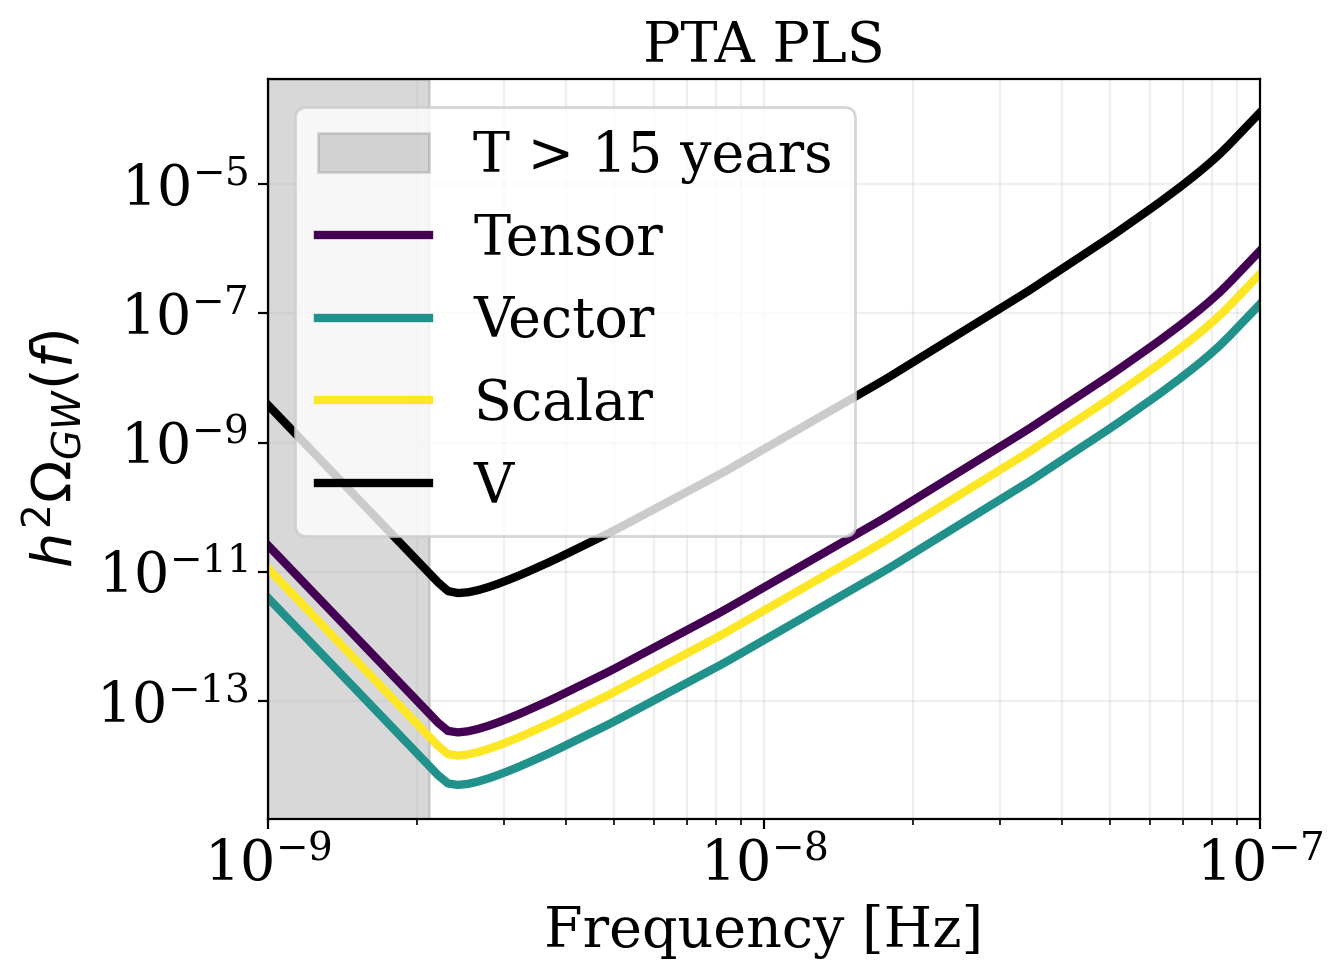

In [25]:
T_15_years = 15 * 365 * 24 * 3600  # in secondi
f_15_years = 1 / T_15_years  # in Hz
plt.axvspan(f_PTA.min(), f_15_years, color='gray', alpha=0.3, label='T > 15 years')

plt.plot(f_PTA, pls_NANOGrav_t, label='Tensor', color=colors[0])
plt.plot(f_PTA, pls_NANOGrav_v, label='Vector', color=colors[1])
plt.plot(f_PTA, pls_NANOGrav_s, label='Scalar', color=colors[2])
plt.plot(f_PTA, pls_NANOGrav_V, label='V', color='black')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both', alpha=0.2)
plt.xlim(f_PTA.min(), f_PTA.max())
plt.legend()
plt.title('PTA PLS')

#beepy.beep(sound=1) 

In [26]:
print(np.min(pls_NANOGrav_t))
print(np.min(pls_NANOGrav_v))
print(np.min(pls_NANOGrav_s))

3.30836793986766e-14
5.090831089208203e-15
1.45008370872803e-14


6.77798365505009e-10
1.0225966903603887e-11
4.785946104159111e-10

1.1631995935335099e-11
1.7177910450965716e-12
5.100814777408018e-12

2025-05-28 11:52:25.476 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-28 11:58:52.600 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-28 12:18:13.073 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-28 12:50:18.843 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates


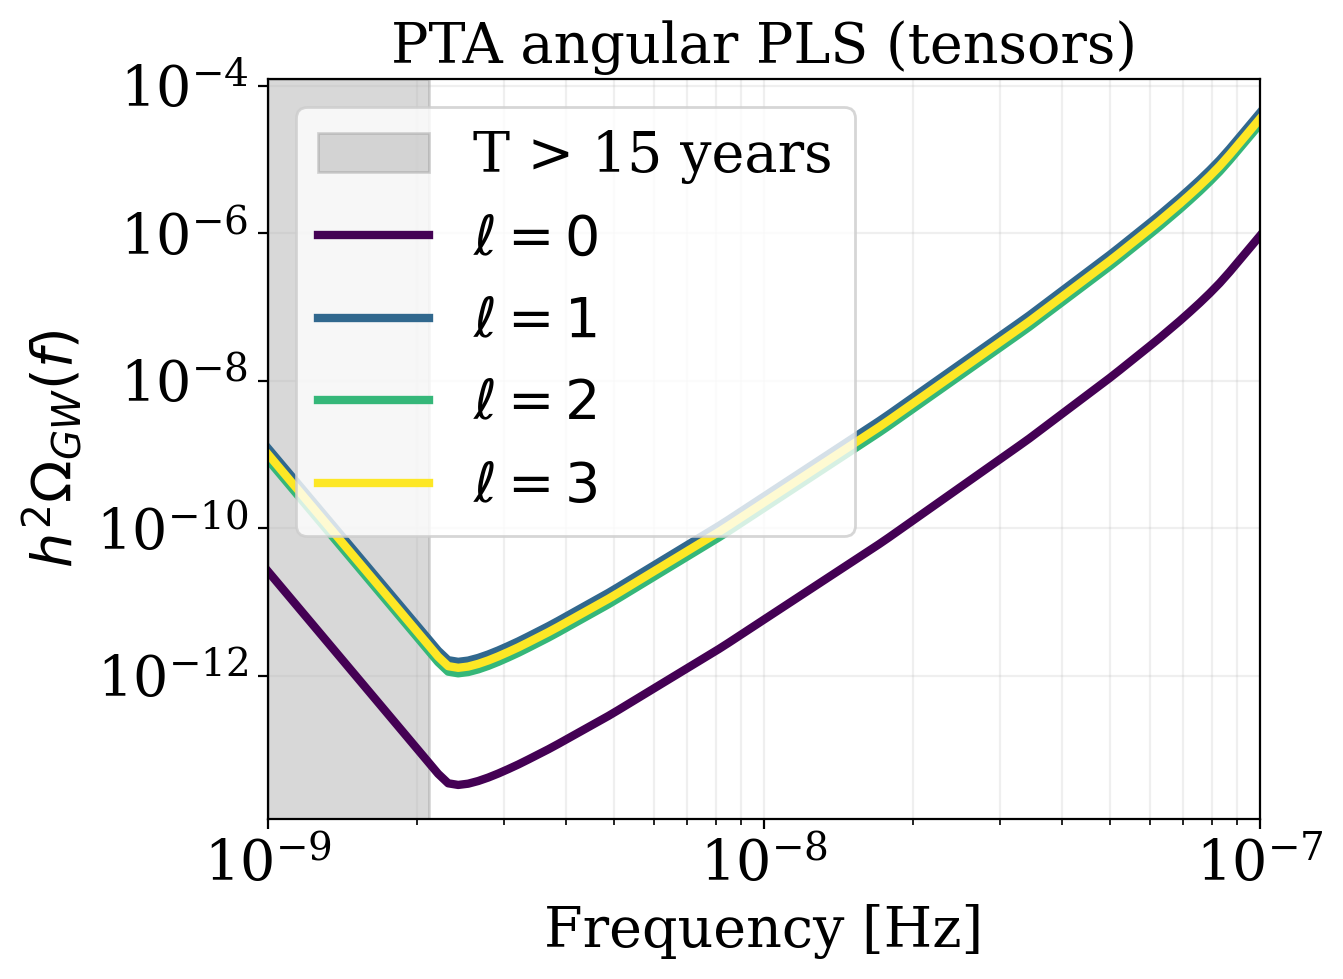

In [27]:
f = np.logspace(-9, -7, 100)
snr = 1
Tobs = 15
psi=0

colors = cm.viridis(np.linspace(0, 1, 4))

#tensors

T_15_years = 15 * 365 * 24 * 3600  # in s
f_15_years = 1 / T_15_years  # in Hz
plt.axvspan(f_PTA.min(), f_15_years, color='gray', alpha=0.3, label='T > 15 years')


pls_NANOGrav_0 = Sensitivity_ell.APLS_ell_PTA(0, f, snr, Tobs, 1, 't', psi)
pls_NANOGrav_1 = Sensitivity_ell.APLS_ell_PTA(1, f, snr, Tobs, 1e-3, 't', psi)
pls_NANOGrav_2 = Sensitivity_ell.APLS_ell_PTA(2, f, snr, Tobs, 1e-3, 't', psi)
pls_NANOGrav_3 = Sensitivity_ell.APLS_ell_PTA(3, f, snr, Tobs, 1e-3, 't', psi)


plt.loglog(f, pls_NANOGrav_0, label=r'$\ell=0$', color=colors[0])
plt.loglog(f, pls_NANOGrav_1, label=r'$\ell=1$', color=colors[1])
plt.loglog(f, pls_NANOGrav_2, label=r'$\ell=2$', color=colors[2])
plt.loglog(f, pls_NANOGrav_3, label=r'$\ell=3$', color=colors[3])

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xlim(f.min(), f.max())
plt.legend()
plt.title('PTA angular PLS (tensors)')
plt.grid(which='both', alpha=0.2)

In [28]:
print(np.min(pls_NANOGrav_0))
print(np.min(pls_NANOGrav_1))
print(np.min(pls_NANOGrav_2))
print(np.min(pls_NANOGrav_3))

3.308001915571606e-14
1.543657340674699e-12
1.0795935569780923e-12
1.2815624011011002e-12


2025-05-28 13:41:51.182 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-28 13:48:24.696 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-28 14:07:30.703 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-28 14:39:51.647 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates


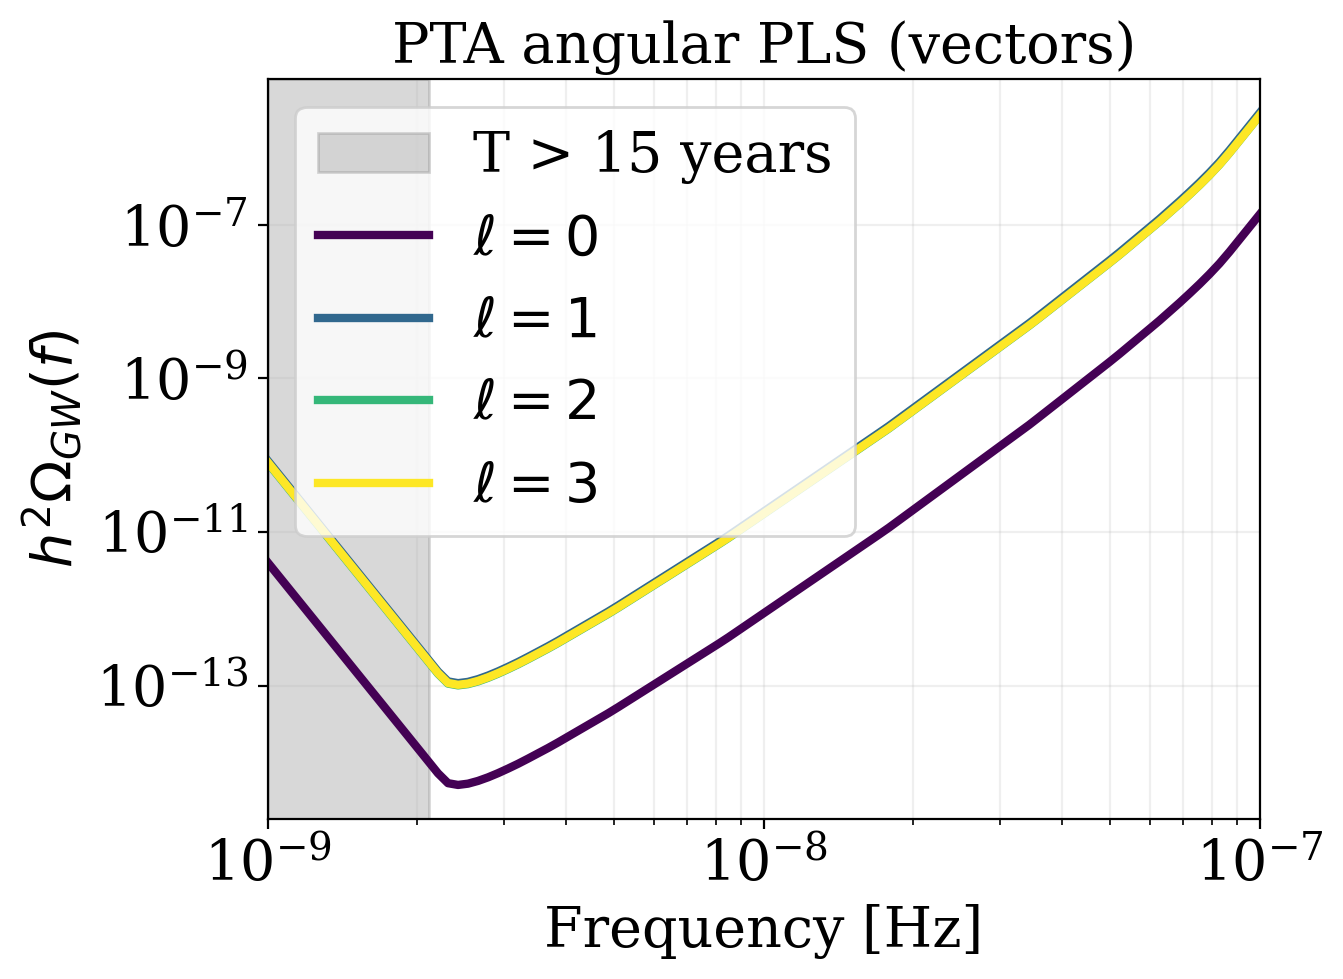

In [29]:
#vectors

pls_NANOGrav_0 = Sensitivity_ell.ALS_ell_PTA(0, f, snr, Tobs, 1, 'v', psi)
pls_NANOGrav_1 = Sensitivity_ell.APLS_ell_PTA(1, f, snr, Tobs, 1e-3, 'v', psi)
pls_NANOGrav_2 = Sensitivity_ell.APLS_ell_PTA(2, f, snr, Tobs, 1e-3, 'v', psi)
pls_NANOGrav_3 = Sensitivity_ell.APLS_ell_PTA(3, f, snr, Tobs, 1e-3, 'v', psi)

T_15_years = 15 * 365 * 24 * 3600  # in s
f_15_years = 1 / T_15_years  # in Hz
plt.axvspan(f_PTA.min(), f_15_years, color='gray', alpha=0.3, label='T > 15 years')



plt.loglog(f, pls_NANOGrav_0, label=r'$\ell=0$', color=colors[0])
plt.loglog(f, pls_NANOGrav_1, label=r'$\ell=1$', color=colors[1])
plt.loglog(f, pls_NANOGrav_2, label=r'$\ell=2$', color=colors[2])
plt.loglog(f, pls_NANOGrav_3, label=r'$\ell=3$', color=colors[3])

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xlim(f.min(), f.max())
plt.legend()
plt.title('PTA angular PLS (vectors)')
plt.grid(which='both', alpha=0.2)

In [ ]:
print(np.min(pls_NANOGrav_0))
print(np.min(pls_NANOGrav_1))
print(np.min(pls_NANOGrav_2))
print(np.min(pls_NANOGrav_3))

4.991905474565919e-15
1.0501351988815486e-13
9.71213438058735e-14
9.726224986627935e-14


2025-05-12 13:52:37.734 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-12 13:54:19.871 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-12 13:59:12.121 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-12 14:07:11.096 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates


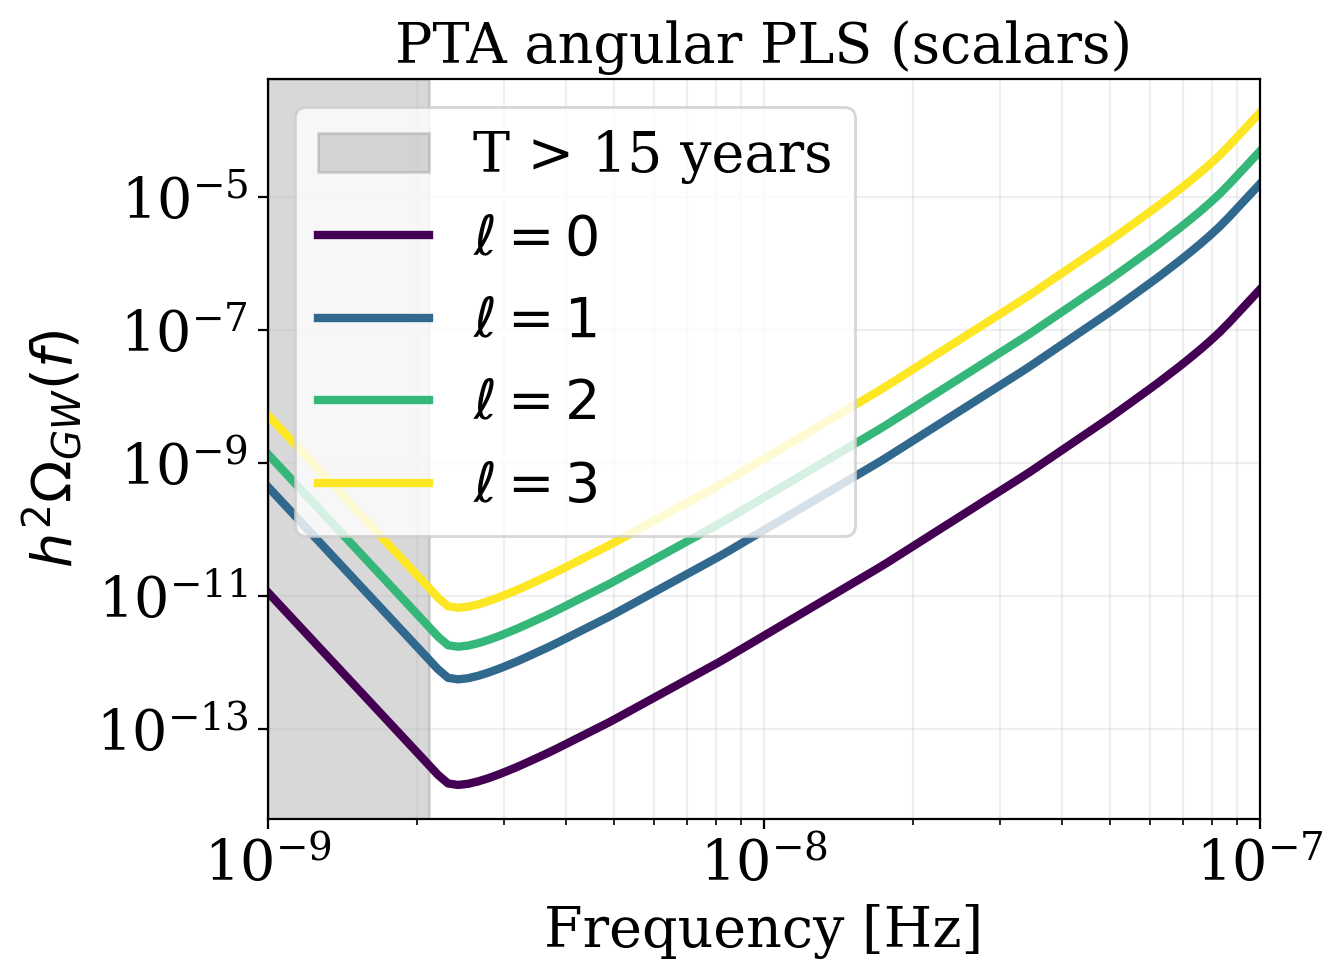

In [ ]:
#scalars

pls_NANOGrav_0 = Sensitivity_ell.APLS_ell_PTA(0, f, snr, Tobs, 1, 's', psi)
pls_NANOGrav_1 = Sensitivity_ell.APLS_ell_PTA(1, f, snr, Tobs, 1e-3, 's', psi)
pls_NANOGrav_2 = Sensitivity_ell.APLS_ell_PTA(2, f, snr, Tobs, 1e-3, 's', psi)
pls_NANOGrav_3 = Sensitivity_ell.APLS_ell_PTA(3, f, snr, Tobs, 1e-3, 's', psi)

T_15_years = 15 * 365 * 24 * 3600  # in s
f_15_years = 1 / T_15_years  # in Hz
plt.axvspan(f_PTA.min(), f_15_years, color='gray', alpha=0.3, label='T > 15 years')

plt.loglog(f, pls_NANOGrav_0, label=r'$\ell=0$', color=colors[0])
plt.loglog(f, pls_NANOGrav_1, label=r'$\ell=1$', color=colors[1])
plt.loglog(f, pls_NANOGrav_2, label=r'$\ell=2$', color=colors[2])
plt.loglog(f, pls_NANOGrav_3, label=r'$\ell=3$', color=colors[3])

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xlim(f.min(), f.max())
plt.legend()
plt.title('PTA angular PLS (scalars)')
plt.grid(which='both', alpha=0.2)

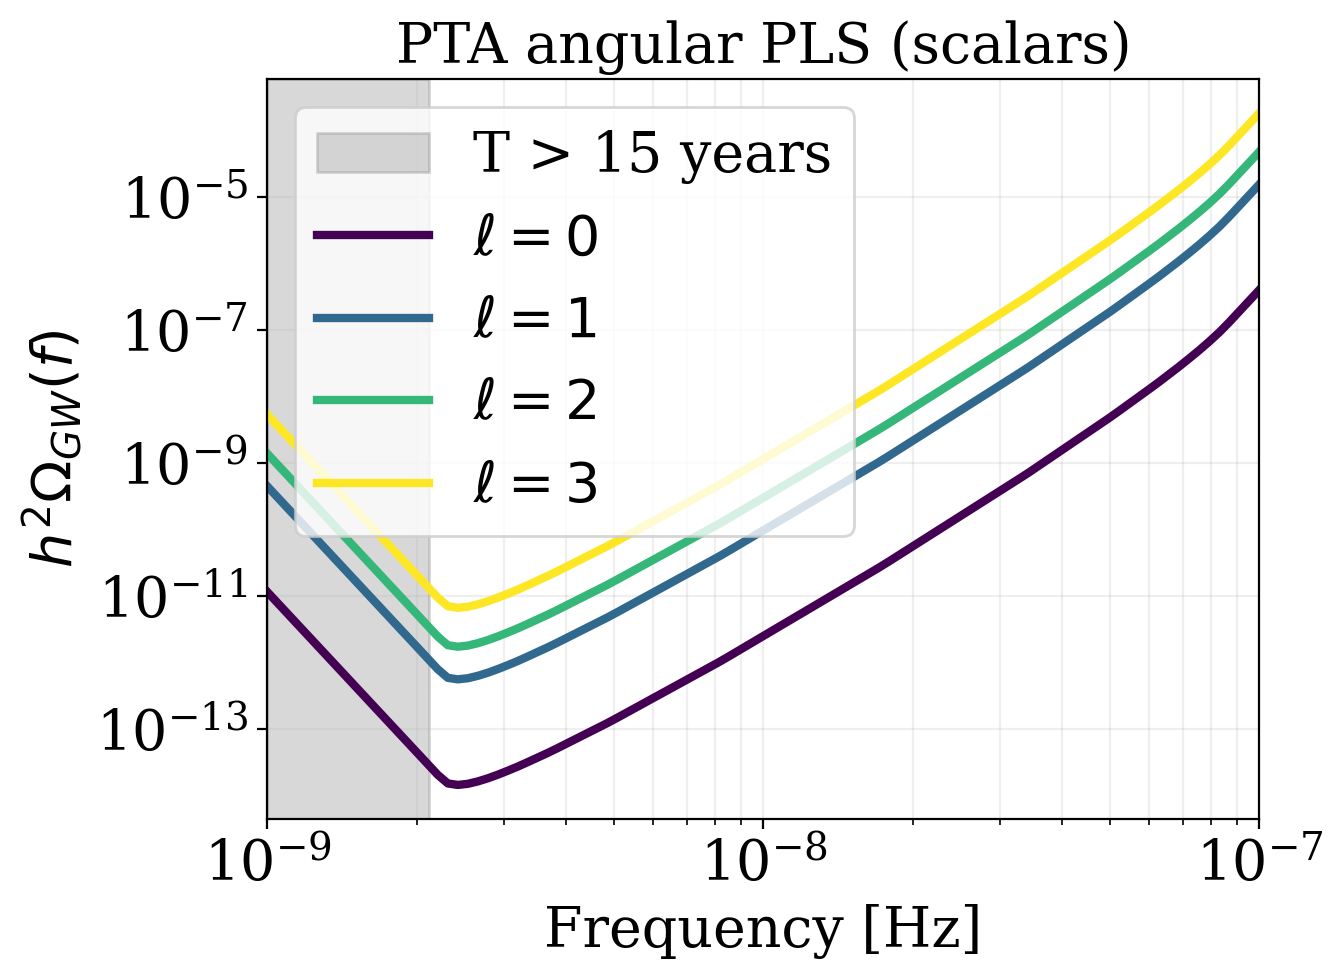

In [ ]:
T_15_years = 15 * 365 * 24 * 3600  # in s
f_15_years = 1 / T_15_years  # in Hz
colors = cm.viridis(np.linspace(0, 1, 4))
plt.axvspan(f_PTA.min(), f_15_years, color='gray', alpha=0.3, label='T > 15 years')

plt.loglog(f, pls_NANOGrav_0, label=r'$\ell=0$', color=colors[0])
plt.loglog(f, pls_NANOGrav_1, label=r'$\ell=1$', color=colors[1])
plt.loglog(f, pls_NANOGrav_2, label=r'$\ell=2$', color=colors[2])
plt.loglog(f, pls_NANOGrav_3, label=r'$\ell=3$', color=colors[3])

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xlim(f.min(), f.max())
plt.legend()
plt.title('PTA angular PLS (scalars)')
plt.grid(which='both', alpha=0.2)

In [ ]:
print(np.min(pls_NANOGrav_0))
print(np.min(pls_NANOGrav_1))
print(np.min(pls_NANOGrav_2))
print(np.min(pls_NANOGrav_3))

1.450870370781445e-14
5.607412761767533e-13
1.7342373108764302e-12
6.6716080994415414e-12


2025-05-12 14:20:01.730 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-12 14:21:41.975 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-12 14:26:31.124 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates
2025-05-12 14:34:28.876 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates


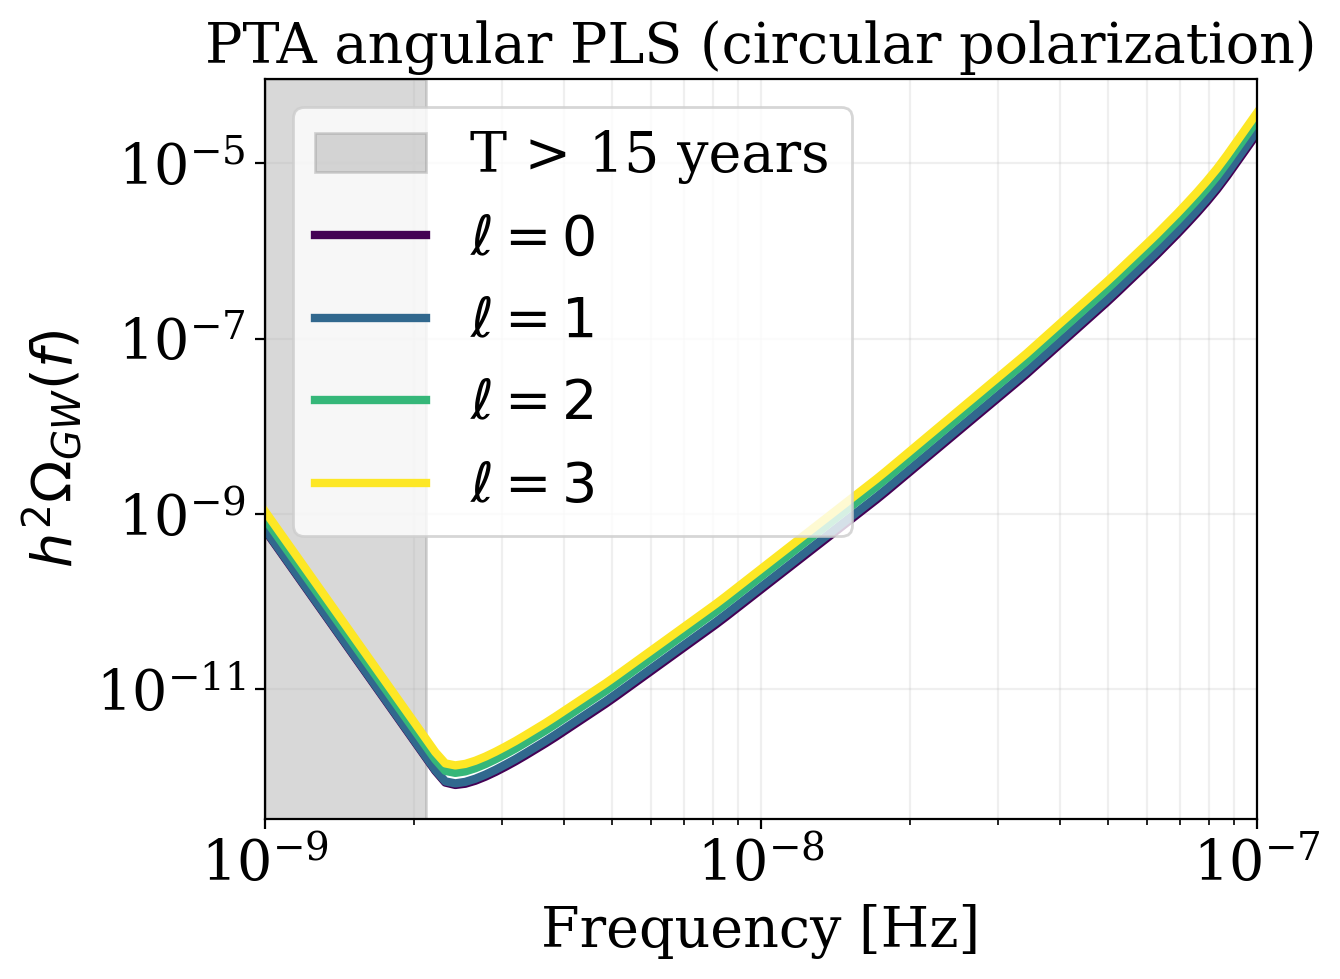

In [ ]:
# circular polarization

pls_NANOGrav_0_V = Sensitivity_ell.APLS_ell_PTA(0, f, snr, Tobs, 1, 'V', psi)
pls_NANOGrav_1_V = Sensitivity_ell.APLS_ell_PTA(1, f, snr, Tobs, 1e-3, 'V', psi)
pls_NANOGrav_2_V = Sensitivity_ell.APLS_ell_PTA(2, f, snr, Tobs, 1e-3, 'V', psi)
pls_NANOGrav_3_V = Sensitivity_ell.APLS_ell_PTA(3, f, snr, Tobs, 1e-3, 'V', psi)

T_15_years = 15 * 365 * 24 * 3600  # in s
f_15_years = 1 / T_15_years  # in Hz
plt.axvspan(f_PTA.min(), f_15_years, color='gray', alpha=0.3, label='T > 15 years')

plt.loglog(f, pls_NANOGrav_0_V, label=r'$\ell=0$', color=colors[0])
plt.loglog(f, pls_NANOGrav_1_V, label=r'$\ell=1$', color=colors[1])
plt.loglog(f, pls_NANOGrav_2_V, label=r'$\ell=2$', color=colors[2])
plt.loglog(f, pls_NANOGrav_3_V, label=r'$\ell=3$', color=colors[3])

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xlim(f.min(), f.max())
plt.legend()
plt.title('PTA angular PLS (circular polarization)')
plt.grid(which='both', alpha=0.2)

# check on the noise



(1e-24, 1e-21)

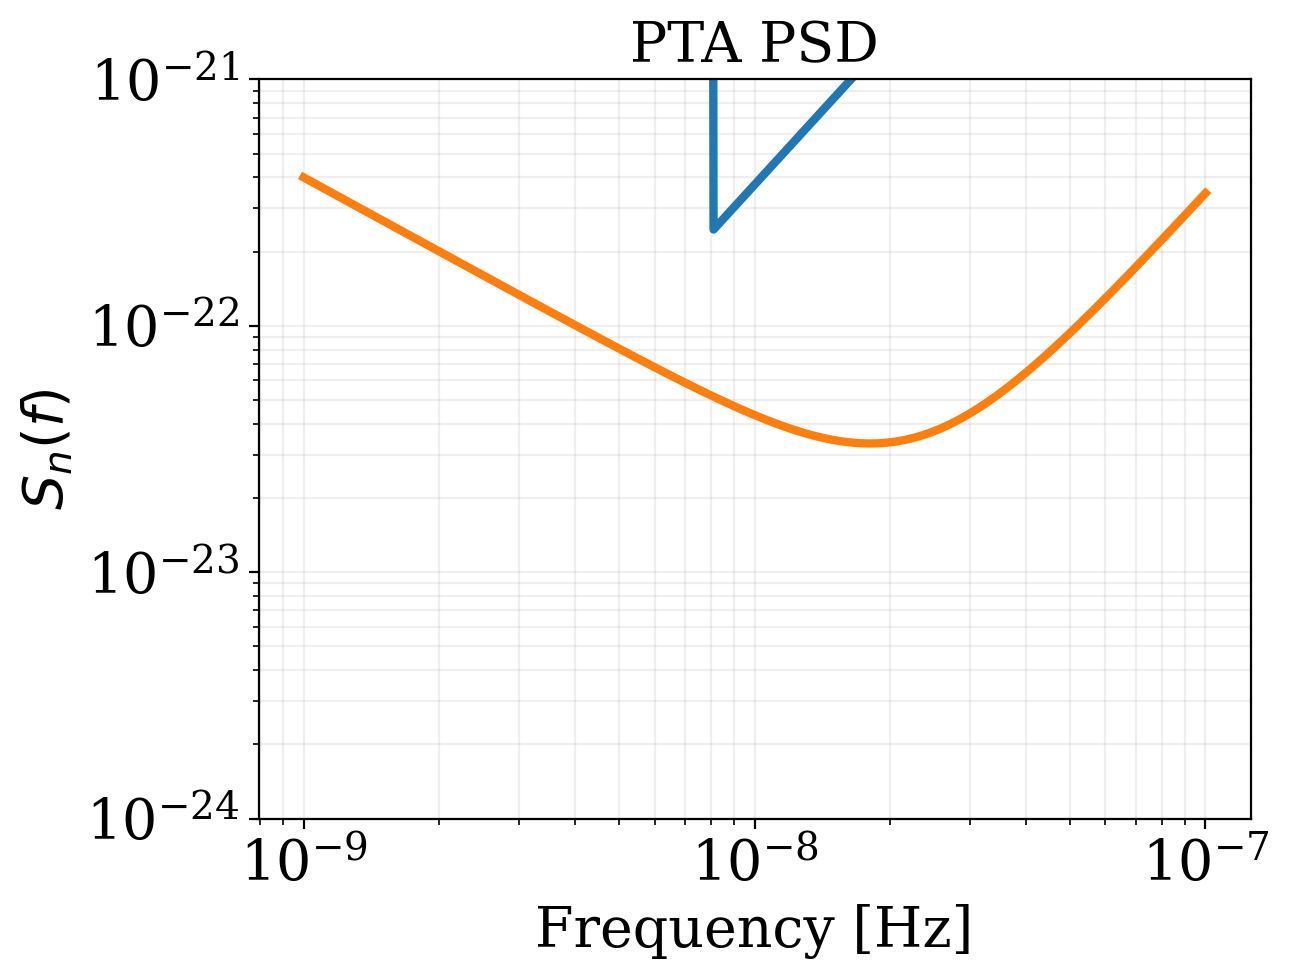

In [ ]:
def PTA_Pn():

    DT = (365*24*3600)/20 # s
    s = 100 * 1e-9 #s
    return 2* (s**2) * DT

def PTA_Sn(f):
        '''
        Returns the power spectral density of the PTA
        '''
        f = np.asarray(f) # Ensure f is a NumPy array
        mask = f >= 8e-9 # Create a boolean mask where True indicates elements greater than or equal to 8e-9
        return np.where(mask, PTA_Pn() * 12 * (np.pi**2) * f**2, 1) # Apply the mask to the result

def PTA_Sn2(f):
      return 4e-31*1/f + 3.41e-8*f**2


f = np.logspace(-9, -7, 100)
PSD = PTA_Sn(f)
PSD2 = PTA_Sn2(f)

plt.loglog(f, PSD)
plt.loglog(f, PSD2)
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$S_n(f)$')
plt.title('PTA PSD')
plt.grid(which='both', alpha=0.2)
plt.ylim(1e-24, 1e-21)


In [ ]:
# small antenna limit

f = c/(2*np.pi *2.5e9)

print(f)


0.019098593171027443


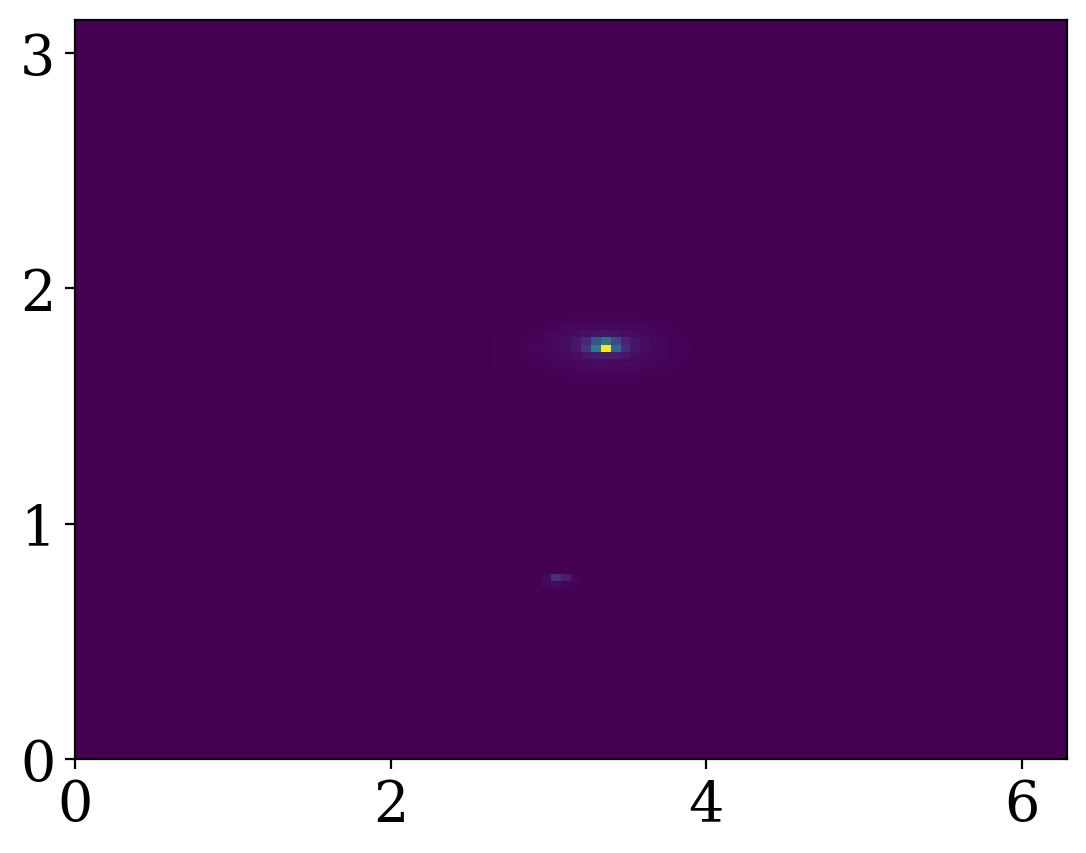

In [ ]:
from gwbird.skymap import Basis

def HD(pi, pj, Omega):
    return  3/4 * (np.einsum('i,i->', pi, pj)- np.einsum('i,ijk->', pi, Omega) * np.einsum('i,ijk->jk', pj, Omega))**2 /((1 + np.einsum('i,ijk->jk', pi, Omega)) * (1 + np.einsum('i,ijk->jk', pj, Omega)) ) - 3/8 * ((1 - np.einsum('i,ijk->jk', pi, Omega)) * (1 - np.einsum('i,ijk->jk', pj, Omega)) )

theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2*np.pi, 100)

theta, phi = np.meshgrid(theta, phi)

Omega = Basis.m_n_Omega_basis(theta, phi, 0)[2]

pi = p[0]
pj = p[1]

hd = HD(pi, pj, Omega)

plt.imshow(hd, cmap='viridis', extent=(0, 2*np.pi, 0, np.pi), aspect='auto')

# Circular polarization tests

In [ ]:
gamma0_ij_V = []
gamma1_ij_V = []
gamma2_ij_V = []
gamma3_ij_V = []

alpha_ij = []

psi = 0
for i in range(N):
    for j in range(i+1, N):
        alpha_ij.append(np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j])))
        gamma0_ij_V.append(AngularResponse.R_ell_pairwise(0, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j], f, 'V', psi))
        gamma1_ij_V.append(AngularResponse.R_ell_pairwise(1, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j],f, 'V', psi))
        gamma2_ij_V.append(AngularResponse.R_ell_pairwise(2, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j],f, 'V', psi))
        gamma3_ij_V.append(AngularResponse.R_ell_pairwise(3, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j],f, 'V', psi))

gamma0_ij_V = np.array(gamma0_ij_V)
gamma1_ij_V = np.array(gamma1_ij_V)
gamma2_ij_V = np.array(gamma2_ij_V)
gamma3_ij_V = np.array(gamma3_ij_V)
alpha_ij = np.array(alpha_ij)


In [ ]:
f_index = np.argmin(np.abs(f - 1e-8))
print(f_index)
gamma0_ij_V_f_index = gamma0_ij_V[:,f_index]
gamma1_ij_V_f_index = gamma1_ij_V[:,f_index]
gamma2_ij_V_f_index = gamma2_ij_V[:,f_index]
gamma3_ij_V_f_index = gamma3_ij_V[:,f_index]


49


In [39]:
# functions to check the angular response https://journals.aps.org/prd/pdf/10.1103/PhysRevD.93.062003

# l=0
def RV_0(alpha):
    return np.zeros(len(alpha))

# l=1
def RV_1_1(alpha):
    return - np.sqrt(6*np.pi)/3 * np.sin(alpha) * ( 1 + 3*((1-np.cos(alpha))/(1+np.cos(alpha)))*np.log(np.sin(alpha/2)) )

def RV_11(alpha):
    return RV_1_1(alpha)

def RV_10(alpha):
    return np.zeros(len(alpha))

def RV_1(alpha):
    term1 = RV_1_1(alpha)
    term2 = RV_11(alpha)
    term3 = RV_10(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2)

# l=2
def RV_2_2(alpha):
    term1 = np.sqrt(30*np.pi)/6 * (1- np.cos(alpha))
    term2 = (2 - np.cos(alpha))
    term3 = 6 * ((1- np.cos(alpha))/(1+ np.cos(alpha))) * np.log(np.sin(alpha/2))
    return term1* (term2 + term3)

def RV_2_1(alpha):
    term1 = np.sqrt(30*np.pi)/6 * (np.sin(alpha)/(1+ np.cos(alpha)))
    term2 = 2
    term3 = (1- np.cos(alpha))
    term4 = (np.cos(alpha) + 6* np.log(np.sin(alpha/2)))
    return term1* (term2 + term3*term4)

def RV_20(alpha):
    return np.zeros(len(alpha))

def RV_21(alpha):
    return RV_2_1(alpha)

def RV_22(alpha):
    return -RV_2_2(alpha)

def RV_2(alpha):
    term1 = RV_2_2(alpha)
    term2 = RV_2_1(alpha)
    term3 = RV_20(alpha)
    term4 = RV_21(alpha)
    term5 = RV_22(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2 + term4**2 + term5**2)

# l = 3

def RV_3_3(alpha):
    ratio = (1-np.cos(alpha))/(1+np.cos(alpha))
    term1 = - np.sqrt(35*np.pi)/16 * np.sin(alpha) * ratio
    term2 = 11 - 6*np.cos(alpha) - np.cos(alpha)**2
    term3 = 32 * ratio * np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def RV_3_2(alpha):
    term1 = - np.sqrt(210*np.pi)/24 * (1 - np.cos(alpha))
    term2 = 8 - 5*np.cos(alpha) - np.cos(alpha)**2
    ratio = (1-np.cos(alpha))/(1+np.cos(alpha))
    term3 = 24*ratio*np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def RV_3_1(alpha):
    term1 = - np.sqrt(21*np.pi)/48 * np.sin(alpha)
    term2 = 33 - 20*np.cos(alpha) - 5*np.cos(alpha)**2
    ratio = (1-np.cos(alpha))/(1+np.cos(alpha))
    term3 = 96* ratio *np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def RV_3_0(alpha):
    return np.zeros(len(alpha))

def RV_31(alpha):
    return RV_3_1(alpha)

def RV_32(alpha):
    return -RV_3_2(alpha)

def RV_33(alpha):
    return RV_3_3(alpha)

def RV_3(alpha):
    term1 = RV_3_3(alpha)
    term2 = RV_3_2(alpha)
    term3 = RV_3_1(alpha)
    term4 = RV_3_0(alpha)
    term5 = RV_31(alpha)
    term6 = RV_32(alpha)
    term7 = RV_33(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2 + term4**2 + term5**2 + term6**2 + term7**2)


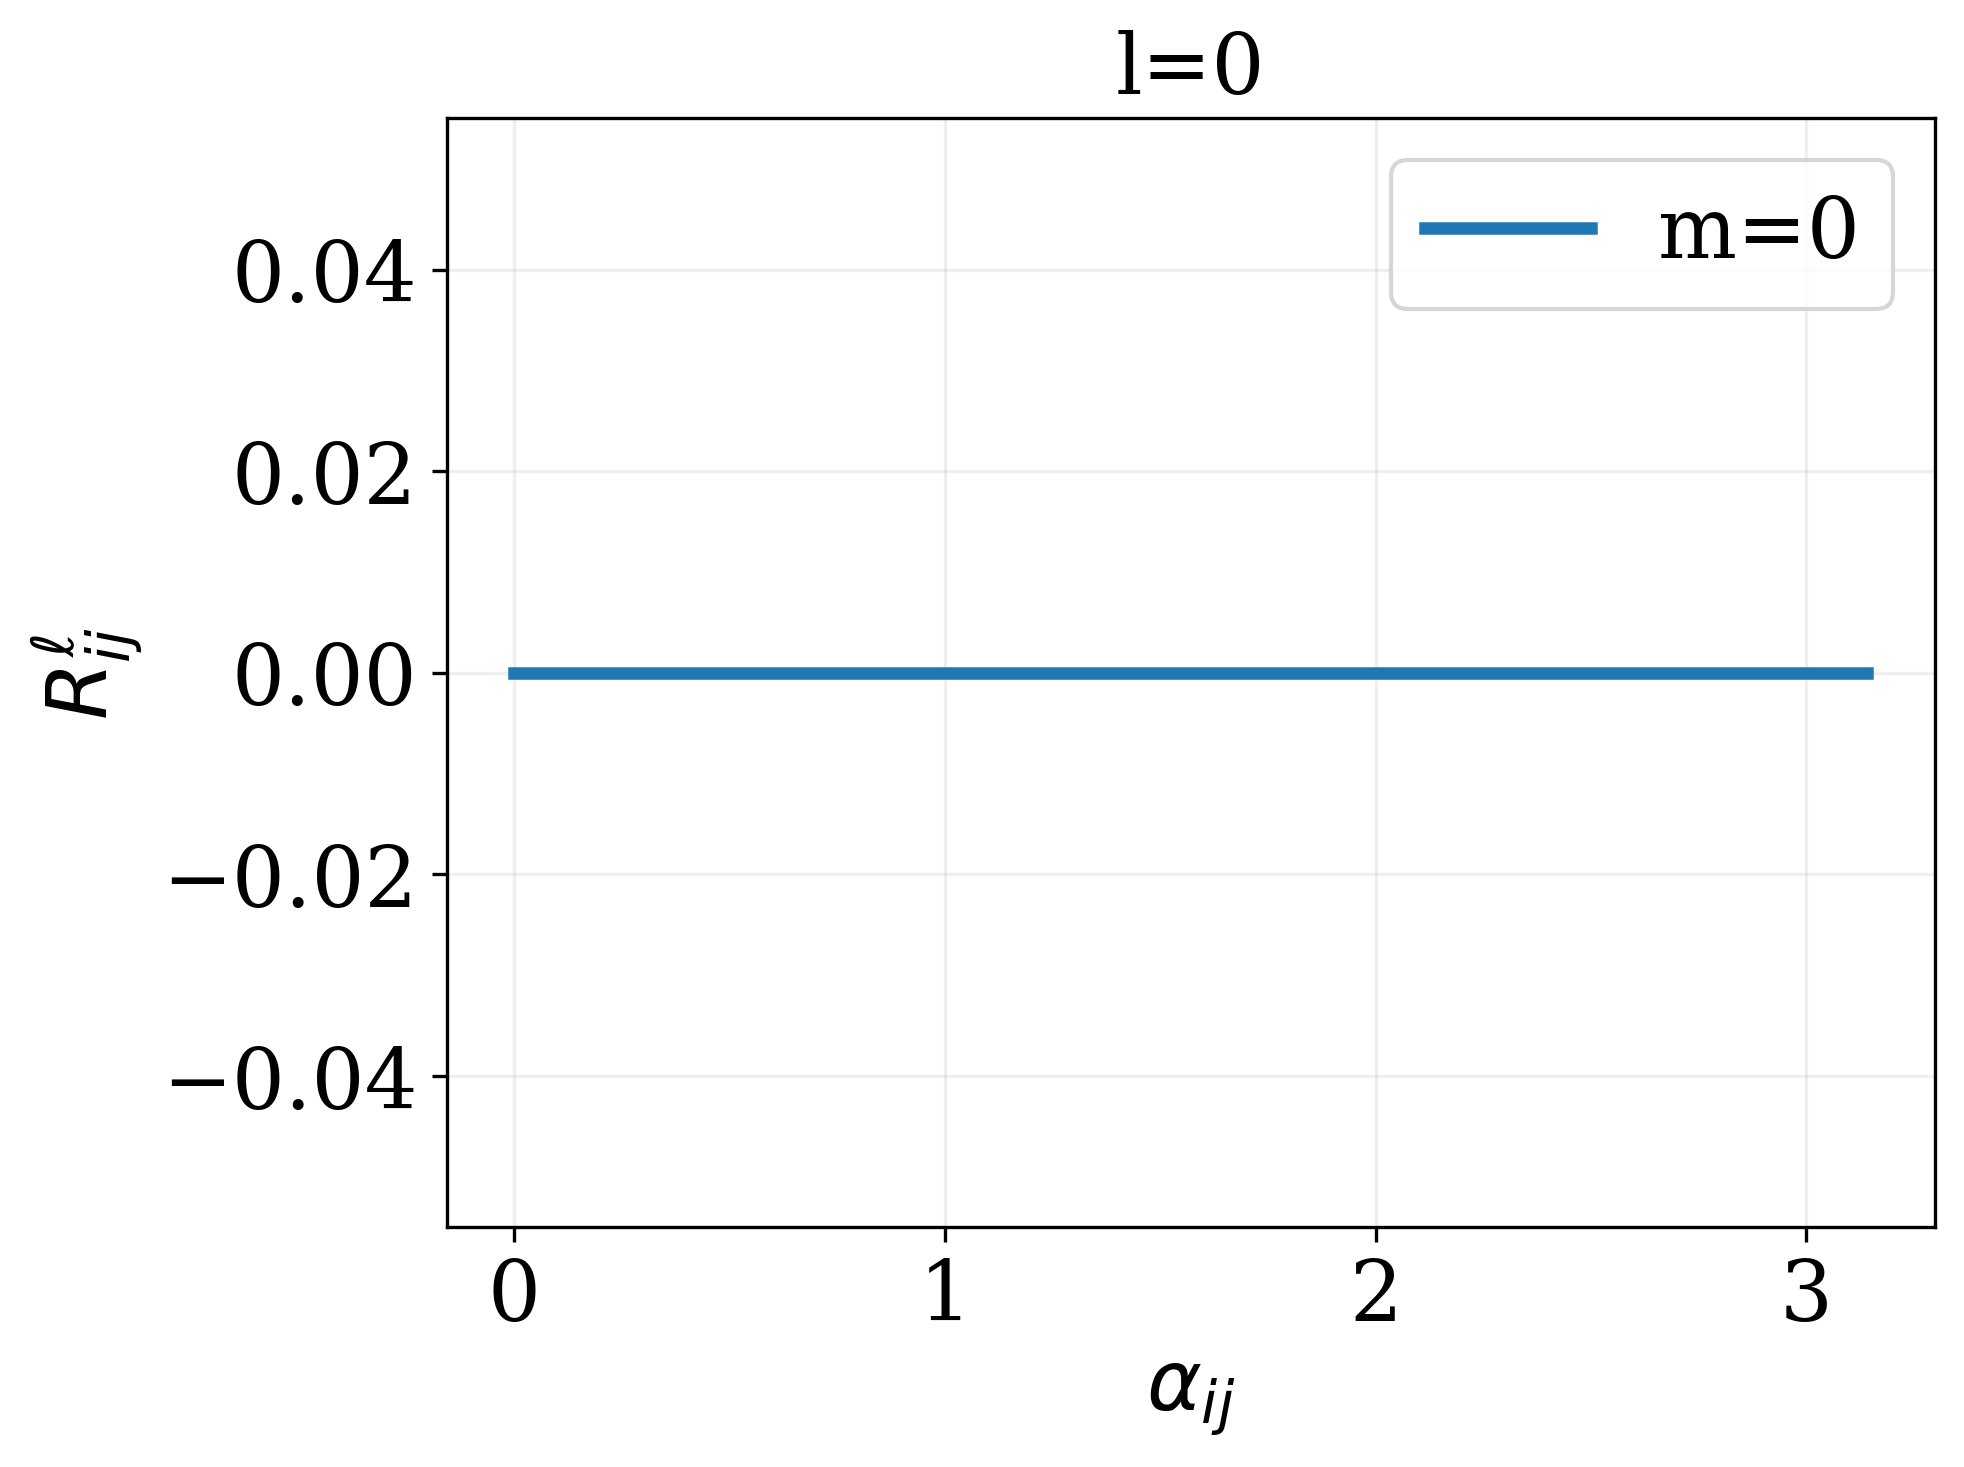

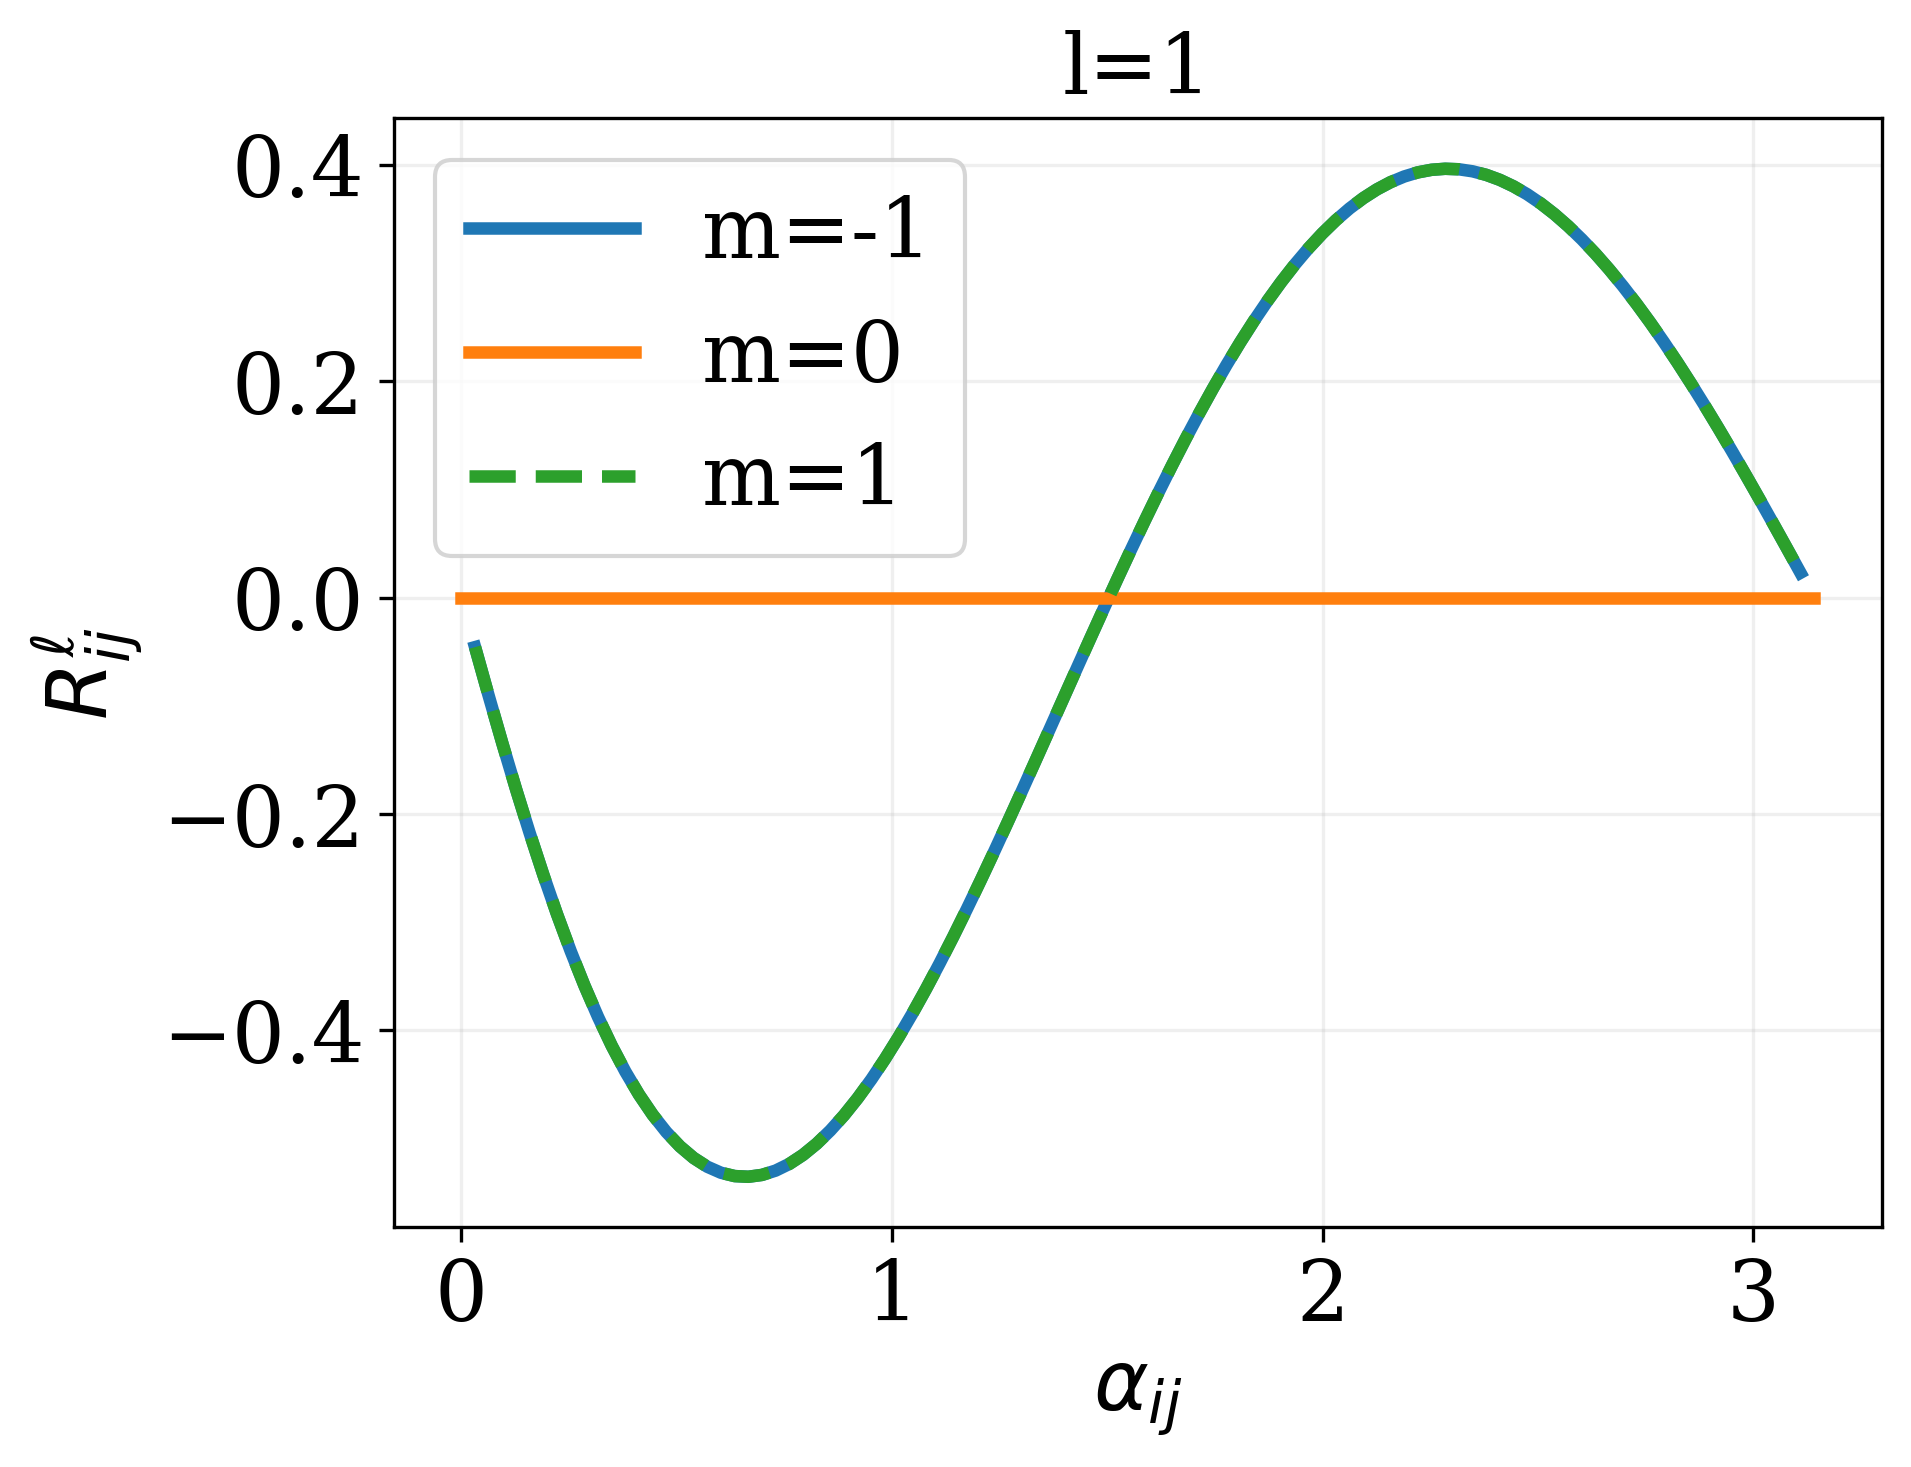

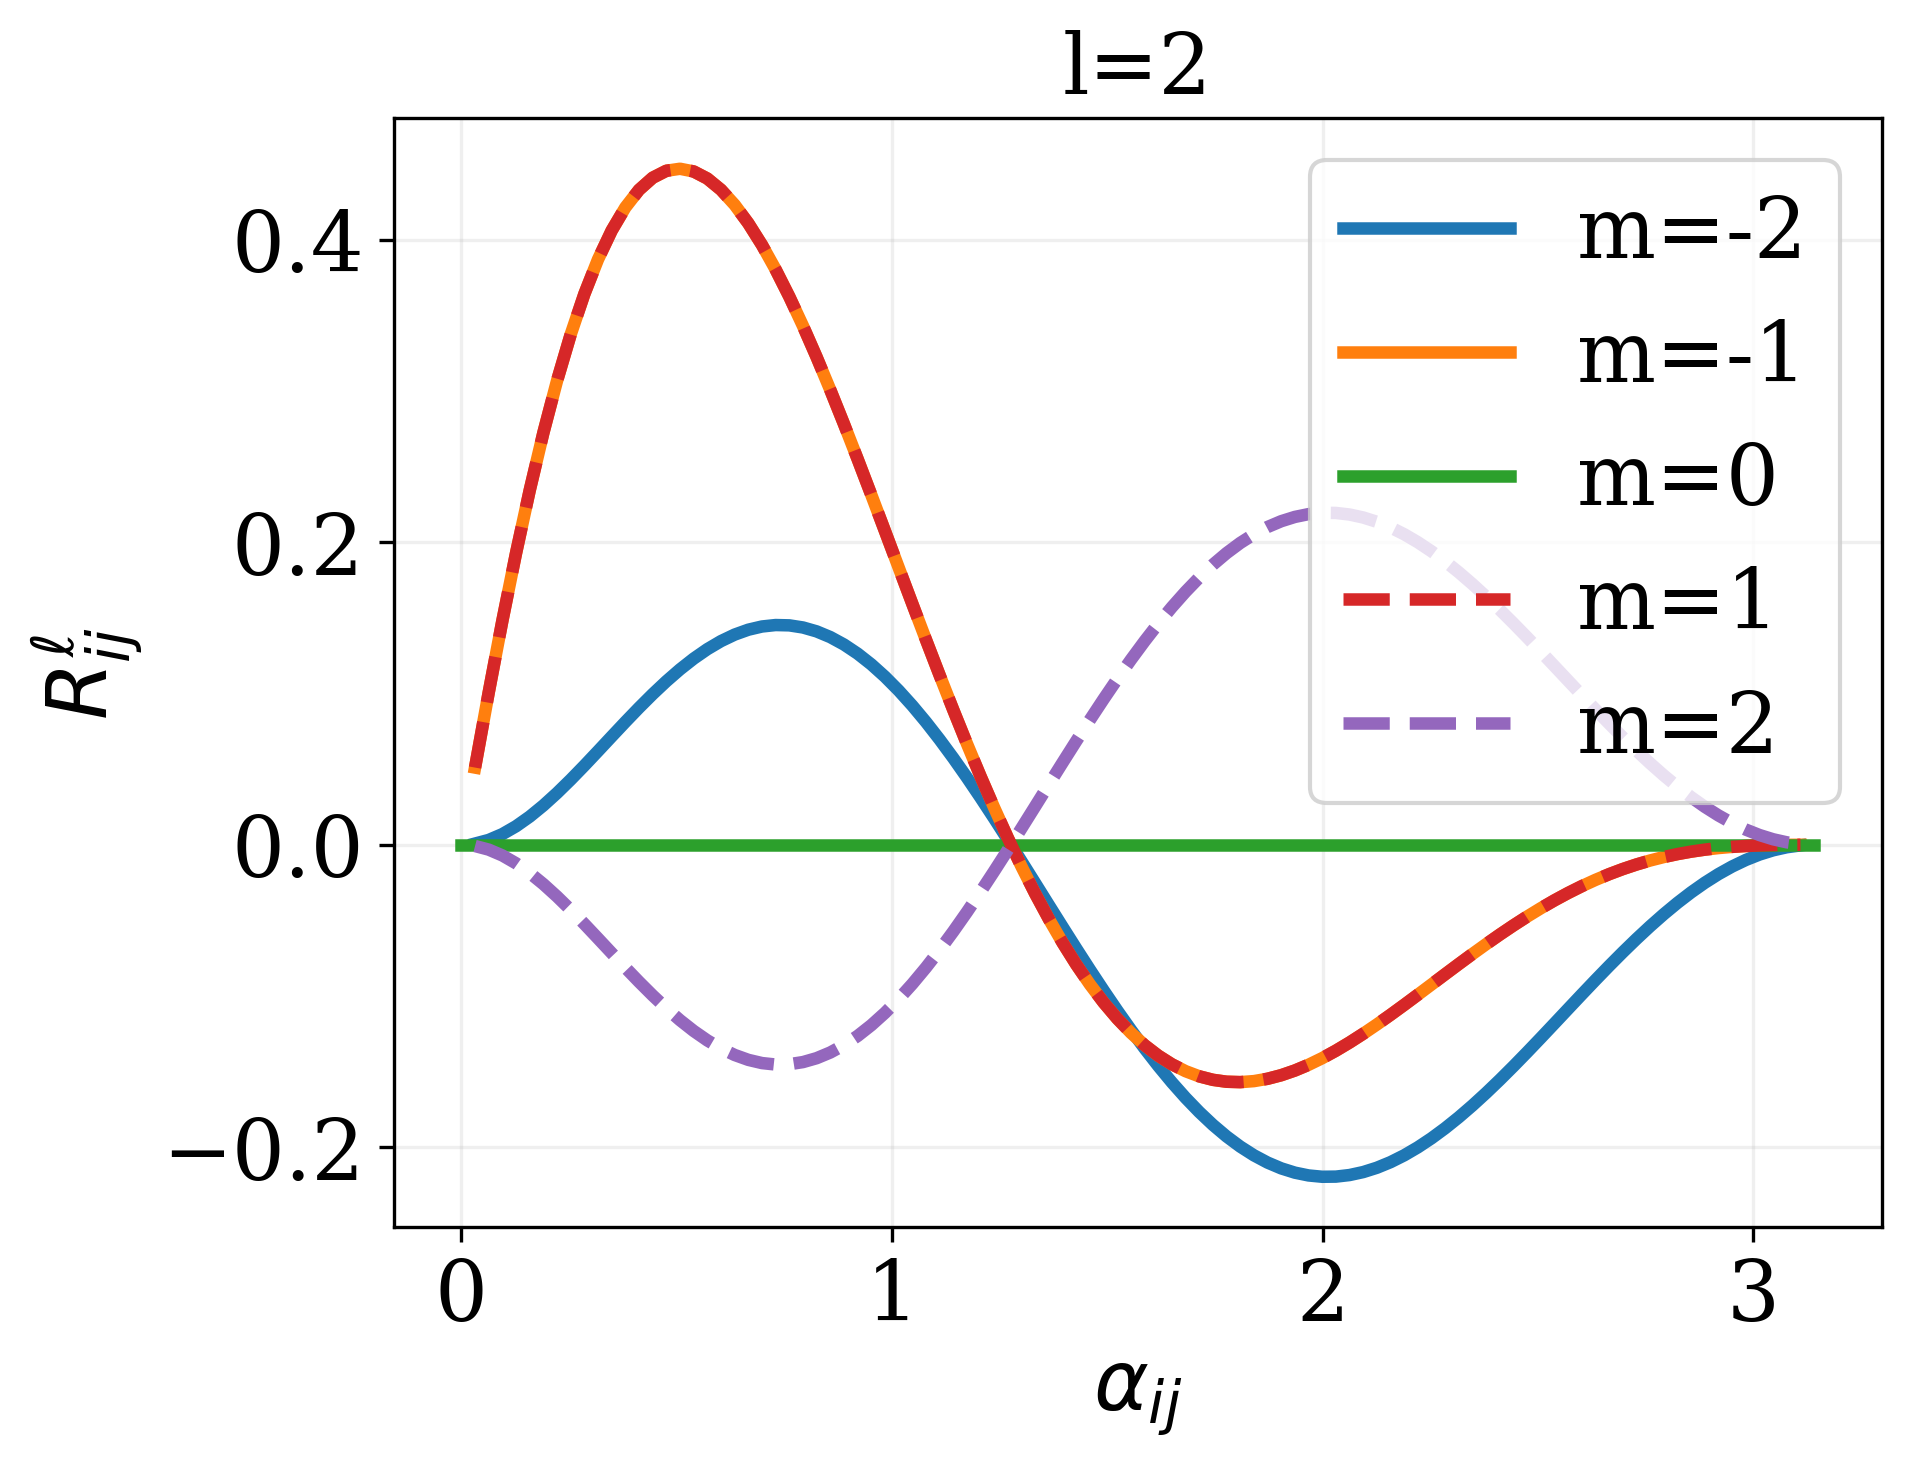

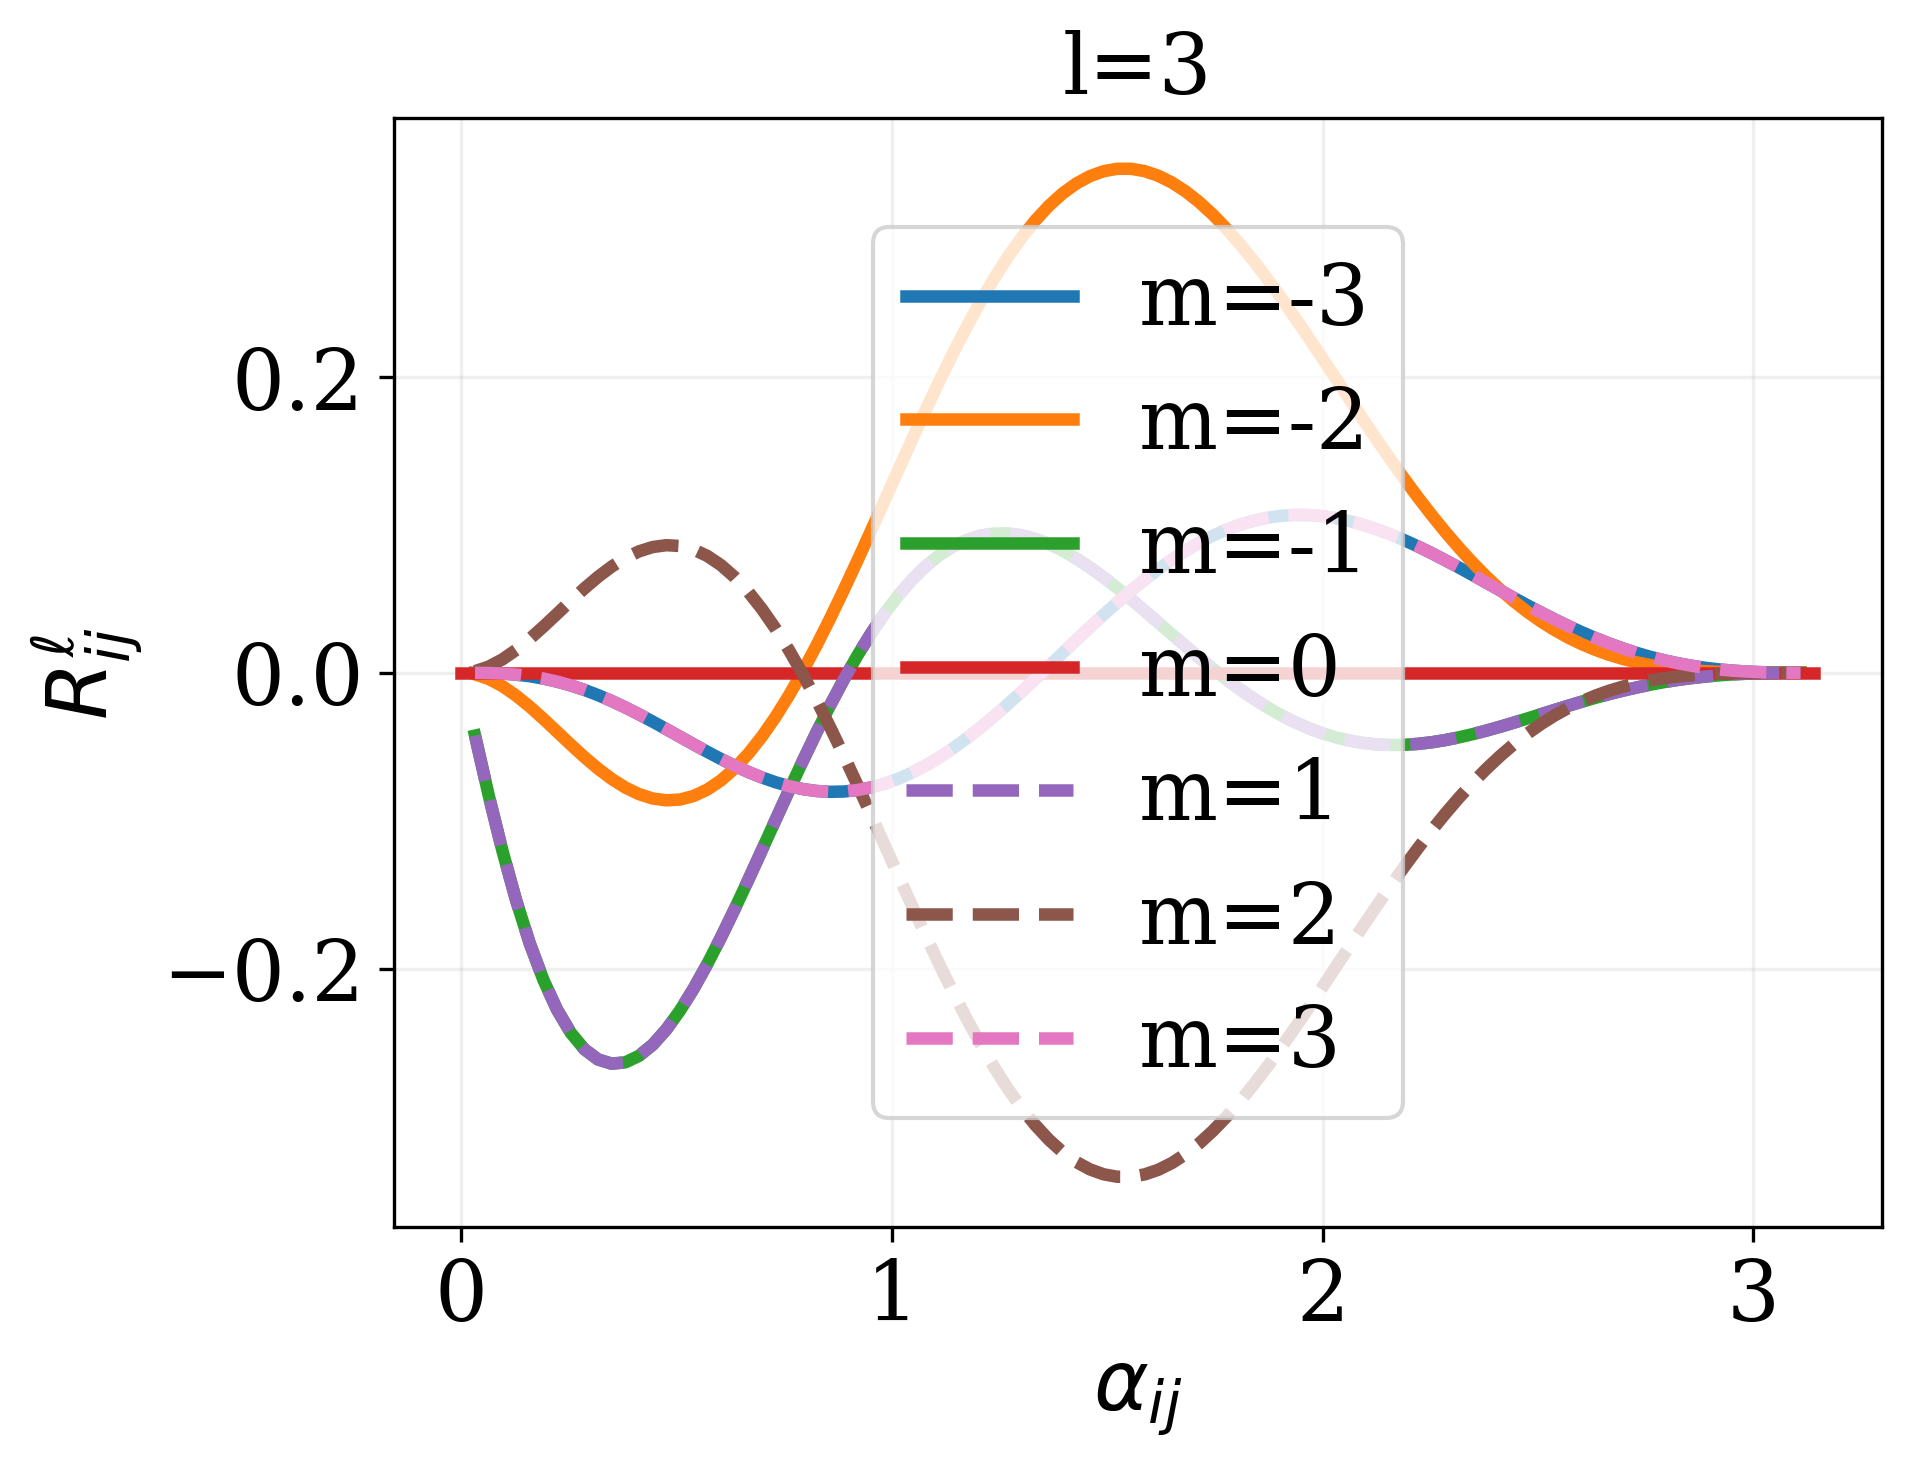

In [ ]:
alpha = np.linspace(0, np.pi, 100)

# l = 0

plt.plot(alpha, RV_0(alpha), label='m=0')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{\ell}$')
plt.title('l=0')
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()

# l = 1
plt.plot(alpha, RV_1_1(alpha), label='m=-1')
plt.plot(alpha, RV_10(alpha), label='m=0')
plt.plot(alpha, RV_11(alpha), label='m=1', linestyle = '--')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{\ell}$')
plt.title('l=1')
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()

# l = 2
plt.plot(alpha, RV_2_2(alpha), label='m=-2')
plt.plot(alpha, RV_2_1(alpha), label='m=-1')
plt.plot(alpha, RV_20(alpha), label='m=0')
plt.plot(alpha, RV_21(alpha), label='m=1', linestyle = '--')
plt.plot(alpha, RV_22(alpha), label='m=2', linestyle = '--')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{\ell}$')
plt.title('l=2')
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()

# l = 3
plt.plot(alpha, RV_3_3(alpha), label='m=-3')
plt.plot(alpha, RV_3_2(alpha), label='m=-2')
plt.plot(alpha, RV_3_1(alpha), label='m=-1')
plt.plot(alpha, RV_3_0(alpha), label='m=0')
plt.plot(alpha, RV_31(alpha), label='m=1', linestyle = '--')
plt.plot(alpha, RV_32(alpha), label='m=2', linestyle = '--')
plt.plot(alpha, RV_33(alpha), label='m=3', linestyle = '--')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{\ell}$')
plt.title('l=3')
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()


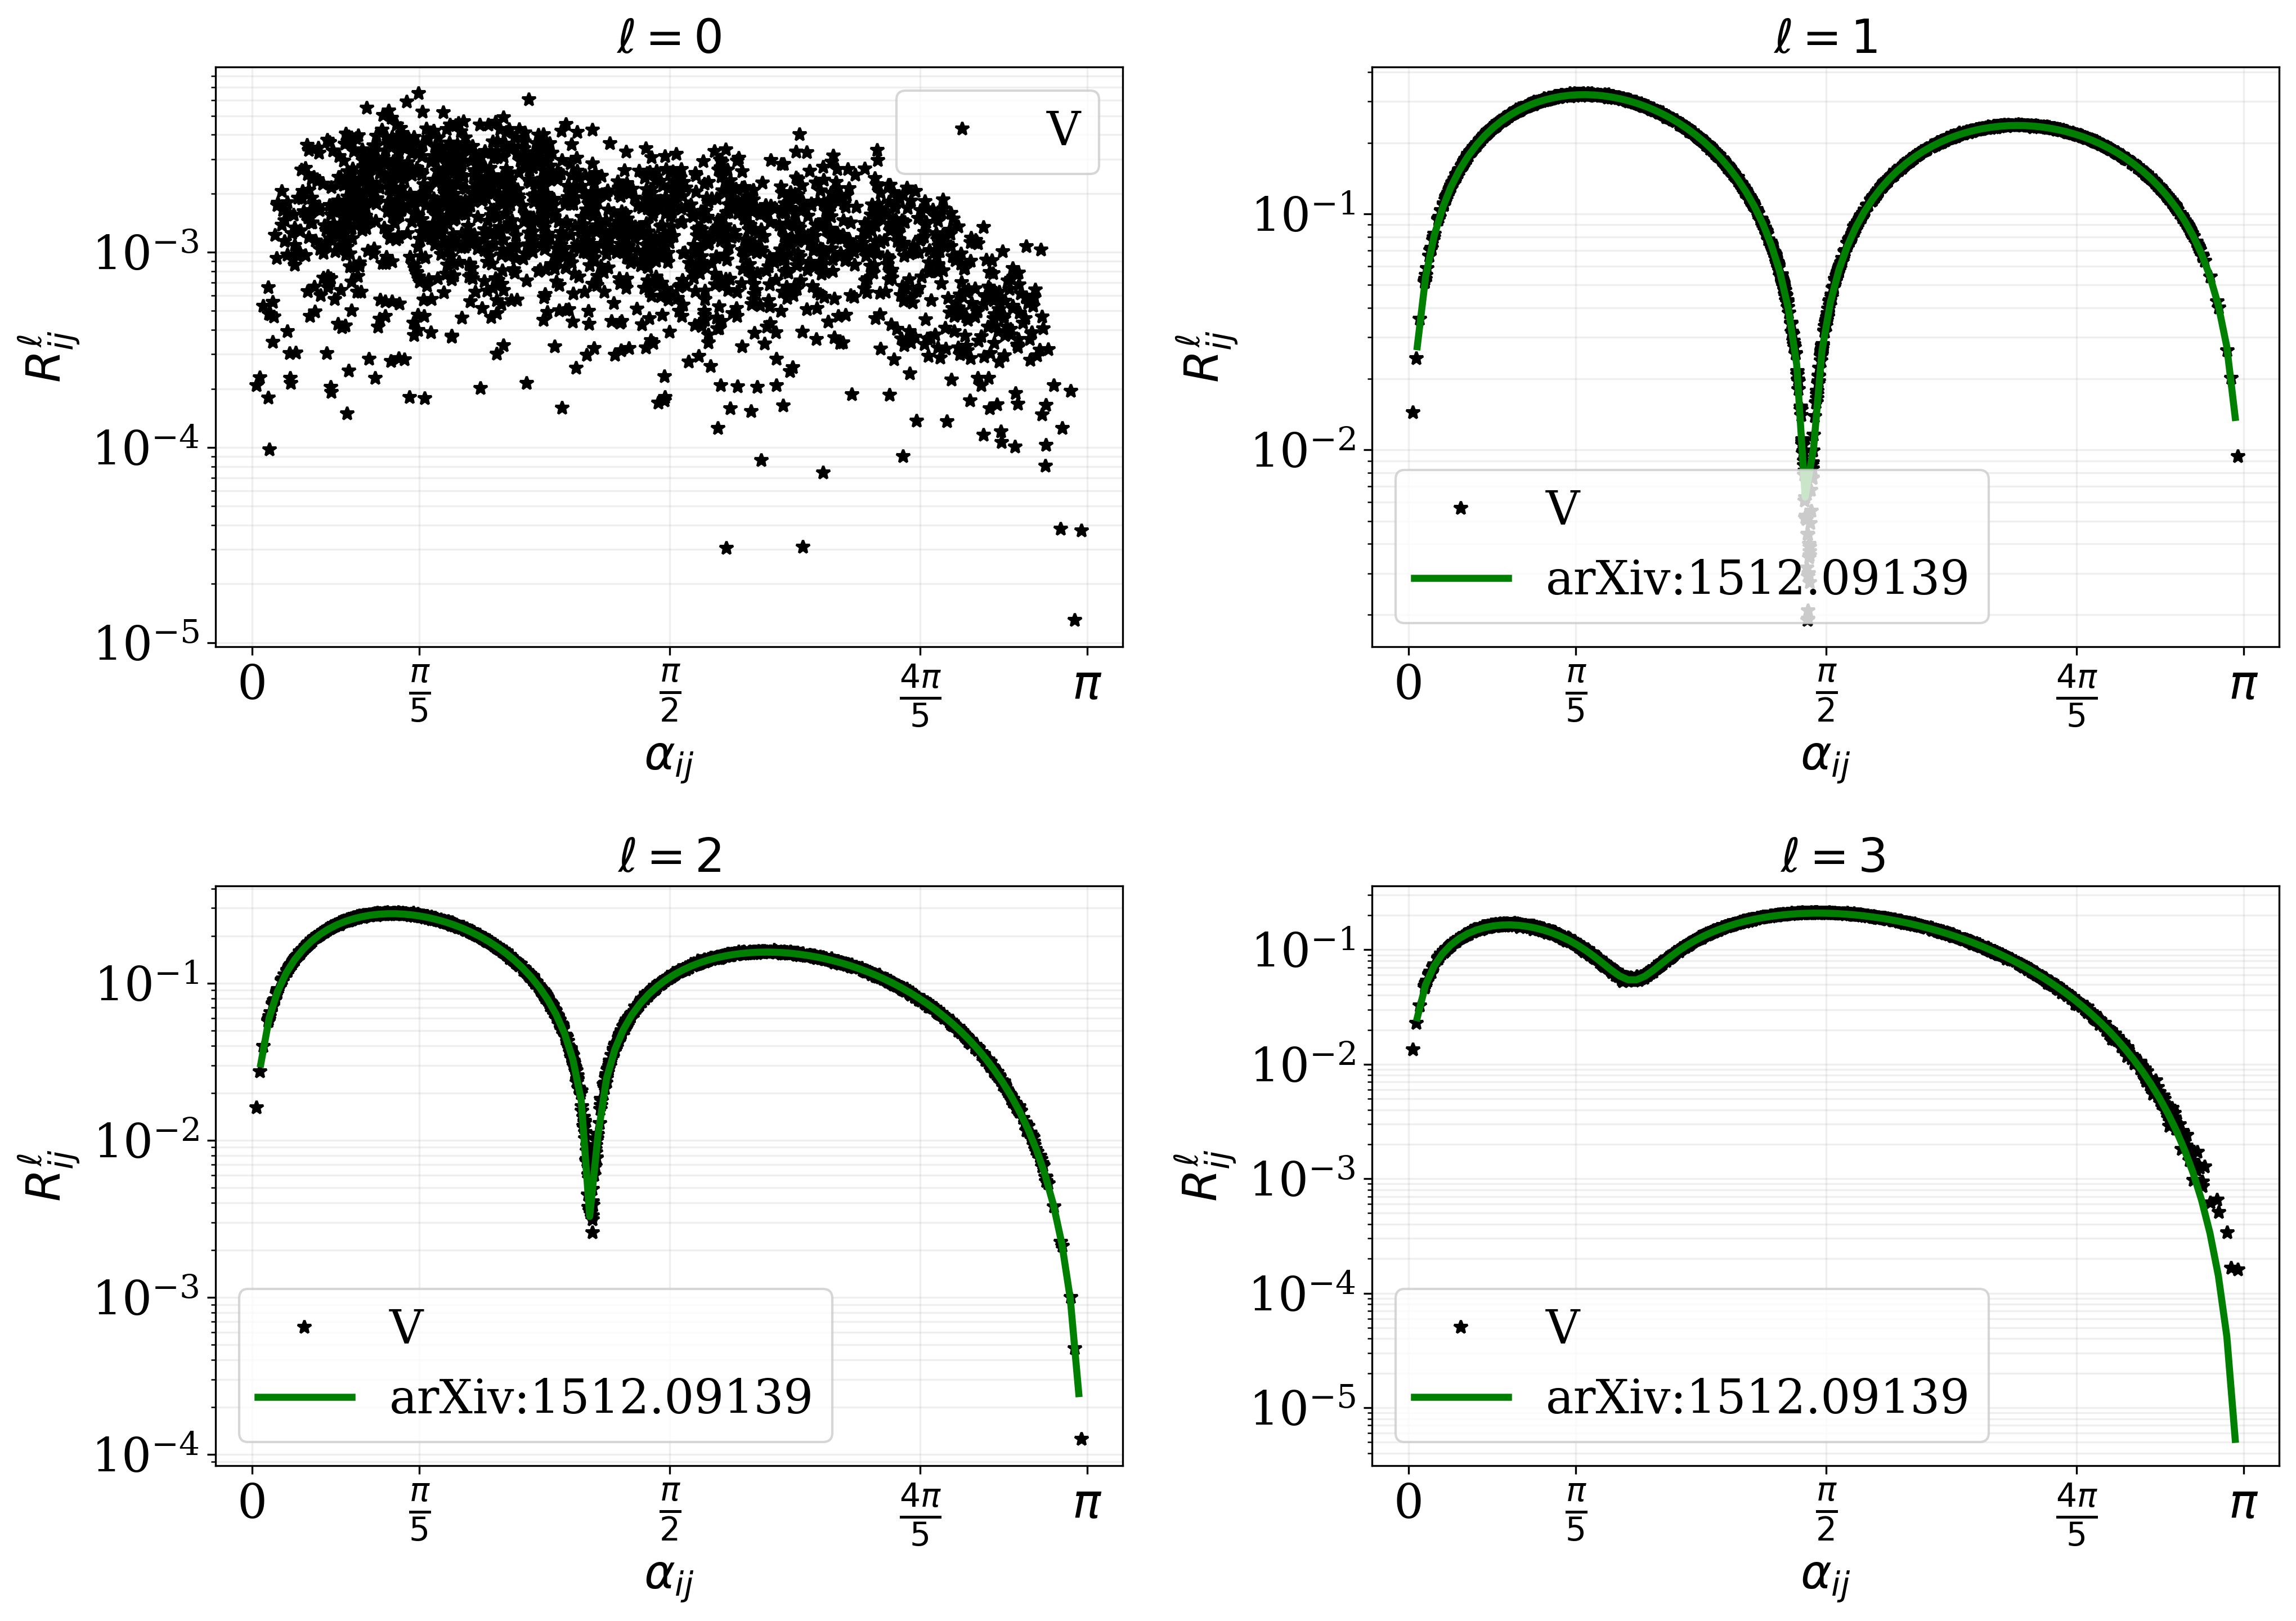

In [ ]:
# plot

# plot 2x2 dove in ogni blocco c'è un multipolo

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Definizione dei tick personalizzati
custom_ticks = [0, np.pi / 5, np.pi / 2, 4 * np.pi / 5, np.pi]

norm = 3*np.sqrt(4*np.pi)/(8*np.pi)

# Plot per ℓ=0
ax[0, 0].semilogy(alpha_ij, np.abs(gamma0_ij_V_f_index), '*', color='black', label='V')
#ax[0, 0].semilogy(alpha, norm*np.abs(RV_0(alpha)), color='red', label='ref.')
ax[0, 0].set_xlabel(r'$\alpha_{ij}$')
ax[0, 0].set_ylabel(r'$R_{ij}^{\ell}$')
ax[0, 0].grid(which='both', alpha=0.2)
ax[0, 0].set_title(r'$\ell=0$')
ax[0, 0].set_xticks(custom_ticks)
ax[0, 0].legend()
ax[0, 0].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=1
ax[0, 1].semilogy(alpha_ij, gamma1_ij_V_f_index, '*', color='black', label='V')
ax[0, 1].semilogy(alpha, norm*RV_1(alpha), color='green', label='arXiv:1512.09139')
ax[0, 1].set_xlabel(r'$\alpha_{ij}$')
ax[0, 1].set_ylabel(r'$R_{ij}^{\ell}$')
ax[0, 1].grid(which='both', alpha=0.2)
ax[0, 1].set_title(r'$\ell=1$')
ax[0, 1].set_xticks(custom_ticks)
ax[0, 1].legend()
ax[0, 1].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=2
ax[1, 0].semilogy(alpha_ij, gamma2_ij_V_f_index, '*', color='black', label='V')
ax[1, 0].semilogy(alpha, norm*RV_2(alpha), color='green', label='arXiv:1512.09139')
ax[1, 0].set_xlabel(r'$\alpha_{ij}$')
ax[1, 0].set_ylabel(r'$R_{ij}^{\ell}$')
ax[1, 0].grid(which='both', alpha=0.2)
ax[1, 0].set_title(r'$\ell=2$')
ax[1, 0].set_xticks(custom_ticks)
ax[1, 0].legend()
ax[1, 0].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=3
ax[1, 1].semilogy(alpha_ij, gamma3_ij_V_f_index, '*', color='black', label='V')
ax[1, 1].semilogy(alpha, norm*RV_3(alpha), color='green', label='arXiv:1512.09139')
ax[1, 1].set_xlabel(r'$\alpha_{ij}$')
ax[1, 1].set_ylabel(r'$R_{ij}^{\ell}$')
ax[1, 1].grid(which='both', alpha=0.2)
ax[1, 1].set_title(r' $\ell=3$')
ax[1, 1].set_xticks(custom_ticks)
ax[1, 1].legend()
ax[1, 1].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

plt.tight_layout()
plt.show()


 No pulsar term

In [ ]:
gamma0_ij_V_noPT = []
gamma1_ij_V_noPT = []
gamma2_ij_V_noPT = []
gamma3_ij_V_noPT = []

alpha_ij = []

psi = 0
for i in range(N):
    for j in range(i+1, N):
        alpha_ij.append(np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j])))
        gamma0_ij_V_noPT.append(AngularResponse.R_ell_pairwise(0, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j], f, 'V', psi))
        gamma1_ij_V_noPT.append(AngularResponse.R_ell_pairwise(1, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j],f, 'V', psi))
        gamma2_ij_V_noPT.append(AngularResponse.R_ell_pairwise(2, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j],f, 'V', psi))
        gamma3_ij_V_noPT.append(AngularResponse.R_ell_pairwise(3, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j],f, 'V', psi))

gamma0_ij_V_noPT = np.array(gamma0_ij_V_noPT)
gamma1_ij_V_noPT = np.array(gamma1_ij_V_noPT)
gamma2_ij_V_noPT = np.array(gamma2_ij_V_noPT)
gamma3_ij_V_noPT = np.array(gamma3_ij_V_noPT)
alpha_ij = np.array(alpha_ij)


In [ ]:
gamma_ij_V_noPT = []

alpha_ij = []

psi = 0
for i in range(N):
    for j in range(i+1, N):
        alpha_ij.append(np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j])))
        gamma_ij_V_noPT.append(Response.pairwise_overlap(f, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j], 'V', psi))

gamma_ij_V_noPT = np.array(gamma_ij_V_noPT)

alpha_ij = np.array(alpha_ij)

In [ ]:
print(gamma0_ij_V_noPT.shape)
print(gamma_ij_V_noPT.shape)

(1770,)
(1770, 100)


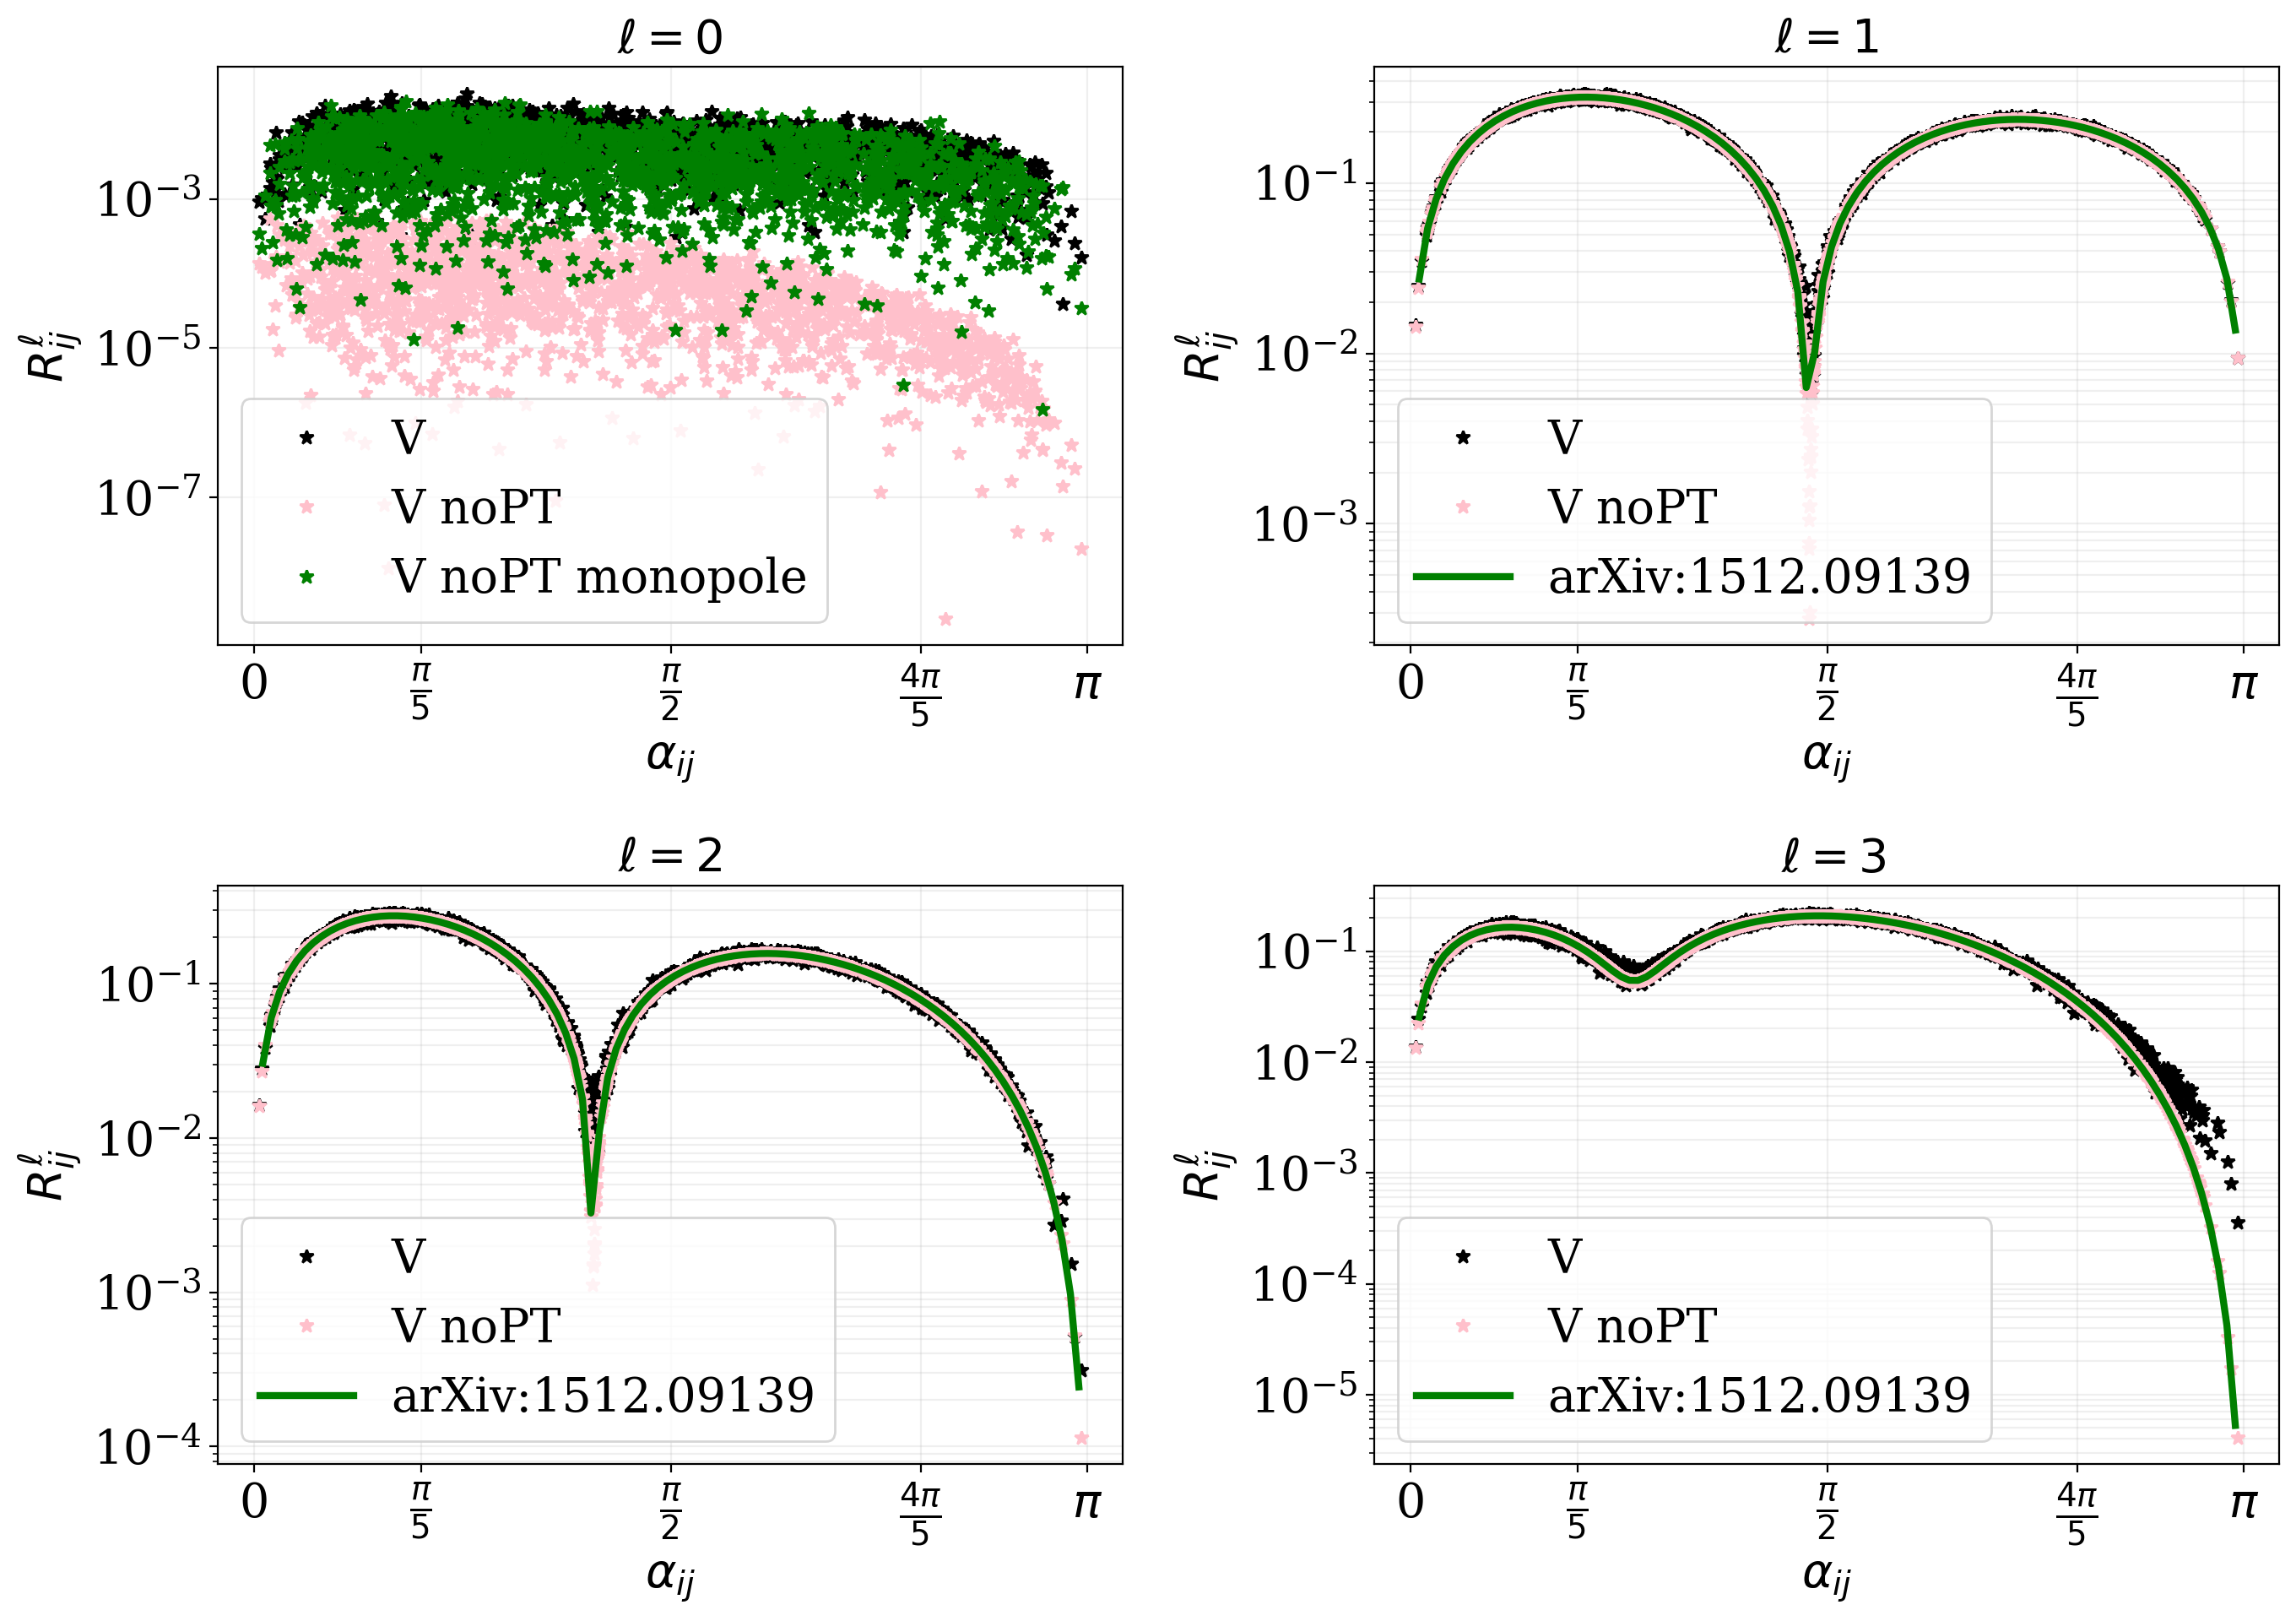

In [ ]:
# plot

# plot 2x2 dove in ogni blocco c'è un multipolo

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Definizione dei tick personalizzati
custom_ticks = [0, np.pi / 5, np.pi / 2, 4 * np.pi / 5, np.pi]

norm = 3*np.sqrt(4*np.pi)/(8*np.pi)

# Plot per ℓ=0
ax[0, 0].semilogy(alpha_ij, np.abs(gamma0_ij_V_f_index), '*', color='black', label='V')
#ax[0, 0].semilogy(alpha, norm*np.abs(RV_0(alpha)), color='red', label='ref.')
ax[0, 0].semilogy(alpha_ij, gamma0_ij_V_noPT, '*', color='pink', label='V noPT')
ax[0, 0].semilogy(alpha_ij, np.abs(gamma_ij_V_noPT[:, 0]), '*', color='green', label='V noPT monopole')
ax[0, 0].set_xlabel(r'$\alpha_{ij}$')
ax[0, 0].set_ylabel(r'$R_{ij}^{\ell}$')
ax[0, 0].grid(which='both', alpha=0.2)
ax[0, 0].set_title(r'$\ell=0$')
ax[0, 0].set_xticks(custom_ticks)
ax[0, 0].legend()
ax[0, 0].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=1
ax[0, 1].semilogy(alpha_ij, gamma1_ij_V_f_index, '*', color='black', label='V')
ax[0, 1].semilogy(alpha_ij, gamma1_ij_V_noPT, '*', color='pink', label='V noPT')
ax[0, 1].semilogy(alpha, norm*RV_1(alpha), color='green', label='arXiv:1512.09139')
ax[0, 1].set_xlabel(r'$\alpha_{ij}$')
ax[0, 1].set_ylabel(r'$R_{ij}^{\ell}$')
ax[0, 1].grid(which='both', alpha=0.2)
ax[0, 1].set_title(r'$\ell=1$')
ax[0, 1].set_xticks(custom_ticks)
ax[0, 1].legend()
ax[0, 1].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=2
ax[1, 0].semilogy(alpha_ij, gamma2_ij_V_f_index, '*', color='black', label='V')
ax[1, 0].semilogy(alpha_ij, gamma2_ij_V_noPT, '*', color='pink', label='V noPT')
ax[1, 0].semilogy(alpha, norm*RV_2(alpha), color='green', label='arXiv:1512.09139')
ax[1, 0].set_xlabel(r'$\alpha_{ij}$')
ax[1, 0].set_ylabel(r'$R_{ij}^{\ell}$')
ax[1, 0].grid(which='both', alpha=0.2)
ax[1, 0].set_title(r'$\ell=2$')
ax[1, 0].set_xticks(custom_ticks)
ax[1, 0].legend()
ax[1, 0].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=3
ax[1, 1].semilogy(alpha_ij, gamma3_ij_V_f_index, '*', color='black', label='V')
ax[1, 1].semilogy(alpha_ij, gamma3_ij_V_noPT, '*', color='pink', label='V noPT')
ax[1, 1].semilogy(alpha, norm*RV_3(alpha), color='green', label='arXiv:1512.09139')
ax[1, 1].set_xlabel(r'$\alpha_{ij}$')
ax[1, 1].set_ylabel(r'$R_{ij}^{\ell}$')
ax[1, 1].grid(which='both', alpha=0.2)
ax[1, 1].set_title(r' $\ell=3$')
ax[1, 1].set_xticks(custom_ticks)
ax[1, 1].legend()
ax[1, 1].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

plt.tight_layout()
plt.show()

In [2]:
T_15_years = 15 * 365 * 24 * 3600  # in s
f_15_years = 1 / T_15_years  # in Hz

print(f_15_years/1e-9)

2.113986132250972


In [32]:
gamma0_ij_V = []
gamma1_ij_V = []
# gamma2_ij_V = []
# gamma3_ij_V = []
alpha_ij = []
psi = 0
for i in range(N):
    for j in range(i+1, N):
        alpha_ij.append(np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j])))
        gamma0_ij_V.append(AngularResponse.R_ell_pairwise(0, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j], f, 'V', psi))
        gamma1_ij_V.append(AngularResponse.R_ell_pairwise(1, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j], f, 'V', psi))
        # gamma2_ij_V.append(AngularResponse.R_ell_pairwise(2, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j],f, 'V', psi))
        # gamma3_ij_V.append(AngularResponse.R_ell_pairwise(3, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j],f, 'V', psi))


gamma0_ij_V = np.array(gamma0_ij_V)
gamma1_ij_V = np.array(gamma1_ij_V)
# gamma2_ij_V = np.array(gamma2_ij_V)
# gamma3_ij_V = np.array(gamma3_ij_V)



In [34]:
print(gamma0_ij_V.shape)
alpha_ij = np.array(alpha_ij)

(1770,)


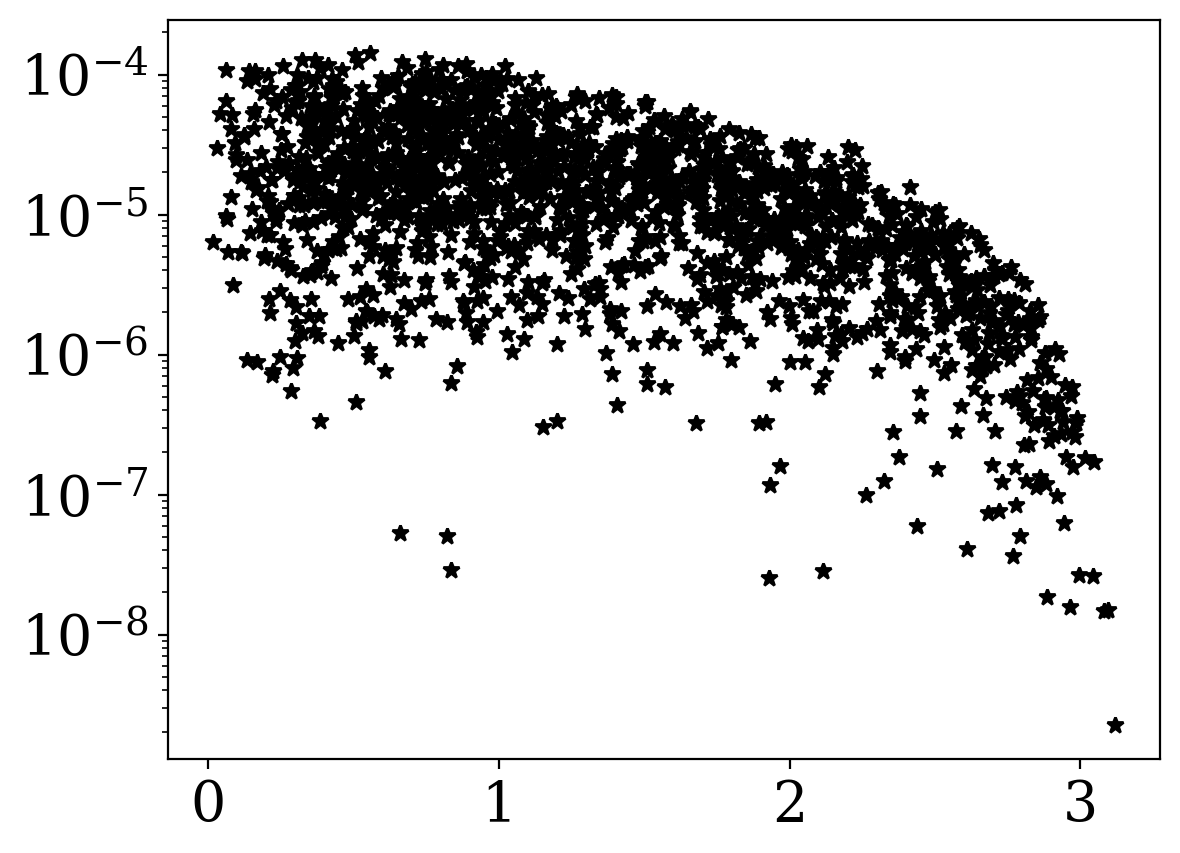

In [36]:
plt.semilogy(alpha_ij, gamma0_ij_V, '*', color='black', label='V')


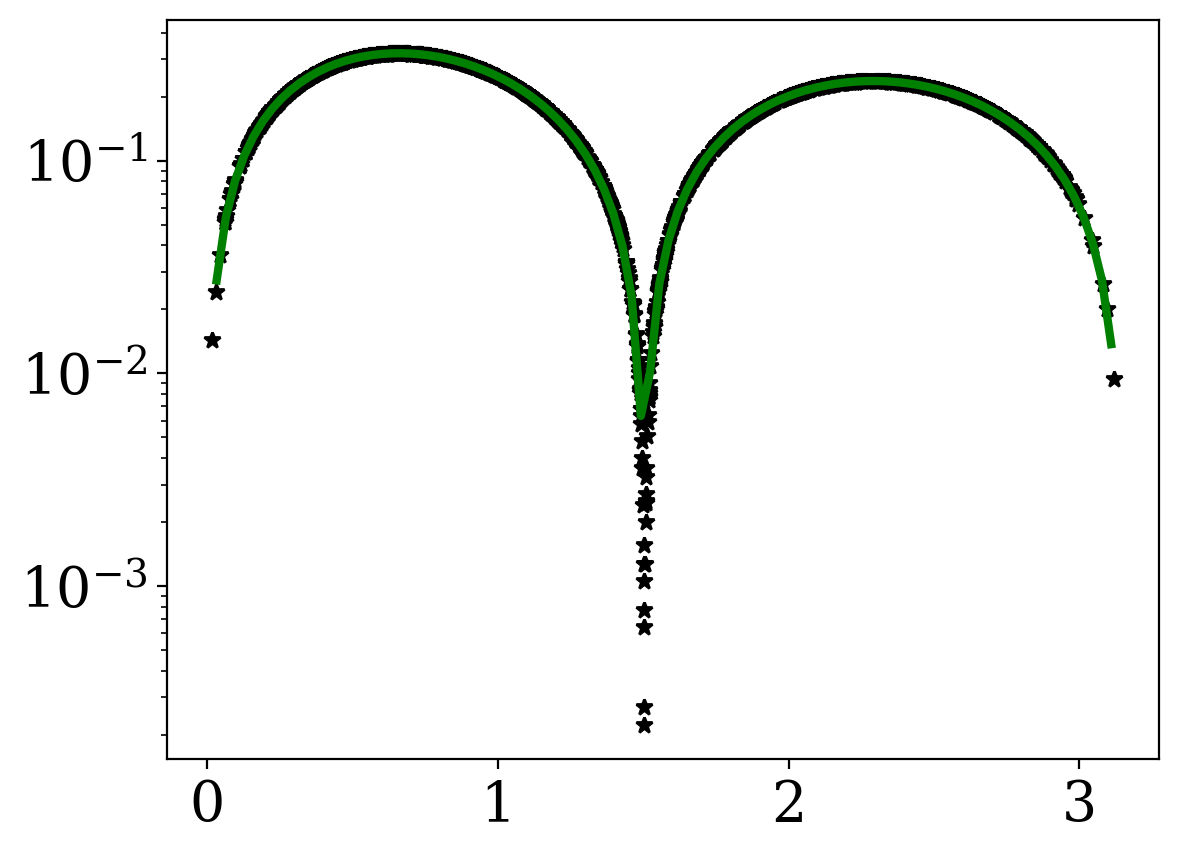

In [40]:
norm = 3*np.sqrt(4*np.pi)/(8*np.pi)
plt.semilogy(alpha_ij, gamma1_ij_V, '*', color='black', label='V')
plt.semilogy(alpha, norm*RV_1(alpha), color='green', label='arXiv:1512.09139')

In [41]:
gamma0_ij_V = []
gamma1_ij_V = []
alpha_ij = []

def rodrigues_rotation_matrix(axis, theta):
    axis = axis / np.linalg.norm(axis)
    K = np.array([
        [0, -axis[2], axis[1]],
        [axis[2], 0, -axis[0]],
        [-axis[1], axis[0], 0]
    ])
    I = np.eye(3)
    return I + np.sin(theta)*K + (1 - np.cos(theta))*(K @ K)


# Per ogni coppia (i, j)
for i in range(N):
    for j in range(i+1, N):
        # Rotazione per la coppia (i, j)
        p_a = pulsar_xyz[i]
        p_b = pulsar_xyz[j]

        # Step 1: porta p_a su z
        z_hat = np.array([0, 0, 1])
        v = np.cross(p_a, z_hat)
        if np.linalg.norm(v) < 1e-8:
            R1 = np.eye(3)
        else:
            theta = np.arccos(np.clip(np.dot(p_a, z_hat), -1, 1))
            R1 = rodrigues_rotation_matrix(v, theta)

        rotated1 = pulsar_xyz @ R1.T
        p_b_rot1 = p_b @ R1.T

        # Step 2: porta p_b nel piano xz
        phi = np.arctan2(p_b_rot1[1], p_b_rot1[0])
        R2 = np.array([
            [np.cos(-phi), -np.sin(-phi), 0],
            [np.sin(-phi),  np.cos(-phi), 0],
            [0,             0,            1]
        ])

        rotated_coords = rotated1 @ R2.T  # shape (N, 3)

        # Coord. di i e j nel frame ruotato
        pi_rot = rotated_coords[i]
        pj_rot = rotated_coords[j]

        # Calcola angolo tra le due pulsar nel frame originale
        alpha_ij.append(np.arccos(np.clip(np.dot(pulsar_xyz[i], pulsar_xyz[j]), -1, 1)))

        # Calcola gamma_ell per l=0,1 nel frame rotato
        gamma0_ij_V.append(AngularResponse.R_ell_pairwise(0, pi_rot, pj_rot, d[i], d[j], f, 'V', psi))
        gamma1_ij_V.append(AngularResponse.R_ell_pairwise(1, pi_rot, pj_rot, d[i], d[j], f, 'V', psi))


In [42]:
gamma0_ij_V = np.array(gamma0_ij_V)
gamma1_ij_V = np.array(gamma1_ij_V)

Text(0, 0.5, '$R_{ij}^{0}$')

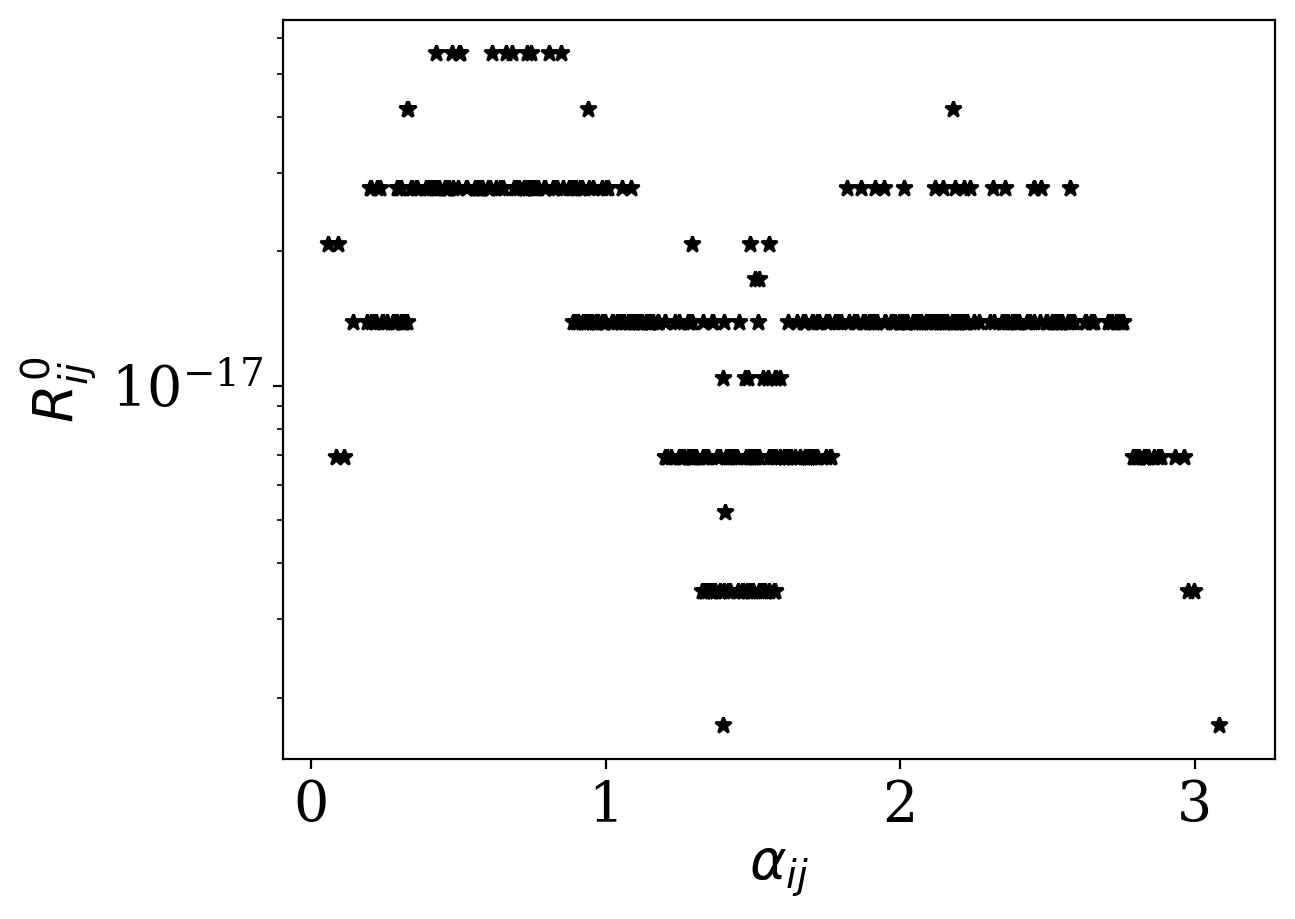

In [44]:
plt.semilogy(alpha_ij, gamma0_ij_V, '*', color='black', label='V')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{0}$')

In [45]:
# Per ogni coppia (i, j)

gamma0_ij_t = []
gamma1_ij_t = []
alpha_ij = []

for i in range(N):
    for j in range(i+1, N):
        # Rotazione per la coppia (i, j)
        p_a = pulsar_xyz[i]
        p_b = pulsar_xyz[j]

        # Step 1: porta p_a su z
        z_hat = np.array([0, 0, 1])
        v = np.cross(p_a, z_hat)
        if np.linalg.norm(v) < 1e-8:
            R1 = np.eye(3)
        else:
            theta = np.arccos(np.clip(np.dot(p_a, z_hat), -1, 1))
            R1 = rodrigues_rotation_matrix(v, theta)

        rotated1 = pulsar_xyz @ R1.T
        p_b_rot1 = p_b @ R1.T

        # Step 2: porta p_b nel piano xz
        phi = np.arctan2(p_b_rot1[1], p_b_rot1[0])
        R2 = np.array([
            [np.cos(-phi), -np.sin(-phi), 0],
            [np.sin(-phi),  np.cos(-phi), 0],
            [0,             0,            1]
        ])

        rotated_coords = rotated1 @ R2.T  # shape (N, 3)

        # Coord. di i e j nel frame ruotato
        pi_rot = rotated_coords[i]
        pj_rot = rotated_coords[j]

        # Calcola angolo tra le due pulsar nel frame originale
        alpha_ij.append(np.arccos(np.clip(np.dot(pulsar_xyz[i], pulsar_xyz[j]), -1, 1)))

        # Calcola gamma_ell per l=0,1 nel frame rotato
        gamma0_ij_t.append(AngularResponse.R_ell_pairwise(0, pi_rot, pj_rot, d[i], d[j], f, 't', psi))
        gamma1_ij_t.append(AngularResponse.R_ell_pairwise(1, pi_rot, pj_rot, d[i], d[j], f, 't', psi))

In [46]:
gamma0_ij_t = np.array(gamma0_ij_t)
gamma1_ij_t = np.array(gamma1_ij_t)

In [47]:
print(gamma0_ij_t.shape)

(1770, 100)


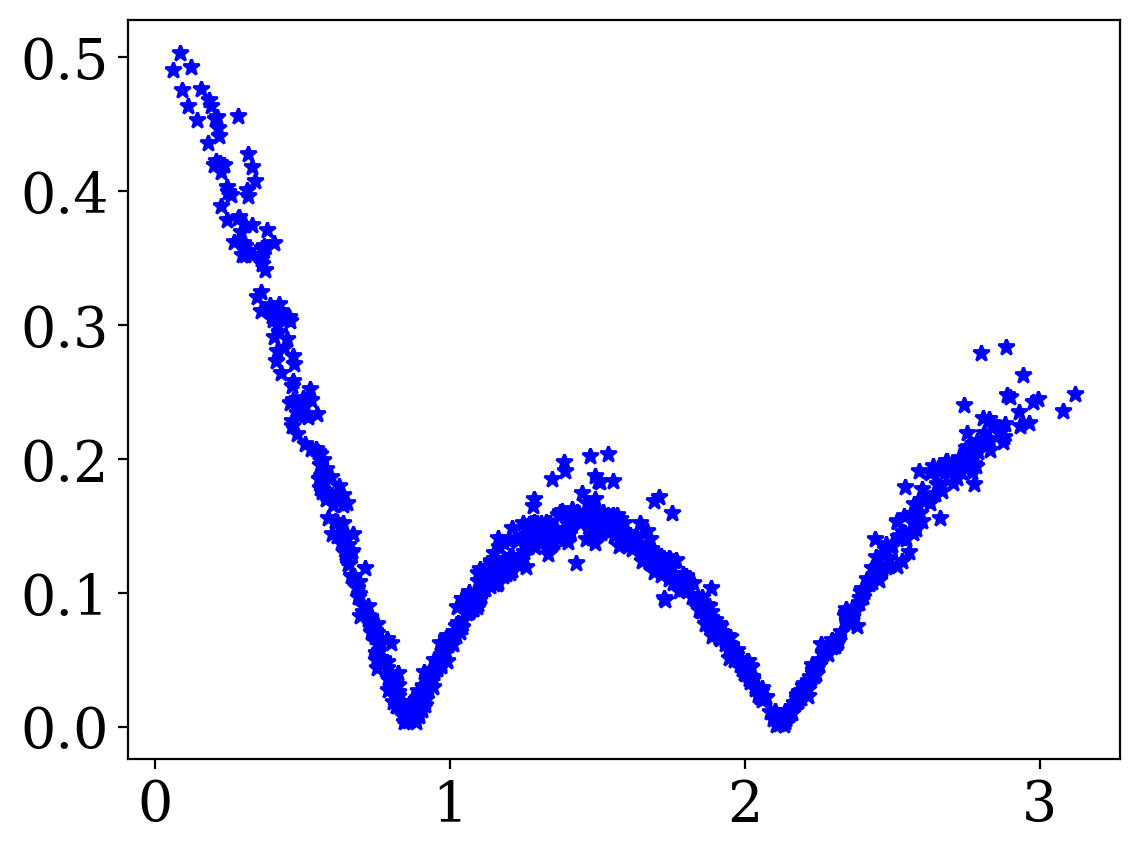

In [49]:
plt.plot(alpha_ij, gamma0_ij_t[:,20], '*', color='blue', label='t')